In [1]:
import pandas as pd
from os import path
from modules.SoundsDatabase import SoundsDatabase
from modules.SoundFeatureExtractor import  SoundFeatureExtractor
import time
import numpy as np
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
pickle_path = "./pickle.repo/data.features.v1.pickle"
pickle_data = pickle.load( open( pickle_path, "rb" ))

ids    = pickle_data["ids"]
pre_data   = pickle_data["data"]
labels = pickle_data["labels"]

In [3]:
soundsDB = SoundsDatabase("./data/train.csv", "./data/audio.files")

## Data preprocessing

- **Vectorize the labels**

In [4]:
labelEncoder = preprocessing.LabelBinarizer()
labelEncoder.fit(labels)
labels = labelEncoder.transform(labels)

In [5]:
labels

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

- Only will use the average metrics of features

In [6]:
pre_data

[{'zcr': {'avg': 0.04443359375, 'sum': 15.32958984375},
  'freq_centr': {'avg': 912.5982952841675, 'sum': 314846.4118730378},
  'spec_rol': {'avg': 3407.1768851902175, 'sum': 1175476.025390625},
  'mfccs': {'avg': array([-158.25395203,  204.53372192,  -64.29319   ,   37.00553513,
           -23.07886124,   22.84785461,   -1.28541803,    3.02474236,
            11.56956863,    2.43588257,    8.13450909,    4.00376844,
             6.76897907,    0.49065259,    4.6347661 ,   -2.49732447,
             1.16264522,   -3.21206594,   -1.89577568,   -3.98908877]),
   'sum': array([-54597.61328125,  70564.1328125 , -22181.15039062,  12766.91015625,
           -7962.20703125,   7882.50976562,   -443.46923828,   1043.53613281,
            3991.5012207 ,    840.3795166 ,   2806.40576172,   1381.30004883,
            2335.29785156,    169.27514648,   1598.9942627 ,   -861.57696533,
             401.11260986,  -1108.16271973,   -654.04260254,  -1376.2355957 ])}},
 {'zcr': {'avg': 0.0440933552194149,

In [7]:
def flatten(lis):
    new_list = list()
    for item in lis:
        if isinstance(item, np.ndarray):
            new_list = new_list + list(item)
        else:        
            new_list.append(item)
    return new_list

In [8]:
nr_features = len(flatten([metric_values["avg"] for metric_name, metric_values in pre_data[0].items()]))

In [9]:
data = np.zeros((len(pre_data), nr_features))
for i in range(len(soundsDB)):
    data[i] = flatten([metric_values["avg"] for metric_name, metric_values in pre_data[i].items()])

In [10]:
data

array([[ 4.44335938e-02,  9.12598295e+02,  3.40717689e+03, ...,
        -3.21206594e+00, -1.89577568e+00, -3.98908877e+00],
       [ 4.40933552e-02,  9.95034353e+02,  4.40543966e+03, ...,
        -7.43021297e+00,  1.44715846e+00, -6.95875597e+00],
       [ 2.12941576e-01,  2.69124667e+03,  9.80859248e+03, ...,
        -5.96402502e+00,  3.95765424e+00, -1.49883862e+01],
       ...,
       [ 2.06594914e-01,  3.44740865e+03,  1.51275349e+04, ...,
         5.65725756e+00, -2.32901931e+00,  1.43719673e+00],
       [ 1.92299701e-02,  8.00728401e+02,  3.30044880e+03, ...,
         2.76927972e+00,  5.96285248e+00,  3.78801554e-01],
       [ 1.19437840e-02,  2.62707511e+02,  9.58445992e+02, ...,
         3.71496940e+00,  6.21515512e+00,  4.84674692e+00]])

In [11]:
labels

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [12]:
labels.shape

(5435, 10)

### Data normalization

In [13]:
def normalize_data(data):
    data -= data.mean(axis=0)
    data /= data.std(axis=0)
    return data

final_data = normalize_data(data)

In [14]:
final_data

array([[-0.38210398, -0.52135136, -0.54459557, ..., -0.6909355 ,
        -0.33252751, -0.80513595],
       [-0.3872459 , -0.41856531, -0.25941771, ..., -1.42902769,
         0.23895504, -1.32110727],
       [ 2.1645065 ,  1.69637056,  1.28412332, ..., -1.17247384,
         0.66813026, -2.71623294],
       ...,
       [ 2.0685913 ,  2.63919715,  2.80360762, ...,  0.86102046,
        -0.40659154,  0.1376659 ],
       [-0.76299876, -0.66083723, -0.57508502, ...,  0.35568153,
         1.01092367, -0.04622728],
       [-0.8731127 , -1.33167287, -1.24413466, ...,  0.5211585 ,
         1.05405541,  0.73006566]])

In [15]:
final_data.shape

(5435, 23)

## Split Dataset

- Train Dataset     -> 60%
- Validate Dataset -> 20%
- Test Dataset     -> 20%

In [16]:
x_train, x_val_test, y_train, y_val_test = train_test_split(final_data, labels, test_size=0.4, random_state=69)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=69)

In [17]:
len_datasets = [len(dataset) for dataset in [x_train, x_val, x_test]]

/home/pficardoso/anaconda3/envs/francois/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


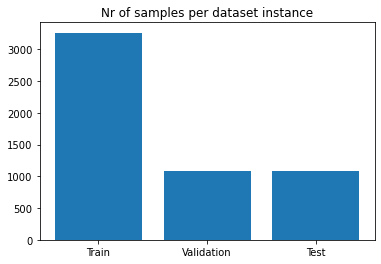

In [18]:
fig1, ax1 = plt.subplots()
ax1.bar(np.arange(3), len_datasets)
ax1.set_title("Nr of samples per dataset instance")
ax1.set_xticks(np.arange(3))
ax1.set_xticklabels(['Train', 'Validation', 'Test'])
fig1.show()

## Networks 

In [19]:
import keras as K

In [20]:
my_models = list()

my_models.append(K.models.Sequential())
my_models[0].add(K.layers.Dense(128, activation='relu', input_shape=(final_data.shape[1],)))
my_models[0].add(K.layers.Dense(64, activation='relu',))
my_models[0].add(K.layers.Dense(64, activation='relu'))
my_models[0].add(K.layers.Dense(32, activation='relu'))
my_models[0].add(K.layers.Dense(labels.shape[1], activation='softmax'))

my_models.append(K.models.Sequential())
my_models[1].add(K.layers.Dense(64, activation='relu', input_shape=(final_data.shape[1],)))
my_models[1].add(K.layers.Dense(64, activation='relu'))
my_models[1].add(K.layers.Dense(32, activation='relu'))
my_models[1].add(K.layers.Dense(labels.shape[1], activation='softmax'))


my_models.append(K.models.Sequential())
my_models[2].add(K.layers.Dense(256, activation='relu', input_shape=(final_data.shape[1],)))
my_models[2].add(K.layers.Dense(128, activation='relu'))
my_models[2].add(K.layers.Dense(64, activation='relu'))
my_models[2].add(K.layers.Dense(64, activation='relu'))
my_models[2].add(K.layers.Dense(32, activation='relu'))
my_models[2].add(K.layers.Dense(labels.shape[1], activation='softmax'))

models_history = list()
for model in my_models:
    print(model)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    
    models_history.append(model.fit(x_train, 
                                    y_train, 
                                    batch_size=512, 
                                    epochs = 1500,
                                    validation_data=(x_val, y_val)))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 3261 samples, validate on 1087 samples
Epoch 1/1500
3261/3261 [==============================] - 1s - loss: 2.2478 - acc: 0.1895 - val_loss: 2.1481 - val_acc: 0.2254
Epoch 2/1500
3261/3261 [==============================] - 0s - loss: 2.0235 - acc: 0.3177 - val_loss: 1.9516 - val_acc: 0.3192
Epoch 3/1500
3261/3261 [==============================] - 0s - loss: 1.7971 - acc: 0.4140 - val_loss: 1.7156 - val_acc: 0.4361
Epoch 4/1500
3261/3261 [==============================] - 0s - loss: 1.5732 - acc: 0.5143 - val_loss: 1.5220 - val_acc: 0.5041
Epoch 5/1500
3261/3261 [==============================] - 0s - loss: 1.4002 - acc: 0.5692 - val_loss: 1.3644 - val_acc: 0.5704
Epoch 6/1500
3261/3261 [==============================] - 0s - loss: 1.2696 - acc: 0.6059 - val_loss: 1.2576 - val_acc: 0.5796
Epoch 7/1500
3261/3261 [====================

3261/3261 [==============================] - 0s - loss: 0.2143 - acc: 0.9439 - val_loss: 0.4977 - val_acc: 0.8500
Epoch 59/1500
3261/3261 [==============================] - 0s - loss: 0.2106 - acc: 0.9427 - val_loss: 0.4827 - val_acc: 0.8583
Epoch 60/1500
3261/3261 [==============================] - 0s - loss: 0.2080 - acc: 0.9460 - val_loss: 0.5356 - val_acc: 0.8399
Epoch 61/1500
3261/3261 [==============================] - 0s - loss: 0.1937 - acc: 0.9473 - val_loss: 0.5170 - val_acc: 0.8491
Epoch 62/1500
3261/3261 [==============================] - 0s - loss: 0.2020 - acc: 0.9451 - val_loss: 0.5024 - val_acc: 0.8519
Epoch 63/1500
3261/3261 [==============================] - 0s - loss: 0.1842 - acc: 0.9503 - val_loss: 0.4726 - val_acc: 0.8684
Epoch 64/1500
3261/3261 [==============================] - 0s - loss: 0.1979 - acc: 0.9479 - val_loss: 0.4761 - val_acc: 0.8620
Epoch 65/1500
3261/3261 [==============================] - 0s - loss: 0.1671 - acc: 0.9598 - val_loss: 0.4761 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0660 - acc: 0.9844 - val_loss: 0.5008 - val_acc: 0.8924
Epoch 122/1500
3261/3261 [==============================] - 0s - loss: 0.0262 - acc: 0.9972 - val_loss: 0.5080 - val_acc: 0.8878
Epoch 123/1500
3261/3261 [==============================] - 0s - loss: 0.0255 - acc: 0.9975 - val_loss: 0.5176 - val_acc: 0.8859
Epoch 124/1500
3261/3261 [==============================] - 0s - loss: 0.0766 - acc: 0.9745 - val_loss: 0.5547 - val_acc: 0.8795
Epoch 125/1500
3261/3261 [==============================] - 0s - loss: 0.0258 - acc: 0.9979 - val_loss: 0.5071 - val_acc: 0.8942
Epoch 126/1500
3261/3261 [==============================] - 0s - loss: 0.0218 - acc: 0.9975 - val_loss: 0.5027 - val_acc: 0.8933
Epoch 127/1500
3261/3261 [==============================] - 0s - loss: 0.0208 - acc: 0.9979 - val_loss: 0.5484 - val_acc: 0.8758
Epoch 128/1500
3261/3261 [==============================] - 0s - loss: 0.0631 - acc: 0.9831 - val_loss: 0.5337 -

3261/3261 [==============================] - 0s - loss: 0.0056 - acc: 0.9994 - val_loss: 0.5979 - val_acc: 0.8933
Epoch 185/1500
3261/3261 [==============================] - 0s - loss: 0.0043 - acc: 0.9997 - val_loss: 0.5838 - val_acc: 0.8988
Epoch 186/1500
3261/3261 [==============================] - 0s - loss: 0.0504 - acc: 0.9841 - val_loss: 0.6332 - val_acc: 0.8887
Epoch 187/1500
3261/3261 [==============================] - 0s - loss: 0.0075 - acc: 0.9991 - val_loss: 0.6223 - val_acc: 0.8933
Epoch 188/1500
3261/3261 [==============================] - 0s - loss: 0.0057 - acc: 0.9994 - val_loss: 0.5887 - val_acc: 0.8970
Epoch 189/1500
3261/3261 [==============================] - 0s - loss: 0.0044 - acc: 0.9994 - val_loss: 0.5930 - val_acc: 0.8988
Epoch 190/1500
3261/3261 [==============================] - 0s - loss: 0.0044 - acc: 0.9997 - val_loss: 0.5841 - val_acc: 0.8997
Epoch 191/1500
3261/3261 [==============================] - 0s - loss: 0.0064 - acc: 0.9991 - val_loss: 0.5918 -

3261/3261 [==============================] - 0s - loss: 0.0017 - acc: 0.9997 - val_loss: 0.6603 - val_acc: 0.9006
Epoch 248/1500
3261/3261 [==============================] - 0s - loss: 0.0031 - acc: 0.9994 - val_loss: 0.6641 - val_acc: 0.8924
Epoch 249/1500
3261/3261 [==============================] - 0s - loss: 0.0033 - acc: 0.9994 - val_loss: 0.6474 - val_acc: 0.9043
Epoch 250/1500
3261/3261 [==============================] - 0s - loss: 0.0027 - acc: 0.9994 - val_loss: 0.6464 - val_acc: 0.9034
Epoch 251/1500
3261/3261 [==============================] - 0s - loss: 0.0038 - acc: 0.9994 - val_loss: 0.6792 - val_acc: 0.8914
Epoch 252/1500
3261/3261 [==============================] - 0s - loss: 0.0069 - acc: 0.9985 - val_loss: 0.6627 - val_acc: 0.8979
Epoch 253/1500
3261/3261 [==============================] - 0s - loss: 0.0017 - acc: 0.9997 - val_loss: 0.6794 - val_acc: 0.8951
Epoch 254/1500
3261/3261 [==============================] - 0s - loss: 0.0023 - acc: 0.9994 - val_loss: 0.7394 -

3261/3261 [==============================] - 0s - loss: 0.0047 - acc: 0.9994 - val_loss: 0.6937 - val_acc: 0.8970
Epoch 311/1500
3261/3261 [==============================] - 0s - loss: 0.0393 - acc: 0.9917 - val_loss: 0.7961 - val_acc: 0.8914
Epoch 312/1500
3261/3261 [==============================] - 0s - loss: 0.0043 - acc: 0.9988 - val_loss: 0.7416 - val_acc: 0.8979
Epoch 313/1500
3261/3261 [==============================] - 0s - loss: 0.0021 - acc: 0.9997 - val_loss: 0.7055 - val_acc: 0.8970
Epoch 314/1500
3261/3261 [==============================] - 0s - loss: 0.0021 - acc: 0.9991 - val_loss: 0.7087 - val_acc: 0.9006
Epoch 315/1500
3261/3261 [==============================] - 0s - loss: 0.0025 - acc: 0.9994 - val_loss: 0.7419 - val_acc: 0.8960
Epoch 316/1500
3261/3261 [==============================] - 0s - loss: 0.0028 - acc: 0.9997 - val_loss: 0.6973 - val_acc: 0.8988
Epoch 317/1500
3261/3261 [==============================] - 0s - loss: 0.0015 - acc: 0.9997 - val_loss: 0.6996 -

3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.7280 - val_acc: 0.8988
Epoch 374/1500
3261/3261 [==============================] - 0s - loss: 0.0012 - acc: 0.9997 - val_loss: 0.7199 - val_acc: 0.9025
Epoch 375/1500
3261/3261 [==============================] - 0s - loss: 0.0032 - acc: 0.9991 - val_loss: 0.7194 - val_acc: 0.9016
Epoch 376/1500
3261/3261 [==============================] - 0s - loss: 0.0017 - acc: 0.9994 - val_loss: 0.7215 - val_acc: 0.9006
Epoch 377/1500
3261/3261 [==============================] - 0s - loss: 0.0021 - acc: 0.9994 - val_loss: 0.7170 - val_acc: 0.9025
Epoch 378/1500
3261/3261 [==============================] - 0s - loss: 0.0012 - acc: 0.9997 - val_loss: 0.7278 - val_acc: 0.9016
Epoch 379/1500
3261/3261 [==============================] - 0s - loss: 8.8269e-04 - acc: 0.9997 - val_loss: 0.7642 - val_acc: 0.8905
Epoch 380/1500
3261/3261 [==============================] - 0s - loss: 0.0710 - acc: 0.9847 - val_loss: 0.71

3261/3261 [==============================] - 0s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.7722 - val_acc: 0.9006
Epoch 437/1500
3261/3261 [==============================] - 0s - loss: 0.0016 - acc: 0.9994 - val_loss: 0.7617 - val_acc: 0.8979
Epoch 438/1500
3261/3261 [==============================] - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 0.7706 - val_acc: 0.8997
Epoch 439/1500
3261/3261 [==============================] - 0s - loss: 0.0012 - acc: 0.9997 - val_loss: 0.7443 - val_acc: 0.9016
Epoch 440/1500
3261/3261 [==============================] - 0s - loss: 4.3055e-04 - acc: 1.0000 - val_loss: 0.8319 - val_acc: 0.8924
Epoch 441/1500
3261/3261 [==============================] - 0s - loss: 0.0027 - acc: 0.9997 - val_loss: 0.7560 - val_acc: 0.8997
Epoch 442/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.7497 - val_acc: 0.8942
Epoch 443/1500
3261/3261 [==============================] - 0s - loss: 4.1745e-04 - acc: 1.0000 - val_loss: 

3261/3261 [==============================] - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 0.7917 - val_acc: 0.8997
Epoch 499/1500
3261/3261 [==============================] - 0s - loss: 8.9237e-04 - acc: 0.9997 - val_loss: 0.7836 - val_acc: 0.9052
Epoch 500/1500
3261/3261 [==============================] - 0s - loss: 0.0027 - acc: 0.9994 - val_loss: 0.8096 - val_acc: 0.8988
Epoch 501/1500
3261/3261 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 0.7844 - val_acc: 0.8979
Epoch 502/1500
3261/3261 [==============================] - 0s - loss: 0.0316 - acc: 0.9911 - val_loss: 0.8268 - val_acc: 0.8960
Epoch 503/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.8093 - val_acc: 0.8988
Epoch 504/1500
3261/3261 [==============================] - 0s - loss: 7.4160e-04 - acc: 0.9997 - val_loss: 0.8146 - val_acc: 0.8997
Epoch 505/1500
3261/3261 [==============================] - 0s - loss: 8.8135e-04 - acc: 0.9997 - val_lo

3261/3261 [==============================] - 0s - loss: 8.8582e-04 - acc: 0.9997 - val_loss: 0.8224 - val_acc: 0.8960
Epoch 561/1500
3261/3261 [==============================] - 0s - loss: 0.0010 - acc: 0.9994 - val_loss: 0.8526 - val_acc: 0.8960
Epoch 562/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.8161 - val_acc: 0.8997
Epoch 563/1500
3261/3261 [==============================] - 0s - loss: 9.5873e-04 - acc: 0.9994 - val_loss: 0.8234 - val_acc: 0.8997
Epoch 564/1500
3261/3261 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 0.8133 - val_acc: 0.8979
Epoch 565/1500
3261/3261 [==============================] - 0s - loss: 8.0095e-04 - acc: 0.9994 - val_loss: 0.8268 - val_acc: 0.8979
Epoch 566/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 0.8302 - val_acc: 0.8970
Epoch 567/1500
3261/3261 [==============================] - 0s - loss: 6.3832e-04 - acc: 0.9997 - va

3261/3261 [==============================] - 0s - loss: 7.1825e-04 - acc: 0.9997 - val_loss: 0.8101 - val_acc: 0.9089
Epoch 623/1500
3261/3261 [==============================] - 0s - loss: 7.7611e-04 - acc: 0.9994 - val_loss: 0.8144 - val_acc: 0.9080
Epoch 624/1500
3261/3261 [==============================] - 0s - loss: 5.2838e-04 - acc: 0.9997 - val_loss: 0.8346 - val_acc: 0.9016
Epoch 625/1500
3261/3261 [==============================] - 0s - loss: 0.0214 - acc: 0.9954 - val_loss: 0.9310 - val_acc: 0.8979
Epoch 626/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.8576 - val_acc: 0.9052
Epoch 627/1500
3261/3261 [==============================] - 0s - loss: 5.2171e-04 - acc: 0.9997 - val_loss: 0.8489 - val_acc: 0.9052
Epoch 628/1500
3261/3261 [==============================] - 0s - loss: 5.7666e-04 - acc: 0.9997 - val_loss: 0.8436 - val_acc: 0.9071
Epoch 629/1500
3261/3261 [==============================] - 0s - loss: 5.8999e-04 - acc: 0.9

3261/3261 [==============================] - 0s - loss: 5.8959e-04 - acc: 0.9997 - val_loss: 0.8237 - val_acc: 0.9016
Epoch 684/1500
3261/3261 [==============================] - 0s - loss: 5.5141e-04 - acc: 0.9997 - val_loss: 0.8226 - val_acc: 0.9016
Epoch 685/1500
3261/3261 [==============================] - 0s - loss: 5.7657e-04 - acc: 0.9994 - val_loss: 0.8225 - val_acc: 0.8997
Epoch 686/1500
3261/3261 [==============================] - 0s - loss: 5.5219e-04 - acc: 0.9997 - val_loss: 0.8331 - val_acc: 0.8997
Epoch 687/1500
3261/3261 [==============================] - 0s - loss: 7.3969e-04 - acc: 0.9997 - val_loss: 0.8288 - val_acc: 0.9034
Epoch 688/1500
3261/3261 [==============================] - 0s - loss: 6.9994e-04 - acc: 0.9997 - val_loss: 0.8311 - val_acc: 0.9016
Epoch 689/1500
3261/3261 [==============================] - 0s - loss: 6.2251e-04 - acc: 0.9994 - val_loss: 0.8294 - val_acc: 0.8997
Epoch 690/1500
3261/3261 [==============================] - 0s - loss: 6.2746e-04 - 

3261/3261 [==============================] - 0s - loss: 6.6632e-04 - acc: 0.9994 - val_loss: 0.8323 - val_acc: 0.9052
Epoch 745/1500
3261/3261 [==============================] - 0s - loss: 6.9496e-04 - acc: 0.9994 - val_loss: 0.8402 - val_acc: 0.9062
Epoch 746/1500
3261/3261 [==============================] - 0s - loss: 6.4494e-04 - acc: 0.9997 - val_loss: 0.8783 - val_acc: 0.8988
Epoch 747/1500
3261/3261 [==============================] - 0s - loss: 0.0701 - acc: 0.9893 - val_loss: 0.8841 - val_acc: 0.8933
Epoch 748/1500
3261/3261 [==============================] - 0s - loss: 5.8804e-04 - acc: 0.9997 - val_loss: 0.8773 - val_acc: 0.8951
Epoch 749/1500
3261/3261 [==============================] - 0s - loss: 5.2291e-04 - acc: 0.9997 - val_loss: 0.8727 - val_acc: 0.8933
Epoch 750/1500
3261/3261 [==============================] - 0s - loss: 5.0232e-04 - acc: 0.9997 - val_loss: 0.8676 - val_acc: 0.8951
Epoch 751/1500
3261/3261 [==============================] - 0s - loss: 4.9057e-04 - acc:

3261/3261 [==============================] - 0s - loss: 7.8941e-04 - acc: 0.9994 - val_loss: 0.9084 - val_acc: 0.9016
Epoch 806/1500
3261/3261 [==============================] - 0s - loss: 7.9657e-04 - acc: 0.9994 - val_loss: 0.8965 - val_acc: 0.9006
Epoch 807/1500
3261/3261 [==============================] - 0s - loss: 0.0460 - acc: 0.9893 - val_loss: 0.9278 - val_acc: 0.8960
Epoch 808/1500
3261/3261 [==============================] - 0s - loss: 7.5789e-04 - acc: 0.9997 - val_loss: 0.9196 - val_acc: 0.8979
Epoch 809/1500
3261/3261 [==============================] - 0s - loss: 5.8196e-04 - acc: 0.9997 - val_loss: 0.9176 - val_acc: 0.8997
Epoch 810/1500
3261/3261 [==============================] - 0s - loss: 5.8543e-04 - acc: 0.9997 - val_loss: 0.9187 - val_acc: 0.8988
Epoch 811/1500
3261/3261 [==============================] - 0s - loss: 5.2657e-04 - acc: 0.9997 - val_loss: 0.9197 - val_acc: 0.8997
Epoch 812/1500
3261/3261 [==============================] - 0s - loss: 5.3840e-04 - acc:

3261/3261 [==============================] - 0s - loss: 4.9577e-04 - acc: 0.9997 - val_loss: 0.9407 - val_acc: 0.9025
Epoch 867/1500
3261/3261 [==============================] - 0s - loss: 4.7509e-04 - acc: 0.9997 - val_loss: 0.9405 - val_acc: 0.9034
Epoch 868/1500
3261/3261 [==============================] - 0s - loss: 4.7518e-04 - acc: 0.9997 - val_loss: 0.9392 - val_acc: 0.9034
Epoch 869/1500
3261/3261 [==============================] - 0s - loss: 4.9084e-04 - acc: 0.9997 - val_loss: 0.9362 - val_acc: 0.9034
Epoch 870/1500
3261/3261 [==============================] - 0s - loss: 5.0541e-04 - acc: 0.9997 - val_loss: 0.9345 - val_acc: 0.9025
Epoch 871/1500
3261/3261 [==============================] - 0s - loss: 5.1803e-04 - acc: 0.9997 - val_loss: 0.9337 - val_acc: 0.9043
Epoch 872/1500
3261/3261 [==============================] - 0s - loss: 5.2999e-04 - acc: 0.9994 - val_loss: 0.9317 - val_acc: 0.9043
Epoch 873/1500
3261/3261 [==============================] - 0s - loss: 5.4490e-04 - 

3261/3261 [==============================] - 0s - loss: 4.5478e-04 - acc: 0.9997 - val_loss: 0.9312 - val_acc: 0.9016
Epoch 928/1500
3261/3261 [==============================] - 0s - loss: 5.4630e-04 - acc: 0.9997 - val_loss: 0.9202 - val_acc: 0.8970
Epoch 929/1500
3261/3261 [==============================] - 0s - loss: 5.2613e-04 - acc: 0.9997 - val_loss: 0.9609 - val_acc: 0.8997
Epoch 930/1500
3261/3261 [==============================] - 0s - loss: 4.3979e-04 - acc: 0.9997 - val_loss: 0.9437 - val_acc: 0.8988
Epoch 931/1500
3261/3261 [==============================] - 0s - loss: 0.0167 - acc: 0.9960 - val_loss: 1.0244 - val_acc: 0.8979
Epoch 932/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 0.9919 - val_acc: 0.8979
Epoch 933/1500
3261/3261 [==============================] - 0s - loss: 4.6471e-04 - acc: 0.9997 - val_loss: 0.9898 - val_acc: 0.8979
Epoch 934/1500
3261/3261 [==============================] - 0s - loss: 4.5732e-04 - acc: 0.9

3261/3261 [==============================] - 0s - loss: 6.3687e-04 - acc: 0.9997 - val_loss: 0.9638 - val_acc: 0.8970
Epoch 989/1500
3261/3261 [==============================] - 0s - loss: 5.2200e-04 - acc: 0.9994 - val_loss: 0.9560 - val_acc: 0.9016
Epoch 990/1500
3261/3261 [==============================] - 0s - loss: 4.9806e-04 - acc: 0.9997 - val_loss: 0.9760 - val_acc: 0.9006
Epoch 991/1500
3261/3261 [==============================] - 0s - loss: 5.2702e-04 - acc: 0.9994 - val_loss: 0.9842 - val_acc: 0.9006
Epoch 992/1500
3261/3261 [==============================] - 0s - loss: 0.0648 - acc: 0.9923 - val_loss: 1.2133 - val_acc: 0.8749
Epoch 993/1500
3261/3261 [==============================] - 0s - loss: 0.0099 - acc: 0.9963 - val_loss: 1.0385 - val_acc: 0.8905
Epoch 994/1500
3261/3261 [==============================] - 0s - loss: 5.2882e-04 - acc: 0.9997 - val_loss: 1.0285 - val_acc: 0.8914
Epoch 995/1500
3261/3261 [==============================] - 0s - loss: 4.7927e-04 - acc: 0.9

3261/3261 [==============================] - 0s - loss: 5.4121e-04 - acc: 0.9994 - val_loss: 0.9752 - val_acc: 0.8997
Epoch 1050/1500
3261/3261 [==============================] - 0s - loss: 4.8849e-04 - acc: 0.9997 - val_loss: 0.9743 - val_acc: 0.8997
Epoch 1051/1500
3261/3261 [==============================] - 0s - loss: 5.2673e-04 - acc: 0.9997 - val_loss: 0.9770 - val_acc: 0.8997
Epoch 1052/1500
3261/3261 [==============================] - 0s - loss: 5.7593e-04 - acc: 0.9997 - val_loss: 0.9971 - val_acc: 0.8970
Epoch 1053/1500
3261/3261 [==============================] - 0s - loss: 5.1088e-04 - acc: 0.9997 - val_loss: 0.9839 - val_acc: 0.8942
Epoch 1054/1500
3261/3261 [==============================] - 0s - loss: 6.5123e-04 - acc: 0.9997 - val_loss: 0.9747 - val_acc: 0.8979
Epoch 1055/1500
3261/3261 [==============================] - 0s - loss: 5.7209e-04 - acc: 0.9997 - val_loss: 0.9672 - val_acc: 0.8988
Epoch 1056/1500
3261/3261 [==============================] - 0s - loss: 5.1931

3261/3261 [==============================] - 0s - loss: 5.5375e-04 - acc: 0.9994 - val_loss: 0.9672 - val_acc: 0.9016
Epoch 1111/1500
3261/3261 [==============================] - 0s - loss: 6.2507e-04 - acc: 0.9997 - val_loss: 0.9601 - val_acc: 0.9006
Epoch 1112/1500
3261/3261 [==============================] - 0s - loss: 4.8572e-04 - acc: 0.9997 - val_loss: 0.9662 - val_acc: 0.8997
Epoch 1113/1500
3261/3261 [==============================] - 0s - loss: 6.3229e-04 - acc: 0.9994 - val_loss: 0.9790 - val_acc: 0.8988
Epoch 1114/1500
3261/3261 [==============================] - 0s - loss: 5.1047e-04 - acc: 0.9997 - val_loss: 0.9812 - val_acc: 0.8942
Epoch 1115/1500
3261/3261 [==============================] - 0s - loss: 4.9846e-04 - acc: 0.9997 - val_loss: 0.9996 - val_acc: 0.8970
Epoch 1116/1500
3261/3261 [==============================] - 0s - loss: 0.0769 - acc: 0.9877 - val_loss: 0.9807 - val_acc: 0.8951
Epoch 1117/1500
3261/3261 [==============================] - 0s - loss: 4.6846e-04

3261/3261 [==============================] - 0s - loss: 4.9685e-04 - acc: 0.9997 - val_loss: 0.9665 - val_acc: 0.8988
Epoch 1172/1500
3261/3261 [==============================] - 0s - loss: 5.0360e-04 - acc: 0.9994 - val_loss: 0.9661 - val_acc: 0.8988
Epoch 1173/1500
3261/3261 [==============================] - 0s - loss: 5.9638e-04 - acc: 0.9994 - val_loss: 0.9662 - val_acc: 0.8988
Epoch 1174/1500
3261/3261 [==============================] - 0s - loss: 8.6740e-04 - acc: 0.9994 - val_loss: 0.9617 - val_acc: 0.8997
Epoch 1175/1500
3261/3261 [==============================] - 0s - loss: 4.7730e-04 - acc: 0.9997 - val_loss: 0.9665 - val_acc: 0.9006
Epoch 1176/1500
3261/3261 [==============================] - 0s - loss: 4.9861e-04 - acc: 0.9997 - val_loss: 0.9739 - val_acc: 0.9016
Epoch 1177/1500
3261/3261 [==============================] - 0s - loss: 4.9774e-04 - acc: 0.9994 - val_loss: 0.9690 - val_acc: 0.9016
Epoch 1178/1500
3261/3261 [==============================] - 0s - loss: 4.8336

3261/3261 [==============================] - 0s - loss: 0.0694 - acc: 0.9890 - val_loss: 1.0574 - val_acc: 0.8979
Epoch 1233/1500
3261/3261 [==============================] - 0s - loss: 8.9390e-04 - acc: 0.9997 - val_loss: 1.0449 - val_acc: 0.8905
Epoch 1234/1500
3261/3261 [==============================] - 0s - loss: 5.3354e-04 - acc: 0.9997 - val_loss: 1.0412 - val_acc: 0.8942
Epoch 1235/1500
3261/3261 [==============================] - 0s - loss: 4.7673e-04 - acc: 0.9997 - val_loss: 1.0387 - val_acc: 0.8933
Epoch 1236/1500
3261/3261 [==============================] - 0s - loss: 4.7966e-04 - acc: 0.9997 - val_loss: 1.0369 - val_acc: 0.8933
Epoch 1237/1500
3261/3261 [==============================] - 0s - loss: 4.4713e-04 - acc: 0.9997 - val_loss: 1.0344 - val_acc: 0.8942
Epoch 1238/1500
3261/3261 [==============================] - 0s - loss: 4.3397e-04 - acc: 0.9997 - val_loss: 1.0318 - val_acc: 0.8951
Epoch 1239/1500
3261/3261 [==============================] - 0s - loss: 4.2757e-04

3261/3261 [==============================] - 0s - loss: 4.8784e-04 - acc: 0.9994 - val_loss: 1.0381 - val_acc: 0.8979
Epoch 1294/1500
3261/3261 [==============================] - 0s - loss: 4.9158e-04 - acc: 0.9994 - val_loss: 1.0365 - val_acc: 0.8979
Epoch 1295/1500
3261/3261 [==============================] - 0s - loss: 5.0758e-04 - acc: 0.9994 - val_loss: 1.0351 - val_acc: 0.8970
Epoch 1296/1500
3261/3261 [==============================] - 0s - loss: 5.4028e-04 - acc: 0.9997 - val_loss: 1.0333 - val_acc: 0.8979
Epoch 1297/1500
3261/3261 [==============================] - 0s - loss: 5.0573e-04 - acc: 0.9994 - val_loss: 1.0354 - val_acc: 0.8988
Epoch 1298/1500
3261/3261 [==============================] - 0s - loss: 4.9381e-04 - acc: 0.9997 - val_loss: 1.0346 - val_acc: 0.8979
Epoch 1299/1500
3261/3261 [==============================] - 0s - loss: 4.8349e-04 - acc: 0.9997 - val_loss: 1.0369 - val_acc: 0.8942
Epoch 1300/1500
3261/3261 [==============================] - 0s - loss: 5.3989

3261/3261 [==============================] - 0s - loss: 4.7483e-04 - acc: 0.9997 - val_loss: 1.0168 - val_acc: 0.8979
Epoch 1355/1500
3261/3261 [==============================] - 0s - loss: 4.6058e-04 - acc: 0.9997 - val_loss: 1.0196 - val_acc: 0.8997
Epoch 1356/1500
3261/3261 [==============================] - 0s - loss: 4.7741e-04 - acc: 0.9994 - val_loss: 1.0216 - val_acc: 0.8997
Epoch 1357/1500
3261/3261 [==============================] - 0s - loss: 4.6752e-04 - acc: 0.9997 - val_loss: 1.0227 - val_acc: 0.8997
Epoch 1358/1500
3261/3261 [==============================] - 0s - loss: 4.7338e-04 - acc: 0.9997 - val_loss: 1.0243 - val_acc: 0.9006
Epoch 1359/1500
3261/3261 [==============================] - 0s - loss: 4.8323e-04 - acc: 0.9994 - val_loss: 1.0302 - val_acc: 0.8979
Epoch 1360/1500
3261/3261 [==============================] - 0s - loss: 4.7599e-04 - acc: 0.9994 - val_loss: 1.0312 - val_acc: 0.8979
Epoch 1361/1500
3261/3261 [==============================] - 0s - loss: 4.8529

3261/3261 [==============================] - 0s - loss: 4.8297e-04 - acc: 0.9997 - val_loss: 1.0345 - val_acc: 0.9043
Epoch 1416/1500
3261/3261 [==============================] - 0s - loss: 5.3943e-04 - acc: 0.9997 - val_loss: 1.0332 - val_acc: 0.9025
Epoch 1417/1500
3261/3261 [==============================] - 0s - loss: 4.6989e-04 - acc: 0.9997 - val_loss: 1.0285 - val_acc: 0.9006
Epoch 1418/1500
3261/3261 [==============================] - 0s - loss: 4.5451e-04 - acc: 0.9997 - val_loss: 1.0278 - val_acc: 0.9016
Epoch 1419/1500
3261/3261 [==============================] - 0s - loss: 4.6284e-04 - acc: 0.9994 - val_loss: 1.0269 - val_acc: 0.9043
Epoch 1420/1500
3261/3261 [==============================] - 0s - loss: 4.6632e-04 - acc: 0.9997 - val_loss: 1.0266 - val_acc: 0.9034
Epoch 1421/1500
3261/3261 [==============================] - 0s - loss: 4.7067e-04 - acc: 0.9997 - val_loss: 1.0300 - val_acc: 0.9025
Epoch 1422/1500
3261/3261 [==============================] - 0s - loss: 4.6058

3261/3261 [==============================] - 0s - loss: 4.8237e-04 - acc: 0.9997 - val_loss: 1.0240 - val_acc: 0.9062
Epoch 1477/1500
3261/3261 [==============================] - 0s - loss: 4.9228e-04 - acc: 0.9997 - val_loss: 1.0274 - val_acc: 0.9034
Epoch 1478/1500
3261/3261 [==============================] - 0s - loss: 6.8551e-04 - acc: 0.9994 - val_loss: 1.2028 - val_acc: 0.8896
Epoch 1479/1500
3261/3261 [==============================] - 0s - loss: 0.0577 - acc: 0.9890 - val_loss: 1.0596 - val_acc: 0.9006
Epoch 1480/1500
3261/3261 [==============================] - 0s - loss: 4.6454e-04 - acc: 0.9997 - val_loss: 1.0524 - val_acc: 0.9034
Epoch 1481/1500
3261/3261 [==============================] - 0s - loss: 4.3347e-04 - acc: 0.9997 - val_loss: 1.0501 - val_acc: 0.9025
Epoch 1482/1500
3261/3261 [==============================] - 0s - loss: 4.3961e-04 - acc: 0.9997 - val_loss: 1.0481 - val_acc: 0.9025
Epoch 1483/1500
3261/3261 [==============================] - 0s - loss: 4.4138e-04

3261/3261 [==============================] - 0s - loss: 0.5561 - acc: 0.8267 - val_loss: 0.7137 - val_acc: 0.7755
Epoch 39/1500
3261/3261 [==============================] - 0s - loss: 0.5452 - acc: 0.8344 - val_loss: 0.7034 - val_acc: 0.7820
Epoch 40/1500
3261/3261 [==============================] - 0s - loss: 0.5362 - acc: 0.8341 - val_loss: 0.6908 - val_acc: 0.7783
Epoch 41/1500
3261/3261 [==============================] - 0s - loss: 0.5243 - acc: 0.8375 - val_loss: 0.6790 - val_acc: 0.7783
Epoch 42/1500
3261/3261 [==============================] - 0s - loss: 0.5116 - acc: 0.8424 - val_loss: 0.6838 - val_acc: 0.7902
Epoch 43/1500
3261/3261 [==============================] - 0s - loss: 0.5069 - acc: 0.8439 - val_loss: 0.6584 - val_acc: 0.7912
Epoch 44/1500
3261/3261 [==============================] - 0s - loss: 0.4927 - acc: 0.8500 - val_loss: 0.6583 - val_acc: 0.7884
Epoch 45/1500
3261/3261 [==============================] - 0s - loss: 0.4876 - acc: 0.8519 - val_loss: 0.6639 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1850 - acc: 0.9528 - val_loss: 0.4723 - val_acc: 0.8602
Epoch 102/1500
3261/3261 [==============================] - 0s - loss: 0.1806 - acc: 0.9558 - val_loss: 0.4782 - val_acc: 0.8510
Epoch 103/1500
3261/3261 [==============================] - 0s - loss: 0.1770 - acc: 0.9519 - val_loss: 0.4850 - val_acc: 0.8565
Epoch 104/1500
3261/3261 [==============================] - 0s - loss: 0.1770 - acc: 0.9558 - val_loss: 0.4792 - val_acc: 0.8565
Epoch 105/1500
3261/3261 [==============================] - 0s - loss: 0.1734 - acc: 0.9565 - val_loss: 0.4847 - val_acc: 0.8528
Epoch 106/1500
3261/3261 [==============================] - 0s - loss: 0.1692 - acc: 0.9583 - val_loss: 0.4731 - val_acc: 0.8657
Epoch 107/1500
3261/3261 [==============================] - 0s - loss: 0.1649 - acc: 0.9604 - val_loss: 0.4884 - val_acc: 0.8464
Epoch 108/1500
3261/3261 [==============================] - 0s - loss: 0.1620 - acc: 0.9601 - val_loss: 0.4924 -

3261/3261 [==============================] - 0s - loss: 0.0542 - acc: 0.9926 - val_loss: 0.5162 - val_acc: 0.8758
Epoch 165/1500
3261/3261 [==============================] - 0s - loss: 0.0579 - acc: 0.9905 - val_loss: 0.5079 - val_acc: 0.8721
Epoch 166/1500
3261/3261 [==============================] - 0s - loss: 0.0541 - acc: 0.9905 - val_loss: 0.5110 - val_acc: 0.8740
Epoch 167/1500
3261/3261 [==============================] - 0s - loss: 0.0547 - acc: 0.9899 - val_loss: 0.5100 - val_acc: 0.8620
Epoch 168/1500
3261/3261 [==============================] - 0s - loss: 0.0542 - acc: 0.9908 - val_loss: 0.5115 - val_acc: 0.8749
Epoch 169/1500
3261/3261 [==============================] - 0s - loss: 0.0493 - acc: 0.9939 - val_loss: 0.5066 - val_acc: 0.8712
Epoch 170/1500
3261/3261 [==============================] - ETA: 0s - loss: 0.0471 - acc: 0.994 - 0s - loss: 0.0536 - acc: 0.9926 - val_loss: 0.5399 - val_acc: 0.8657
Epoch 171/1500
3261/3261 [==============================] - 0s - loss: 0.0

3261/3261 [==============================] - 0s - loss: 0.0152 - acc: 0.9988 - val_loss: 0.5996 - val_acc: 0.8786
Epoch 228/1500
3261/3261 [==============================] - 0s - loss: 0.0152 - acc: 0.9985 - val_loss: 0.6122 - val_acc: 0.8767
Epoch 229/1500
3261/3261 [==============================] - 0s - loss: 0.0134 - acc: 0.9994 - val_loss: 0.6234 - val_acc: 0.8795
Epoch 230/1500
3261/3261 [==============================] - 0s - loss: 0.0155 - acc: 0.9991 - val_loss: 0.6449 - val_acc: 0.8767
Epoch 231/1500
3261/3261 [==============================] - 0s - loss: 0.0134 - acc: 0.9997 - val_loss: 0.6326 - val_acc: 0.8749
Epoch 232/1500
3261/3261 [==============================] - 0s - loss: 0.0126 - acc: 0.9994 - val_loss: 0.6728 - val_acc: 0.8758
Epoch 233/1500
3261/3261 [==============================] - 0s - loss: 0.0245 - acc: 0.9948 - val_loss: 0.6182 - val_acc: 0.8776
Epoch 234/1500
3261/3261 [==============================] - 0s - loss: 0.0107 - acc: 0.9994 - val_loss: 0.6261 -

3261/3261 [==============================] - 0s - loss: 0.0046 - acc: 0.9994 - val_loss: 0.6989 - val_acc: 0.8859
Epoch 291/1500
3261/3261 [==============================] - 0s - loss: 0.0034 - acc: 0.9997 - val_loss: 0.7128 - val_acc: 0.8795
Epoch 292/1500
3261/3261 [==============================] - 0s - loss: 0.0046 - acc: 0.9994 - val_loss: 0.7130 - val_acc: 0.8878
Epoch 293/1500
3261/3261 [==============================] - 0s - loss: 0.0054 - acc: 0.9991 - val_loss: 0.7341 - val_acc: 0.8749
Epoch 294/1500
3261/3261 [==============================] - 0s - loss: 0.0059 - acc: 0.9991 - val_loss: 0.7196 - val_acc: 0.8822
Epoch 295/1500
3261/3261 [==============================] - 0s - loss: 0.0033 - acc: 0.9994 - val_loss: 0.7144 - val_acc: 0.8878
Epoch 296/1500
3261/3261 [==============================] - 0s - loss: 0.0042 - acc: 0.9997 - val_loss: 0.7099 - val_acc: 0.8887
Epoch 297/1500
3261/3261 [==============================] - 0s - loss: 0.0032 - acc: 0.9997 - val_loss: 0.7157 -

3261/3261 [==============================] - 0s - loss: 0.0034 - acc: 0.9997 - val_loss: 0.7780 - val_acc: 0.8878
Epoch 354/1500
3261/3261 [==============================] - 0s - loss: 0.0018 - acc: 0.9997 - val_loss: 0.7783 - val_acc: 0.8859
Epoch 355/1500
3261/3261 [==============================] - 0s - loss: 0.0021 - acc: 0.9994 - val_loss: 0.7836 - val_acc: 0.8832
Epoch 356/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.7928 - val_acc: 0.8832
Epoch 357/1500
3261/3261 [==============================] - 0s - loss: 0.0031 - acc: 0.9994 - val_loss: 0.7884 - val_acc: 0.8859
Epoch 358/1500
3261/3261 [==============================] - 0s - loss: 0.0016 - acc: 0.9997 - val_loss: 0.8062 - val_acc: 0.8850
Epoch 359/1500
3261/3261 [==============================] - 0s - loss: 0.0019 - acc: 0.9997 - val_loss: 0.7756 - val_acc: 0.8951
Epoch 360/1500
3261/3261 [==============================] - 0s - loss: 0.0048 - acc: 0.9994 - val_loss: 0.8030 -

3261/3261 [==============================] - 0s - loss: 0.0025 - acc: 0.9991 - val_loss: 0.8369 - val_acc: 0.8887
Epoch 417/1500
3261/3261 [==============================] - 0s - loss: 0.0012 - acc: 0.9997 - val_loss: 0.8294 - val_acc: 0.8878
Epoch 418/1500
3261/3261 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.8298 - val_acc: 0.8887
Epoch 419/1500
3261/3261 [==============================] - 0s - loss: 0.0021 - acc: 0.9994 - val_loss: 0.8331 - val_acc: 0.8878
Epoch 420/1500
3261/3261 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.8417 - val_acc: 0.8795
Epoch 421/1500
3261/3261 [==============================] - 0s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.8423 - val_acc: 0.8878
Epoch 422/1500
3261/3261 [==============================] - 0s - loss: 0.0010 - acc: 0.9997 - val_loss: 0.8437 - val_acc: 0.8868
Epoch 423/1500
3261/3261 [==============================] - 0s - loss: 9.9013e-04 - acc: 0.9997 - val_loss: 0.86

3261/3261 [==============================] - 0s - loss: 7.6261e-04 - acc: 0.9997 - val_loss: 0.8793 - val_acc: 0.8859
Epoch 480/1500
3261/3261 [==============================] - 0s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.9246 - val_acc: 0.8795
Epoch 481/1500
3261/3261 [==============================] - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.8752 - val_acc: 0.8905
Epoch 482/1500
3261/3261 [==============================] - 0s - loss: 0.0015 - acc: 0.9997 - val_loss: 0.8802 - val_acc: 0.8859
Epoch 483/1500
3261/3261 [==============================] - 0s - loss: 9.6435e-04 - acc: 0.9997 - val_loss: 0.8706 - val_acc: 0.8878
Epoch 484/1500
3261/3261 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 0.8758 - val_acc: 0.8868
Epoch 485/1500
3261/3261 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.8809 - val_acc: 0.8868
Epoch 486/1500
3261/3261 [==============================] - 0s - loss: 8.9679e-04 - acc: 0.9994 - val_lo

3261/3261 [==============================] - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 0.9130 - val_acc: 0.8868
Epoch 542/1500
3261/3261 [==============================] - 0s - loss: 8.4509e-04 - acc: 0.9997 - val_loss: 0.9185 - val_acc: 0.8850
Epoch 543/1500
3261/3261 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.9090 - val_acc: 0.8832
Epoch 544/1500
3261/3261 [==============================] - 0s - loss: 0.0013 - acc: 0.9994 - val_loss: 0.9287 - val_acc: 0.8878
Epoch 545/1500
3261/3261 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 0.9072 - val_acc: 0.8868
Epoch 546/1500
3261/3261 [==============================] - 0s - loss: 8.8427e-04 - acc: 0.9997 - val_loss: 0.9235 - val_acc: 0.8859
Epoch 547/1500
3261/3261 [==============================] - 0s - loss: 6.7035e-04 - acc: 0.9997 - val_loss: 0.9173 - val_acc: 0.8841
Epoch 548/1500
3261/3261 [==============================] - 0s - loss: 0.0032 - acc: 0.9988 - val_lo

3261/3261 [==============================] - 0s - loss: 8.2551e-04 - acc: 0.9997 - val_loss: 0.9398 - val_acc: 0.8859
Epoch 604/1500
3261/3261 [==============================] - 0s - loss: 5.3403e-04 - acc: 0.9997 - val_loss: 0.9543 - val_acc: 0.8841
Epoch 605/1500
3261/3261 [==============================] - 0s - loss: 8.9757e-04 - acc: 0.9997 - val_loss: 0.9504 - val_acc: 0.8868
Epoch 606/1500
3261/3261 [==============================] - 0s - loss: 0.0012 - acc: 0.9994 - val_loss: 0.9515 - val_acc: 0.8859
Epoch 607/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9994 - val_loss: 0.9556 - val_acc: 0.8850
Epoch 608/1500
3261/3261 [==============================] - 0s - loss: 5.0292e-04 - acc: 0.9997 - val_loss: 0.9447 - val_acc: 0.8868
Epoch 609/1500
3261/3261 [==============================] - 0s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.9579 - val_acc: 0.8868
Epoch 610/1500
3261/3261 [==============================] - 0s - loss: 8.2890e-04 - acc: 0.9997 

3261/3261 [==============================] - 0s - loss: 6.3214e-04 - acc: 0.9997 - val_loss: 0.9757 - val_acc: 0.8822
Epoch 666/1500
3261/3261 [==============================] - 0s - loss: 4.3461e-04 - acc: 0.9997 - val_loss: 0.9834 - val_acc: 0.8822
Epoch 667/1500
3261/3261 [==============================] - 0s - loss: 7.8706e-04 - acc: 0.9997 - val_loss: 0.9934 - val_acc: 0.8841
Epoch 668/1500
3261/3261 [==============================] - 0s - loss: 5.3882e-04 - acc: 0.9997 - val_loss: 1.0050 - val_acc: 0.8850
Epoch 669/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.9734 - val_acc: 0.8841
Epoch 670/1500
3261/3261 [==============================] - 0s - loss: 9.2450e-04 - acc: 0.9994 - val_loss: 0.9833 - val_acc: 0.8813
Epoch 671/1500
3261/3261 [==============================] - 0s - loss: 9.0635e-04 - acc: 0.9994 - val_loss: 0.9814 - val_acc: 0.8832
Epoch 672/1500
3261/3261 [==============================] - 0s - loss: 0.0011 - acc: 0.9

3261/3261 [==============================] - 0s - loss: 9.6922e-04 - acc: 0.9994 - val_loss: 1.0087 - val_acc: 0.8868
Epoch 727/1500
3261/3261 [==============================] - 0s - loss: 8.7206e-04 - acc: 0.9994 - val_loss: 1.0298 - val_acc: 0.8832
Epoch 728/1500
3261/3261 [==============================] - 0s - loss: 9.7088e-04 - acc: 0.9997 - val_loss: 1.0046 - val_acc: 0.8841
Epoch 729/1500
3261/3261 [==============================] - 0s - loss: 4.1244e-04 - acc: 0.9997 - val_loss: 0.9976 - val_acc: 0.8850
Epoch 730/1500
3261/3261 [==============================] - 0s - loss: 7.5231e-04 - acc: 0.9997 - val_loss: 0.9992 - val_acc: 0.8859
Epoch 731/1500
3261/3261 [==============================] - 0s - loss: 8.1467e-04 - acc: 0.9994 - val_loss: 1.0368 - val_acc: 0.8859
Epoch 732/1500
3261/3261 [==============================] - 0s - loss: 0.0049 - acc: 0.9982 - val_loss: 1.0448 - val_acc: 0.8832
Epoch 733/1500
3261/3261 [==============================] - 0s - loss: 6.8116e-04 - acc:

3261/3261 [==============================] - 0s - loss: 8.7253e-04 - acc: 0.9997 - val_loss: 1.0183 - val_acc: 0.8822
Epoch 788/1500
3261/3261 [==============================] - 0s - loss: 7.3319e-04 - acc: 0.9997 - val_loss: 1.1736 - val_acc: 0.8648
Epoch 789/1500
3261/3261 [==============================] - 0s - loss: 0.0043 - acc: 0.9985 - val_loss: 1.0495 - val_acc: 0.8822
Epoch 790/1500
3261/3261 [==============================] - 0s - loss: 5.9822e-04 - acc: 0.9997 - val_loss: 1.0468 - val_acc: 0.8832
Epoch 791/1500
3261/3261 [==============================] - 0s - loss: 5.8538e-04 - acc: 0.9997 - val_loss: 1.0402 - val_acc: 0.8804
Epoch 792/1500
3261/3261 [==============================] - 0s - loss: 3.9862e-04 - acc: 0.9997 - val_loss: 1.0417 - val_acc: 0.8832
Epoch 793/1500
3261/3261 [==============================] - 0s - loss: 7.0313e-04 - acc: 0.9997 - val_loss: 1.0361 - val_acc: 0.8832
Epoch 794/1500
3261/3261 [==============================] - 0s - loss: 6.9198e-04 - acc:

3261/3261 [==============================] - 0s - loss: 3.8666e-04 - acc: 1.0000 - val_loss: 1.0464 - val_acc: 0.8813
Epoch 849/1500
3261/3261 [==============================] - 0s - loss: 3.8608e-04 - acc: 1.0000 - val_loss: 1.0474 - val_acc: 0.8804
Epoch 850/1500
3261/3261 [==============================] - 0s - loss: 9.2170e-04 - acc: 0.9994 - val_loss: 1.0523 - val_acc: 0.8795
Epoch 851/1500
3261/3261 [==============================] - 0s - loss: 7.2701e-04 - acc: 0.9994 - val_loss: 1.0452 - val_acc: 0.8795
Epoch 852/1500
3261/3261 [==============================] - 0s - loss: 7.9516e-04 - acc: 0.9994 - val_loss: 1.0466 - val_acc: 0.8804
Epoch 853/1500
3261/3261 [==============================] - 0s - loss: 4.1654e-04 - acc: 0.9997 - val_loss: 1.0459 - val_acc: 0.8813
Epoch 854/1500
3261/3261 [==============================] - 0s - loss: 7.7870e-04 - acc: 0.9994 - val_loss: 1.0478 - val_acc: 0.8804
Epoch 855/1500
3261/3261 [==============================] - 0s - loss: 0.0010 - acc:

3261/3261 [==============================] - 0s - loss: 5.5841e-04 - acc: 0.9997 - val_loss: 1.0708 - val_acc: 0.8795
Epoch 910/1500
3261/3261 [==============================] - 0s - loss: 5.7563e-04 - acc: 0.9997 - val_loss: 1.0587 - val_acc: 0.8822
Epoch 911/1500
3261/3261 [==============================] - 0s - loss: 6.2553e-04 - acc: 0.9997 - val_loss: 1.0577 - val_acc: 0.8841
Epoch 912/1500
3261/3261 [==============================] - 0s - loss: 6.8965e-04 - acc: 0.9994 - val_loss: 1.0795 - val_acc: 0.8832
Epoch 913/1500
3261/3261 [==============================] - 0s - loss: 0.0015 - acc: 0.9991 - val_loss: 1.0958 - val_acc: 0.8776
Epoch 914/1500
3261/3261 [==============================] - 0s - loss: 6.2687e-04 - acc: 0.9997 - val_loss: 1.0763 - val_acc: 0.8822
Epoch 915/1500
3261/3261 [==============================] - 0s - loss: 5.5528e-04 - acc: 0.9997 - val_loss: 1.0855 - val_acc: 0.8804
Epoch 916/1500
3261/3261 [==============================] - 0s - loss: 5.7189e-04 - acc:

3261/3261 [==============================] - 0s - loss: 5.3780e-04 - acc: 0.9997 - val_loss: 1.1339 - val_acc: 0.8795
Epoch 971/1500
3261/3261 [==============================] - 0s - loss: 3.8130e-04 - acc: 0.9997 - val_loss: 1.1307 - val_acc: 0.8786
Epoch 972/1500
3261/3261 [==============================] - 0s - loss: 6.0351e-04 - acc: 0.9997 - val_loss: 1.1259 - val_acc: 0.8804
Epoch 973/1500
3261/3261 [==============================] - 0s - loss: 5.6979e-04 - acc: 0.9997 - val_loss: 1.1326 - val_acc: 0.8804
Epoch 974/1500
3261/3261 [==============================] - 0s - loss: 5.7180e-04 - acc: 0.9994 - val_loss: 1.1317 - val_acc: 0.8795
Epoch 975/1500
3261/3261 [==============================] - 0s - loss: 6.4854e-04 - acc: 0.9994 - val_loss: 1.1289 - val_acc: 0.8804
Epoch 976/1500
3261/3261 [==============================] - 0s - loss: 3.9681e-04 - acc: 0.9997 - val_loss: 1.1207 - val_acc: 0.8822
Epoch 977/1500
3261/3261 [==============================] - 0s - loss: 6.3273e-04 - 

3261/3261 [==============================] - 0s - loss: 6.0607e-04 - acc: 0.9994 - val_loss: 1.0735 - val_acc: 0.8868
Epoch 1032/1500
3261/3261 [==============================] - 0s - loss: 5.6465e-04 - acc: 0.9997 - val_loss: 1.0773 - val_acc: 0.8868
Epoch 1033/1500
3261/3261 [==============================] - 0s - loss: 5.5228e-04 - acc: 0.9997 - val_loss: 1.0746 - val_acc: 0.8859
Epoch 1034/1500
3261/3261 [==============================] - 0s - loss: 6.1121e-04 - acc: 0.9994 - val_loss: 1.0740 - val_acc: 0.8859
Epoch 1035/1500
3261/3261 [==============================] - 0s - loss: 6.0952e-04 - acc: 0.9994 - val_loss: 1.0734 - val_acc: 0.8868
Epoch 1036/1500
3261/3261 [==============================] - 0s - loss: 5.7784e-04 - acc: 0.9997 - val_loss: 1.0739 - val_acc: 0.8878
Epoch 1037/1500
3261/3261 [==============================] - 0s - loss: 3.7536e-04 - acc: 1.0000 - val_loss: 1.0774 - val_acc: 0.8868
Epoch 1038/1500
3261/3261 [==============================] - 0s - loss: 9.0503

3261/3261 [==============================] - 0s - loss: 5.6548e-04 - acc: 0.9994 - val_loss: 1.0924 - val_acc: 0.8786
Epoch 1093/1500
3261/3261 [==============================] - 0s - loss: 6.0156e-04 - acc: 0.9994 - val_loss: 1.1001 - val_acc: 0.8804
Epoch 1094/1500
3261/3261 [==============================] - 0s - loss: 5.9922e-04 - acc: 0.9994 - val_loss: 1.1036 - val_acc: 0.8795
Epoch 1095/1500
3261/3261 [==============================] - 0s - loss: 5.9550e-04 - acc: 0.9994 - val_loss: 1.1011 - val_acc: 0.8786
Epoch 1096/1500
3261/3261 [==============================] - 0s - loss: 5.9115e-04 - acc: 0.9994 - val_loss: 1.1028 - val_acc: 0.8813
Epoch 1097/1500
3261/3261 [==============================] - 0s - loss: 8.1231e-04 - acc: 0.9997 - val_loss: 1.0975 - val_acc: 0.8813
Epoch 1098/1500
3261/3261 [==============================] - 0s - loss: 5.2240e-04 - acc: 0.9994 - val_loss: 1.1126 - val_acc: 0.8850
Epoch 1099/1500
3261/3261 [==============================] - 0s - loss: 4.0681

3261/3261 [==============================] - 0s - loss: 5.1383e-04 - acc: 0.9994 - val_loss: 1.1540 - val_acc: 0.8804
Epoch 1154/1500
3261/3261 [==============================] - 0s - loss: 4.9576e-04 - acc: 0.9997 - val_loss: 1.1561 - val_acc: 0.8804
Epoch 1155/1500
3261/3261 [==============================] - 0s - loss: 3.8064e-04 - acc: 1.0000 - val_loss: 1.1561 - val_acc: 0.8795
Epoch 1156/1500
3261/3261 [==============================] - 0s - loss: 5.7838e-04 - acc: 0.9997 - val_loss: 1.1566 - val_acc: 0.8786
Epoch 1157/1500
3261/3261 [==============================] - 0s - loss: 3.8384e-04 - acc: 0.9997 - val_loss: 1.1594 - val_acc: 0.8804
Epoch 1158/1500
3261/3261 [==============================] - 0s - loss: 3.7811e-04 - acc: 1.0000 - val_loss: 1.1649 - val_acc: 0.8813
Epoch 1159/1500
3261/3261 [==============================] - 0s - loss: 6.5073e-04 - acc: 0.9997 - val_loss: 1.1597 - val_acc: 0.8786
Epoch 1160/1500
3261/3261 [==============================] - 0s - loss: 5.8817

3261/3261 [==============================] - 0s - loss: 4.9166e-04 - acc: 0.9997 - val_loss: 1.1536 - val_acc: 0.8776
Epoch 1215/1500
3261/3261 [==============================] - 0s - loss: 4.8350e-04 - acc: 0.9997 - val_loss: 1.1546 - val_acc: 0.8795
Epoch 1216/1500
3261/3261 [==============================] - 0s - loss: 4.9769e-04 - acc: 0.9994 - val_loss: 1.1540 - val_acc: 0.8786
Epoch 1217/1500
3261/3261 [==============================] - 0s - loss: 5.3762e-04 - acc: 0.9997 - val_loss: 1.1561 - val_acc: 0.8776
Epoch 1218/1500
3261/3261 [==============================] - 0s - loss: 4.6577e-04 - acc: 0.9997 - val_loss: 1.1559 - val_acc: 0.8786
Epoch 1219/1500
3261/3261 [==============================] - 0s - loss: 5.0617e-04 - acc: 0.9997 - val_loss: 1.1585 - val_acc: 0.8786
Epoch 1220/1500
3261/3261 [==============================] - 0s - loss: 4.7896e-04 - acc: 0.9997 - val_loss: 1.1533 - val_acc: 0.8795
Epoch 1221/1500
3261/3261 [==============================] - 0s - loss: 3.8522

3261/3261 [==============================] - 0s - loss: 4.9918e-04 - acc: 0.9997 - val_loss: 1.1888 - val_acc: 0.8749
Epoch 1276/1500
3261/3261 [==============================] - 0s - loss: 4.3847e-04 - acc: 0.9997 - val_loss: 1.1883 - val_acc: 0.8758
Epoch 1277/1500
3261/3261 [==============================] - 0s - loss: 3.8490e-04 - acc: 0.9997 - val_loss: 1.1853 - val_acc: 0.8767
Epoch 1278/1500
3261/3261 [==============================] - 0s - loss: 5.6397e-04 - acc: 0.9997 - val_loss: 1.1850 - val_acc: 0.8758
Epoch 1279/1500
3261/3261 [==============================] - 0s - loss: 5.0875e-04 - acc: 0.9997 - val_loss: 1.1827 - val_acc: 0.8749
Epoch 1280/1500
3261/3261 [==============================] - 0s - loss: 3.8331e-04 - acc: 0.9997 - val_loss: 1.1799 - val_acc: 0.8740
Epoch 1281/1500
3261/3261 [==============================] - 0s - loss: 4.7649e-04 - acc: 0.9997 - val_loss: 1.1779 - val_acc: 0.8758
Epoch 1282/1500
3261/3261 [==============================] - 0s - loss: 4.8061

3261/3261 [==============================] - 0s - loss: 5.0688e-04 - acc: 0.9994 - val_loss: 1.2615 - val_acc: 0.8721
Epoch 1337/1500
3261/3261 [==============================] - 0s - loss: 5.2081e-04 - acc: 0.9994 - val_loss: 1.2578 - val_acc: 0.8740
Epoch 1338/1500
3261/3261 [==============================] - 0s - loss: 5.4145e-04 - acc: 0.9994 - val_loss: 1.2564 - val_acc: 0.8740
Epoch 1339/1500
3261/3261 [==============================] - 0s - loss: 3.4113e-04 - acc: 0.9997 - val_loss: 1.2563 - val_acc: 0.8740
Epoch 1340/1500
3261/3261 [==============================] - 0s - loss: 3.3999e-04 - acc: 0.9997 - val_loss: 1.2490 - val_acc: 0.8758
Epoch 1341/1500
3261/3261 [==============================] - 0s - loss: 6.3887e-04 - acc: 0.9994 - val_loss: 1.2474 - val_acc: 0.8767
Epoch 1342/1500
3261/3261 [==============================] - 0s - loss: 5.8813e-04 - acc: 0.9994 - val_loss: 1.2485 - val_acc: 0.8749
Epoch 1343/1500
3261/3261 [==============================] - 0s - loss: 5.2732

3261/3261 [==============================] - 0s - loss: 5.6684e-04 - acc: 0.9997 - val_loss: 1.2310 - val_acc: 0.8786
Epoch 1398/1500
3261/3261 [==============================] - 0s - loss: 4.8262e-04 - acc: 0.9997 - val_loss: 1.2275 - val_acc: 0.8813
Epoch 1399/1500
3261/3261 [==============================] - 0s - loss: 3.7485e-04 - acc: 0.9997 - val_loss: 1.2274 - val_acc: 0.8776
Epoch 1400/1500
3261/3261 [==============================] - 0s - loss: 6.4288e-04 - acc: 0.9994 - val_loss: 1.2234 - val_acc: 0.8795
Epoch 1401/1500
3261/3261 [==============================] - 0s - loss: 4.8639e-04 - acc: 0.9997 - val_loss: 1.2240 - val_acc: 0.8776
Epoch 1402/1500
3261/3261 [==============================] - 0s - loss: 5.1733e-04 - acc: 0.9994 - val_loss: 1.2163 - val_acc: 0.8758
Epoch 1403/1500
3261/3261 [==============================] - 0s - loss: 4.8904e-04 - acc: 0.9997 - val_loss: 1.2175 - val_acc: 0.8804
Epoch 1404/1500
3261/3261 [==============================] - 0s - loss: 4.9204

3261/3261 [==============================] - 0s - loss: 3.5356e-04 - acc: 0.9997 - val_loss: 1.2403 - val_acc: 0.8758
Epoch 1459/1500
3261/3261 [==============================] - 0s - loss: 7.3735e-04 - acc: 0.9997 - val_loss: 1.2469 - val_acc: 0.8749
Epoch 1460/1500
3261/3261 [==============================] - 0s - loss: 5.2764e-04 - acc: 0.9997 - val_loss: 1.2441 - val_acc: 0.8758
Epoch 1461/1500
3261/3261 [==============================] - 0s - loss: 4.6719e-04 - acc: 0.9994 - val_loss: 1.2470 - val_acc: 0.8758
Epoch 1462/1500
3261/3261 [==============================] - 0s - loss: 4.7403e-04 - acc: 0.9997 - val_loss: 1.2619 - val_acc: 0.8740
Epoch 1463/1500
3261/3261 [==============================] - 0s - loss: 6.4031e-04 - acc: 0.9997 - val_loss: 1.2633 - val_acc: 0.8740
Epoch 1464/1500
3261/3261 [==============================] - 0s - loss: 4.7535e-04 - acc: 0.9997 - val_loss: 1.2573 - val_acc: 0.8740
Epoch 1465/1500
3261/3261 [==============================] - 0s - loss: 4.5448

3261/3261 [==============================] - 0s - loss: 0.5322 - acc: 0.8378 - val_loss: 0.6547 - val_acc: 0.7838
Epoch 20/1500
3261/3261 [==============================] - 0s - loss: 0.5208 - acc: 0.8326 - val_loss: 0.6387 - val_acc: 0.7939
Epoch 21/1500
3261/3261 [==============================] - 0s - loss: 0.4673 - acc: 0.8617 - val_loss: 0.6338 - val_acc: 0.7958
Epoch 22/1500
3261/3261 [==============================] - 0s - loss: 0.4813 - acc: 0.8534 - val_loss: 0.6207 - val_acc: 0.7958
Epoch 23/1500
3261/3261 [==============================] - 0s - loss: 0.4638 - acc: 0.8531 - val_loss: 0.6748 - val_acc: 0.7718
Epoch 24/1500
3261/3261 [==============================] - 0s - loss: 0.4180 - acc: 0.8718 - val_loss: 0.5678 - val_acc: 0.8270
Epoch 25/1500
3261/3261 [==============================] - 0s - loss: 0.4250 - acc: 0.8629 - val_loss: 0.7291 - val_acc: 0.7774
Epoch 26/1500
3261/3261 [==============================] - 0s - loss: 0.4207 - acc: 0.8663 - val_loss: 0.5830 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0270 - acc: 0.9957 - val_loss: 0.4909 - val_acc: 0.8804
Epoch 84/1500
3261/3261 [==============================] - 0s - loss: 0.1316 - acc: 0.9583 - val_loss: 0.3908 - val_acc: 0.9025
Epoch 85/1500
3261/3261 [==============================] - 0s - loss: 0.0250 - acc: 0.9960 - val_loss: 0.4008 - val_acc: 0.9034
Epoch 86/1500
3261/3261 [==============================] - 0s - loss: 0.0232 - acc: 0.9979 - val_loss: 0.4099 - val_acc: 0.9052
Epoch 87/1500
3261/3261 [==============================] - 0s - loss: 0.0237 - acc: 0.9969 - val_loss: 0.6862 - val_acc: 0.8666
Epoch 88/1500
3261/3261 [==============================] - 0s - loss: 0.1790 - acc: 0.9442 - val_loss: 0.3986 - val_acc: 0.9025
Epoch 89/1500
3261/3261 [==============================] - 0s - loss: 0.0202 - acc: 0.9979 - val_loss: 0.3904 - val_acc: 0.8988
Epoch 90/1500
3261/3261 [==============================] - 0s - loss: 0.0189 - acc: 0.9982 - val_loss: 0.4235 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0043 - acc: 0.9991 - val_loss: 0.4813 - val_acc: 0.9034
Epoch 147/1500
3261/3261 [==============================] - 0s - loss: 0.0044 - acc: 0.9994 - val_loss: 0.4757 - val_acc: 0.9080
Epoch 148/1500
3261/3261 [==============================] - 0s - loss: 0.0043 - acc: 0.9994 - val_loss: 0.4882 - val_acc: 0.9071
Epoch 149/1500
3261/3261 [==============================] - 0s - loss: 0.0040 - acc: 0.9994 - val_loss: 0.4709 - val_acc: 0.9062
Epoch 150/1500
3261/3261 [==============================] - 0s - loss: 0.0030 - acc: 0.9997 - val_loss: 0.5115 - val_acc: 0.8970
Epoch 151/1500
3261/3261 [==============================] - 0s - loss: 0.1509 - acc: 0.9534 - val_loss: 0.4762 - val_acc: 0.9052
Epoch 152/1500
3261/3261 [==============================] - 0s - loss: 0.0037 - acc: 0.9997 - val_loss: 0.4690 - val_acc: 0.9080
Epoch 153/1500
3261/3261 [==============================] - 0s - loss: 0.0027 - acc: 0.9997 - val_loss: 0.4674 -

3261/3261 [==============================] - 0s - loss: 0.0017 - acc: 0.9997 - val_loss: 0.5246 - val_acc: 0.9062
Epoch 210/1500
3261/3261 [==============================] - 0s - loss: 0.0021 - acc: 0.9994 - val_loss: 0.5435 - val_acc: 0.9071
Epoch 211/1500
3261/3261 [==============================] - 0s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.5208 - val_acc: 0.9080
Epoch 212/1500
3261/3261 [==============================] - 0s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.5159 - val_acc: 0.9062
Epoch 213/1500
3261/3261 [==============================] - 0s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.5209 - val_acc: 0.9098
Epoch 214/1500
3261/3261 [==============================] - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 0.5204 - val_acc: 0.9098
Epoch 215/1500
3261/3261 [==============================] - 0s - loss: 0.0019 - acc: 0.9994 - val_loss: 0.5249 - val_acc: 0.9108
Epoch 216/1500
3261/3261 [==============================] - 0s - loss: 0.0013 - acc: 0.9994 - val_loss: 0.5346 -

3261/3261 [==============================] - 0s - loss: 0.1923 - acc: 0.9611 - val_loss: 0.5801 - val_acc: 0.9098
Epoch 273/1500
3261/3261 [==============================] - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 0.5651 - val_acc: 0.9117
Epoch 274/1500
3261/3261 [==============================] - 0s - loss: 9.6201e-04 - acc: 0.9997 - val_loss: 0.5687 - val_acc: 0.9117
Epoch 275/1500
3261/3261 [==============================] - 0s - loss: 9.5864e-04 - acc: 0.9997 - val_loss: 0.5660 - val_acc: 0.9108
Epoch 276/1500
3261/3261 [==============================] - 0s - loss: 9.6069e-04 - acc: 0.9994 - val_loss: 0.5656 - val_acc: 0.9098
Epoch 277/1500
3261/3261 [==============================] - 0s - loss: 9.2572e-04 - acc: 0.9997 - val_loss: 0.5654 - val_acc: 0.9089
Epoch 278/1500
3261/3261 [==============================] - 0s - loss: 8.9019e-04 - acc: 0.9997 - val_loss: 0.5664 - val_acc: 0.9098
Epoch 279/1500
3261/3261 [==============================] - 0s - loss: 7.4438e-04 - acc: 0.9

3261/3261 [==============================] - 0s - loss: 8.7462e-04 - acc: 0.9997 - val_loss: 0.6105 - val_acc: 0.9154
Epoch 335/1500
3261/3261 [==============================] - 0s - loss: 7.5178e-04 - acc: 0.9997 - val_loss: 0.6105 - val_acc: 0.9144
Epoch 336/1500
3261/3261 [==============================] - 0s - loss: 7.9998e-04 - acc: 0.9997 - val_loss: 0.6040 - val_acc: 0.9190
Epoch 337/1500
3261/3261 [==============================] - 0s - loss: 6.7496e-04 - acc: 0.9994 - val_loss: 0.6004 - val_acc: 0.9200
Epoch 338/1500
3261/3261 [==============================] - 0s - loss: 6.7917e-04 - acc: 0.9997 - val_loss: 0.6019 - val_acc: 0.9190
Epoch 339/1500
3261/3261 [==============================] - 0s - loss: 6.3413e-04 - acc: 0.9997 - val_loss: 0.6018 - val_acc: 0.9209
Epoch 340/1500
3261/3261 [==============================] - 0s - loss: 8.4676e-04 - acc: 0.9997 - val_loss: 0.6033 - val_acc: 0.9218
Epoch 341/1500
3261/3261 [==============================] - 0s - loss: 9.8115e-04 - 

3261/3261 [==============================] - 0s - loss: 6.2694e-04 - acc: 0.9994 - val_loss: 0.6487 - val_acc: 0.9154
Epoch 397/1500
3261/3261 [==============================] - 0s - loss: 6.4372e-04 - acc: 0.9997 - val_loss: 0.6468 - val_acc: 0.9172
Epoch 398/1500
3261/3261 [==============================] - 0s - loss: 7.4733e-04 - acc: 0.9997 - val_loss: 0.6441 - val_acc: 0.9163
Epoch 399/1500
3261/3261 [==============================] - 0s - loss: 7.4955e-04 - acc: 0.9997 - val_loss: 0.6461 - val_acc: 0.9172
Epoch 400/1500
3261/3261 [==============================] - 0s - loss: 6.0337e-04 - acc: 0.9994 - val_loss: 0.6317 - val_acc: 0.9209
Epoch 401/1500
3261/3261 [==============================] - 0s - loss: 4.8655e-04 - acc: 0.9997 - val_loss: 0.6352 - val_acc: 0.9181
Epoch 402/1500
3261/3261 [==============================] - 0s - loss: 7.7268e-04 - acc: 0.9997 - val_loss: 0.6254 - val_acc: 0.9163
Epoch 403/1500
3261/3261 [==============================] - 0s - loss: 5.6078e-04 - 

3261/3261 [==============================] - 0s - loss: 0.0055 - acc: 0.9994 - val_loss: 0.7200 - val_acc: 0.9062
Epoch 459/1500
3261/3261 [==============================] - 0s - loss: 0.0055 - acc: 0.9991 - val_loss: 0.7151 - val_acc: 0.9071
Epoch 460/1500
3261/3261 [==============================] - 0s - loss: 0.0343 - acc: 0.9960 - val_loss: 0.9062 - val_acc: 0.8804
Epoch 461/1500
3261/3261 [==============================] - 0s - loss: 0.0197 - acc: 0.9957 - val_loss: 0.7042 - val_acc: 0.9098
Epoch 462/1500
3261/3261 [==============================] - 0s - loss: 5.6439e-04 - acc: 0.9994 - val_loss: 0.6956 - val_acc: 0.9080
Epoch 463/1500
3261/3261 [==============================] - 0s - loss: 5.4606e-04 - acc: 0.9994 - val_loss: 0.6895 - val_acc: 0.9089
Epoch 464/1500
3261/3261 [==============================] - 0s - loss: 5.5690e-04 - acc: 0.9994 - val_loss: 0.6860 - val_acc: 0.9089
Epoch 465/1500
3261/3261 [==============================] - 0s - loss: 4.6494e-04 - acc: 0.9997 - va

3261/3261 [==============================] - 0s - loss: 4.9576e-04 - acc: 0.9994 - val_loss: 0.7024 - val_acc: 0.9098
Epoch 520/1500
3261/3261 [==============================] - 0s - loss: 4.9937e-04 - acc: 0.9994 - val_loss: 0.6980 - val_acc: 0.9135
Epoch 521/1500
3261/3261 [==============================] - 0s - loss: 5.3316e-04 - acc: 0.9997 - val_loss: 0.6943 - val_acc: 0.9126
Epoch 522/1500
3261/3261 [==============================] - 0s - loss: 5.2547e-04 - acc: 0.9994 - val_loss: 0.6904 - val_acc: 0.9135
Epoch 523/1500
3261/3261 [==============================] - 0s - loss: 5.0993e-04 - acc: 0.9997 - val_loss: 0.6865 - val_acc: 0.9144
Epoch 524/1500
3261/3261 [==============================] - 0s - loss: 5.4197e-04 - acc: 0.9994 - val_loss: 0.6853 - val_acc: 0.9135
Epoch 525/1500
3261/3261 [==============================] - 0s - loss: 5.4889e-04 - acc: 0.9994 - val_loss: 0.6830 - val_acc: 0.9144
Epoch 526/1500
3261/3261 [==============================] - 0s - loss: 5.6718e-04 - 

3261/3261 [==============================] - 0s - loss: 4.4308e-04 - acc: 0.9997 - val_loss: 0.6691 - val_acc: 0.9218
Epoch 582/1500
3261/3261 [==============================] - 0s - loss: 5.9923e-04 - acc: 0.9997 - val_loss: 0.6661 - val_acc: 0.9200
Epoch 583/1500
3261/3261 [==============================] - 0s - loss: 6.6512e-04 - acc: 0.9994 - val_loss: 0.6645 - val_acc: 0.9200
Epoch 584/1500
3261/3261 [==============================] - 0s - loss: 6.6542e-04 - acc: 0.9994 - val_loss: 0.6683 - val_acc: 0.9236
Epoch 585/1500
3261/3261 [==============================] - 0s - loss: 0.1357 - acc: 0.9816 - val_loss: 0.7361 - val_acc: 0.9034
Epoch 586/1500
3261/3261 [==============================] - 0s - loss: 5.8749e-04 - acc: 0.9997 - val_loss: 0.7145 - val_acc: 0.9089
Epoch 587/1500
3261/3261 [==============================] - 0s - loss: 5.0490e-04 - acc: 0.9997 - val_loss: 0.7083 - val_acc: 0.9108
Epoch 588/1500
3261/3261 [==============================] - 0s - loss: 4.7414e-04 - acc:

3261/3261 [==============================] - 0s - loss: 4.8012e-04 - acc: 0.9997 - val_loss: 0.7426 - val_acc: 0.9144
Epoch 643/1500
3261/3261 [==============================] - 0s - loss: 6.0246e-04 - acc: 0.9997 - val_loss: 0.7024 - val_acc: 0.9218
Epoch 644/1500
3261/3261 [==============================] - 0s - loss: 5.2041e-04 - acc: 0.9994 - val_loss: 0.7175 - val_acc: 0.9218
Epoch 645/1500
3261/3261 [==============================] - 0s - loss: 0.0801 - acc: 0.9896 - val_loss: 1.3197 - val_acc: 0.8556
Epoch 646/1500
3261/3261 [==============================] - 0s - loss: 0.0430 - acc: 0.9914 - val_loss: 0.8019 - val_acc: 0.9181
Epoch 647/1500
3261/3261 [==============================] - 0s - loss: 7.2756e-04 - acc: 0.9997 - val_loss: 0.7982 - val_acc: 0.9190
Epoch 648/1500
3261/3261 [==============================] - 0s - loss: 5.2071e-04 - acc: 0.9997 - val_loss: 0.7942 - val_acc: 0.9190
Epoch 649/1500
3261/3261 [==============================] - 0s - loss: 5.0263e-04 - acc: 0.9

3261/3261 [==============================] - 0s - loss: 4.3406e-04 - acc: 0.9997 - val_loss: 0.7311 - val_acc: 0.9190
Epoch 704/1500
3261/3261 [==============================] - 0s - loss: 4.9419e-04 - acc: 0.9997 - val_loss: 0.7356 - val_acc: 0.9209
Epoch 705/1500
3261/3261 [==============================] - 0s - loss: 6.4611e-04 - acc: 0.9997 - val_loss: 0.7165 - val_acc: 0.9190
Epoch 706/1500
3261/3261 [==============================] - 0s - loss: 5.1712e-04 - acc: 0.9997 - val_loss: 0.7203 - val_acc: 0.9218
Epoch 707/1500
3261/3261 [==============================] - 0s - loss: 4.7070e-04 - acc: 0.9994 - val_loss: 0.7209 - val_acc: 0.9209
Epoch 708/1500
3261/3261 [==============================] - 0s - loss: 4.7539e-04 - acc: 0.9994 - val_loss: 0.7235 - val_acc: 0.9209
Epoch 709/1500
3261/3261 [==============================] - 0s - loss: 4.7778e-04 - acc: 0.9997 - val_loss: 0.7229 - val_acc: 0.9200
Epoch 710/1500
3261/3261 [==============================] - 0s - loss: 4.3040e-04 - 

3261/3261 [==============================] - 0s - loss: 4.9659e-04 - acc: 0.9997 - val_loss: 0.8045 - val_acc: 0.9144
Epoch 765/1500
3261/3261 [==============================] - 0s - loss: 5.0692e-04 - acc: 0.9997 - val_loss: 0.8350 - val_acc: 0.9172
Epoch 766/1500
3261/3261 [==============================] - 0s - loss: 7.1705e-04 - acc: 0.9994 - val_loss: 0.7719 - val_acc: 0.9144
Epoch 767/1500
3261/3261 [==============================] - 0s - loss: 5.0499e-04 - acc: 0.9994 - val_loss: 0.7835 - val_acc: 0.9181
Epoch 768/1500
3261/3261 [==============================] - 0s - loss: 4.9813e-04 - acc: 0.9994 - val_loss: 0.7955 - val_acc: 0.9200
Epoch 769/1500
3261/3261 [==============================] - 0s - loss: 5.3306e-04 - acc: 0.9997 - val_loss: 0.7949 - val_acc: 0.9181
Epoch 770/1500
3261/3261 [==============================] - 0s - loss: 4.9757e-04 - acc: 0.9994 - val_loss: 0.8166 - val_acc: 0.9172
Epoch 771/1500
3261/3261 [==============================] - 0s - loss: 5.2989e-04 - 

3261/3261 [==============================] - 0s - loss: 4.4546e-04 - acc: 0.9997 - val_loss: 0.8052 - val_acc: 0.9108
Epoch 826/1500
3261/3261 [==============================] - 0s - loss: 4.4815e-04 - acc: 0.9994 - val_loss: 0.8024 - val_acc: 0.9108
Epoch 827/1500
3261/3261 [==============================] - 0s - loss: 4.5018e-04 - acc: 0.9997 - val_loss: 0.7975 - val_acc: 0.9108
Epoch 828/1500
3261/3261 [==============================] - 0s - loss: 4.5186e-04 - acc: 0.9994 - val_loss: 0.7949 - val_acc: 0.9108
Epoch 829/1500
3261/3261 [==============================] - 0s - loss: 4.5638e-04 - acc: 0.9997 - val_loss: 0.7900 - val_acc: 0.9117
Epoch 830/1500
3261/3261 [==============================] - 0s - loss: 4.5975e-04 - acc: 0.9997 - val_loss: 0.7882 - val_acc: 0.9135
Epoch 831/1500
3261/3261 [==============================] - 0s - loss: 4.6384e-04 - acc: 0.9994 - val_loss: 0.7865 - val_acc: 0.9144
Epoch 832/1500
3261/3261 [==============================] - 0s - loss: 4.6473e-04 - 

3261/3261 [==============================] - 0s - loss: 4.5054e-04 - acc: 0.9994 - val_loss: 0.8423 - val_acc: 0.9163
Epoch 887/1500
3261/3261 [==============================] - 0s - loss: 4.5269e-04 - acc: 0.9997 - val_loss: 0.8423 - val_acc: 0.9163
Epoch 888/1500
3261/3261 [==============================] - 0s - loss: 4.5554e-04 - acc: 0.9994 - val_loss: 0.8407 - val_acc: 0.9163
Epoch 889/1500
3261/3261 [==============================] - 0s - loss: 4.2796e-04 - acc: 0.9997 - val_loss: 0.8404 - val_acc: 0.9163
Epoch 890/1500
3261/3261 [==============================] - 0s - loss: 4.7214e-04 - acc: 0.9997 - val_loss: 0.8458 - val_acc: 0.9172
Epoch 891/1500
3261/3261 [==============================] - 0s - loss: 4.2828e-04 - acc: 0.9997 - val_loss: 0.8456 - val_acc: 0.9190
Epoch 892/1500
3261/3261 [==============================] - 0s - loss: 4.2706e-04 - acc: 0.9997 - val_loss: 0.8425 - val_acc: 0.9200
Epoch 893/1500
3261/3261 [==============================] - 0s - loss: 4.7724e-04 - 

3261/3261 [==============================] - 0s - loss: 5.0541e-04 - acc: 0.9994 - val_loss: 0.8360 - val_acc: 0.9144
Epoch 948/1500
3261/3261 [==============================] - 0s - loss: 5.0030e-04 - acc: 0.9994 - val_loss: 0.8383 - val_acc: 0.9154
Epoch 949/1500
3261/3261 [==============================] - 0s - loss: 5.0178e-04 - acc: 0.9997 - val_loss: 0.8308 - val_acc: 0.9135
Epoch 950/1500
3261/3261 [==============================] - 0s - loss: 4.8821e-04 - acc: 0.9997 - val_loss: 0.8324 - val_acc: 0.9135
Epoch 951/1500
3261/3261 [==============================] - 0s - loss: 4.8370e-04 - acc: 0.9997 - val_loss: 0.8320 - val_acc: 0.9135
Epoch 952/1500
3261/3261 [==============================] - 0s - loss: 4.5585e-04 - acc: 0.9994 - val_loss: 0.8313 - val_acc: 0.9154
Epoch 953/1500
3261/3261 [==============================] - 0s - loss: 4.6066e-04 - acc: 0.9997 - val_loss: 0.8313 - val_acc: 0.9190
Epoch 954/1500
3261/3261 [==============================] - 0s - loss: 4.6179e-04 - 

3261/3261 [==============================] - 0s - loss: 4.7468e-04 - acc: 0.9997 - val_loss: 0.8480 - val_acc: 0.9126
Epoch 1009/1500
3261/3261 [==============================] - 0s - loss: 0.2461 - acc: 0.9666 - val_loss: 0.9877 - val_acc: 0.9052
Epoch 1010/1500
3261/3261 [==============================] - 0s - loss: 0.0046 - acc: 0.9994 - val_loss: 0.9512 - val_acc: 0.9108
Epoch 1011/1500
3261/3261 [==============================] - 0s - loss: 5.2698e-04 - acc: 0.9997 - val_loss: 0.9317 - val_acc: 0.9098
Epoch 1012/1500
3261/3261 [==============================] - 0s - loss: 4.4527e-04 - acc: 0.9997 - val_loss: 0.9300 - val_acc: 0.9098
Epoch 1013/1500
3261/3261 [==============================] - 0s - loss: 4.5015e-04 - acc: 0.9997 - val_loss: 0.9278 - val_acc: 0.9089
Epoch 1014/1500
3261/3261 [==============================] - 0s - loss: 4.5073e-04 - acc: 0.9997 - val_loss: 0.9243 - val_acc: 0.9108
Epoch 1015/1500
3261/3261 [==============================] - 0s - loss: 4.3893e-04 - a

3261/3261 [==============================] - 0s - loss: 4.4605e-04 - acc: 0.9997 - val_loss: 0.8977 - val_acc: 0.9144
Epoch 1070/1500
3261/3261 [==============================] - 0s - loss: 4.5096e-04 - acc: 0.9997 - val_loss: 0.8955 - val_acc: 0.9135
Epoch 1071/1500
3261/3261 [==============================] - 0s - loss: 4.5914e-04 - acc: 0.9997 - val_loss: 0.8932 - val_acc: 0.9135
Epoch 1072/1500
3261/3261 [==============================] - 0s - loss: 4.5338e-04 - acc: 0.9994 - val_loss: 0.8902 - val_acc: 0.9135
Epoch 1073/1500
3261/3261 [==============================] - 0s - loss: 4.5587e-04 - acc: 0.9997 - val_loss: 0.8859 - val_acc: 0.9135
Epoch 1074/1500
3261/3261 [==============================] - 0s - loss: 4.5390e-04 - acc: 0.9994 - val_loss: 0.8836 - val_acc: 0.9126
Epoch 1075/1500
3261/3261 [==============================] - 0s - loss: 4.5670e-04 - acc: 0.9997 - val_loss: 0.8818 - val_acc: 0.9108
Epoch 1076/1500
3261/3261 [==============================] - 0s - loss: 4.5363

3261/3261 [==============================] - 0s - loss: 4.5284e-04 - acc: 0.9994 - val_loss: 0.8874 - val_acc: 0.9098
Epoch 1131/1500
3261/3261 [==============================] - 0s - loss: 0.0466 - acc: 0.9948 - val_loss: 1.5681 - val_acc: 0.8464
Epoch 1132/1500
3261/3261 [==============================] - 0s - loss: 0.1120 - acc: 0.9856 - val_loss: 0.9347 - val_acc: 0.9108
Epoch 1133/1500
3261/3261 [==============================] - 0s - loss: 4.3748e-04 - acc: 0.9997 - val_loss: 0.9335 - val_acc: 0.9108
Epoch 1134/1500
3261/3261 [==============================] - 0s - loss: 4.2357e-04 - acc: 0.9997 - val_loss: 0.9324 - val_acc: 0.9126
Epoch 1135/1500
3261/3261 [==============================] - 0s - loss: 4.3861e-04 - acc: 0.9997 - val_loss: 0.9311 - val_acc: 0.9126
Epoch 1136/1500
3261/3261 [==============================] - 0s - loss: 4.4562e-04 - acc: 0.9997 - val_loss: 0.9299 - val_acc: 0.9117
Epoch 1137/1500
3261/3261 [==============================] - 0s - loss: 4.5445e-04 - a

3261/3261 [==============================] - 0s - loss: 4.3384e-04 - acc: 0.9997 - val_loss: 0.9994 - val_acc: 0.9043
Epoch 1192/1500
3261/3261 [==============================] - 0s - loss: 4.3553e-04 - acc: 0.9994 - val_loss: 0.9950 - val_acc: 0.9043
Epoch 1193/1500
3261/3261 [==============================] - 0s - loss: 4.3812e-04 - acc: 0.9994 - val_loss: 0.9928 - val_acc: 0.9052
Epoch 1194/1500
3261/3261 [==============================] - 0s - loss: 4.3984e-04 - acc: 0.9997 - val_loss: 0.9896 - val_acc: 0.9043
Epoch 1195/1500
3261/3261 [==============================] - 0s - loss: 4.4495e-04 - acc: 0.9997 - val_loss: 0.9860 - val_acc: 0.9043
Epoch 1196/1500
3261/3261 [==============================] - 0s - loss: 4.4465e-04 - acc: 0.9994 - val_loss: 0.9816 - val_acc: 0.9043
Epoch 1197/1500
3261/3261 [==============================] - 0s - loss: 4.2621e-04 - acc: 0.9997 - val_loss: 0.9801 - val_acc: 0.9043
Epoch 1198/1500
3261/3261 [==============================] - 0s - loss: 4.8122

3261/3261 [==============================] - 0s - loss: 0.0298 - acc: 0.9957 - val_loss: 1.6578 - val_acc: 0.8408
Epoch 1253/1500
3261/3261 [==============================] - 0s - loss: 0.0923 - acc: 0.9880 - val_loss: 1.0397 - val_acc: 0.9034
Epoch 1254/1500
3261/3261 [==============================] - 0s - loss: 0.0019 - acc: 0.9991 - val_loss: 0.9928 - val_acc: 0.9089
Epoch 1255/1500
3261/3261 [==============================] - 0s - loss: 4.6421e-04 - acc: 0.9997 - val_loss: 0.9903 - val_acc: 0.9071
Epoch 1256/1500
3261/3261 [==============================] - 0s - loss: 4.3439e-04 - acc: 0.9994 - val_loss: 0.9899 - val_acc: 0.9071
Epoch 1257/1500
3261/3261 [==============================] - 0s - loss: 4.3427e-04 - acc: 0.9997 - val_loss: 0.9899 - val_acc: 0.9080
Epoch 1258/1500
3261/3261 [==============================] - 0s - loss: 4.3374e-04 - acc: 0.9994 - val_loss: 0.9895 - val_acc: 0.9080
Epoch 1259/1500
3261/3261 [==============================] - 0s - loss: 4.3409e-04 - acc: 

3261/3261 [==============================] - 0s - loss: 4.4135e-04 - acc: 0.9994 - val_loss: 0.9233 - val_acc: 0.9172
Epoch 1314/1500
3261/3261 [==============================] - 0s - loss: 4.4360e-04 - acc: 0.9994 - val_loss: 0.9260 - val_acc: 0.9181
Epoch 1315/1500
3261/3261 [==============================] - 0s - loss: 4.4403e-04 - acc: 0.9997 - val_loss: 0.9284 - val_acc: 0.9172
Epoch 1316/1500
3261/3261 [==============================] - 0s - loss: 4.5134e-04 - acc: 0.9994 - val_loss: 0.9208 - val_acc: 0.9172
Epoch 1317/1500
3261/3261 [==============================] - 0s - loss: 4.4441e-04 - acc: 0.9994 - val_loss: 0.9265 - val_acc: 0.9163
Epoch 1318/1500
3261/3261 [==============================] - 0s - loss: 4.4294e-04 - acc: 0.9997 - val_loss: 0.9279 - val_acc: 0.9154
Epoch 1319/1500
3261/3261 [==============================] - 0s - loss: 4.4434e-04 - acc: 0.9994 - val_loss: 0.9332 - val_acc: 0.9163
Epoch 1320/1500
3261/3261 [==============================] - 0s - loss: 4.4452

3261/3261 [==============================] - 0s - loss: 0.1952 - acc: 0.9779 - val_loss: 1.0799 - val_acc: 0.8970
Epoch 1375/1500
3261/3261 [==============================] - 0s - loss: 0.0065 - acc: 0.9988 - val_loss: 1.0121 - val_acc: 0.9043
Epoch 1376/1500
3261/3261 [==============================] - 0s - loss: 0.0014 - acc: 0.9997 - val_loss: 1.0073 - val_acc: 0.9043
Epoch 1377/1500
3261/3261 [==============================] - 0s - loss: 7.5127e-04 - acc: 0.9997 - val_loss: 1.0026 - val_acc: 0.9043
Epoch 1378/1500
3261/3261 [==============================] - 0s - loss: 4.6913e-04 - acc: 0.9997 - val_loss: 0.9992 - val_acc: 0.9043
Epoch 1379/1500
3261/3261 [==============================] - 0s - loss: 4.3168e-04 - acc: 0.9997 - val_loss: 0.9963 - val_acc: 0.9043
Epoch 1380/1500
3261/3261 [==============================] - 0s - loss: 4.4369e-04 - acc: 0.9997 - val_loss: 0.9938 - val_acc: 0.9043
Epoch 1381/1500
3261/3261 [==============================] - 0s - loss: 4.3598e-04 - acc: 

3261/3261 [==============================] - 0s - loss: 4.4463e-04 - acc: 0.9997 - val_loss: 0.9330 - val_acc: 0.9172
Epoch 1436/1500
3261/3261 [==============================] - 0s - loss: 4.4539e-04 - acc: 0.9997 - val_loss: 0.9308 - val_acc: 0.9135
Epoch 1437/1500
3261/3261 [==============================] - 0s - loss: 4.3886e-04 - acc: 0.9994 - val_loss: 0.9257 - val_acc: 0.9135
Epoch 1438/1500
3261/3261 [==============================] - 0s - loss: 4.4184e-04 - acc: 0.9997 - val_loss: 0.9385 - val_acc: 0.9135
Epoch 1439/1500
3261/3261 [==============================] - 0s - loss: 5.3367e-04 - acc: 0.9994 - val_loss: 0.9298 - val_acc: 0.9144
Epoch 1440/1500
3261/3261 [==============================] - 0s - loss: 4.3971e-04 - acc: 0.9994 - val_loss: 0.9289 - val_acc: 0.9144
Epoch 1441/1500
3261/3261 [==============================] - 0s - loss: 4.4386e-04 - acc: 0.9997 - val_loss: 0.9210 - val_acc: 0.9126
Epoch 1442/1500
3261/3261 [==============================] - 0s - loss: 4.4056

3261/3261 [==============================] - 0s - loss: 4.4024e-04 - acc: 0.9994 - val_loss: 0.8955 - val_acc: 0.9108
Epoch 1497/1500
3261/3261 [==============================] - 0s - loss: 4.2829e-04 - acc: 0.9997 - val_loss: 0.8972 - val_acc: 0.9117
Epoch 1498/1500
3261/3261 [==============================] - 0s - loss: 4.5531e-04 - acc: 0.9997 - val_loss: 0.8952 - val_acc: 0.9117
Epoch 1499/1500
3261/3261 [==============================] - 0s - loss: 6.7200e-04 - acc: 0.9997 - val_loss: 0.8860 - val_acc: 0.9126
Epoch 1500/1500
3261/3261 [==============================] - 0s - loss: 4.6274e-04 - acc: 0.9997 - val_loss: 0.8866 - val_acc: 0.9135


In [21]:
def plot_models_history(models_history, min_loss=0, max_loss=5, step_loss=1, min_eval_score=0, max_eval_score=1, step_eval_score=0.1 ):
        
    if isinstance(models_history, list): 
        
        fig2, ax2 = plt.subplots( nrows=len(models_history), 
                                  ncols=2, 
                                  figsize=(10,4*len(models_history)))

        for i, history in enumerate(models_history):
            train_loss = history.history["loss"]
            val_loss = history.history["val_loss"]
            train_acc = history.history["acc"]
            val_acc = history.history["val_acc"]
            epochs = range(1, len(train_loss)+1)

            ## plot loss
            ax2[i][0].plot(epochs, train_loss)
            ax2[i][0].plot(epochs, val_loss)
            ax2[i][0].legend(("train", "validation"))
            ax2[i][0].set_title("Loss")
            ax2[i][0].yaxis.set_ticks( np.arange(min_loss , max_loss+0.1, step_loss ) )
            ax2[i][0].set_ylim(min_loss, max_loss)

            ## plot eval score
            ax2[i][1].plot(epochs, train_acc)
            ax2[i][1].plot(epochs, val_acc)
            ax2[i][1].legend(("train", "validation"))
            ax2[i][1].set_title("Accuracy")
            ax2[i][1].yaxis.set_ticks( np.arange( min_eval_score, max_eval_score+0.1 , step_eval_score) )
            ax2[i][1].set_ylim(min_eval_score, max_eval_score)

    else: 
        fig2, ax2 = plt.subplots( nrows=1, 
                                  ncols=2, 
                                  figsize=(10,4))
        
        
        train_loss = models_history.history["loss"]
        val_loss = models_history.history["val_loss"]
        train_acc = models_history.history["acc"]
        val_acc = models_history.history["val_acc"]
        epochs = range(1, len(train_loss)+1)

        ## plot loss
        ax2[0].plot(epochs, train_loss)
        ax2[0].plot(epochs, val_loss)
        ax2[0].legend(("train", "validation"))
        ax2[0].set_title("Loss")
        ax2[0].yaxis.set_ticks( np.arange(min_loss , max_loss+0.1, step_loss ) )
        ax2[0].set_ylim(min_loss, max_loss)

        ## plot eval score
        ax2[1].plot(epochs, train_acc)
        ax2[1].plot(epochs, val_acc)
        ax2[1].legend(("train", "validation"))
        ax2[1].set_title("Accuracy")
        ax2[1].yaxis.set_ticks( np.arange( min_eval_score, max_eval_score+0.1 , step_eval_score) )
        ax2[1].set_ylim(min_eval_score, max_eval_score)
    


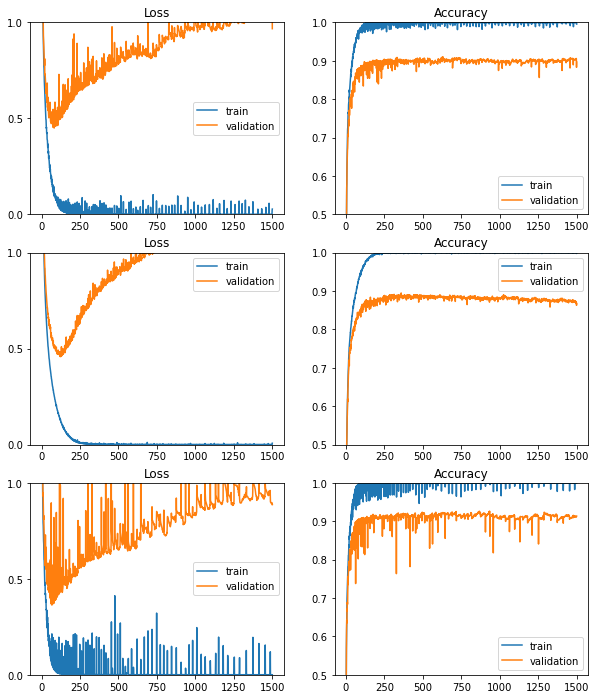

In [22]:
plot_models_history(models_history, min_loss=0, max_loss = 1, step_loss=0.5, min_eval_score=0.5, max_eval_score=1, step_eval_score=0.1 )

A model which is overted to data was obtained. Lets try to add some reguralization

In [23]:
K.utils

<module 'keras.utils' from '/home/pficardoso/anaconda3/envs/francois/lib/python3.6/site-packages/keras/utils/__init__.py'>

## Regularization - dropout

Overfit was achieved. Lets add some dropout.

In [24]:
my_models = list()

droupout_value = 0.25
my_models.append(K.models.Sequential())
my_models[0].add(K.layers.Dense(128, activation='relu', input_shape=(final_data.shape[1],)))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(64, activation='relu',))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(64, activation='relu'))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(32, activation='relu'))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(labels.shape[1], activation='softmax'))

my_models.append(K.models.Sequential())
my_models[1].add(K.layers.Dense(64, activation='relu', input_shape=(final_data.shape[1],)))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(64, activation='relu'))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(32, activation='relu'))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(labels.shape[1], activation='softmax'))


my_models.append(K.models.Sequential())
my_models[2].add(K.layers.Dense(256, activation='relu', input_shape=(final_data.shape[1],)))
my_models[2].add(K.layers.Dropout(droupout_value))
my_models[2].add(K.layers.Dense(128, activation='relu'))
my_models[2].add(K.layers.Dropout(droupout_value))
my_models[2].add(K.layers.Dense(64, activation='relu'))
my_models[2].add(K.layers.Dropout(droupout_value))
my_models[2].add(K.layers.Dense(64, activation='relu'))
my_models[2].add(K.layers.Dropout(droupout_value))
my_models[2].add(K.layers.Dense(32, activation='relu'))
my_models[2].add(K.layers.Dropout(droupout_value))
my_models[2].add(K.layers.Dense(labels.shape[1], activation='softmax'))

models_history = list()
for model in my_models:
    print(model)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    
    models_history.append(model.fit(x_train, 
                                    y_train, 
                                    batch_size=512, 
                                    epochs = 1500,
                                    validation_data=(x_val, y_val)))

Train on 3261 samples, validate on 1087 samples
Epoch 1/1500
3261/3261 [==============================] - 0s - loss: 2.2706 - acc: 0.1319 - val_loss: 2.1907 - val_acc: 0.2484
Epoch 2/1500
3261/3261 [==============================] - 0s - loss: 2.1723 - acc: 0.2153 - val_loss: 2.0710 - val_acc: 0.3073
Epoch 3/1500
3261/3261 [==============================] - 0s - loss: 2.0730 - acc: 0.2745 - val_loss: 1.9424 - val_acc: 0.3588
Epoch 4/1500
3261/3261 [==============================] - 0s - loss: 1.9880 - acc: 0.3073 - val_loss: 1.8307 - val_acc: 0.3983
Epoch 5/1500
3261/3261 [==============================] - 0s - loss: 1.9154 - acc: 0.3275 - val_loss: 1.7462 - val_acc: 0.4195
Epoch 6/1500
3261/3261 [==============================] - 0s - loss: 1.8498 - acc: 0.3551 - val_loss: 1.6711 - val_acc: 0.4342
Epoch 7/1500
3261/3261 [==============================] - 0s - loss: 1.8022 - acc: 0.3790 - val_loss: 1.6225 - val_acc: 0.4526
Epoch 8/1500
3261/3261 [==============================] - 0s - 

3261/3261 [==============================] - 0s - loss: 0.8730 - acc: 0.7130 - val_loss: 0.6981 - val_acc: 0.7774
Epoch 65/1500
3261/3261 [==============================] - 0s - loss: 0.8568 - acc: 0.7252 - val_loss: 0.6895 - val_acc: 0.7893
Epoch 66/1500
3261/3261 [==============================] - 0s - loss: 0.8411 - acc: 0.7277 - val_loss: 0.6761 - val_acc: 0.7902
Epoch 67/1500
3261/3261 [==============================] - 0s - loss: 0.8500 - acc: 0.7234 - val_loss: 0.6777 - val_acc: 0.7856
Epoch 68/1500
3261/3261 [==============================] - 0s - loss: 0.8281 - acc: 0.7360 - val_loss: 0.6666 - val_acc: 0.7884
Epoch 69/1500
3261/3261 [==============================] - 0s - loss: 0.8225 - acc: 0.7314 - val_loss: 0.6688 - val_acc: 0.7912
Epoch 70/1500
3261/3261 [==============================] - 0s - loss: 0.8267 - acc: 0.7311 - val_loss: 0.6549 - val_acc: 0.7967
Epoch 71/1500
3261/3261 [==============================] - 0s - loss: 0.8067 - acc: 0.7397 - val_loss: 0.6596 - val_ac

3261/3261 [==============================] - 0s - loss: 0.5923 - acc: 0.8105 - val_loss: 0.4841 - val_acc: 0.8427
Epoch 128/1500
3261/3261 [==============================] - 0s - loss: 0.5768 - acc: 0.8071 - val_loss: 0.4862 - val_acc: 0.8500
Epoch 129/1500
3261/3261 [==============================] - 0s - loss: 0.5839 - acc: 0.8172 - val_loss: 0.4900 - val_acc: 0.8454
Epoch 130/1500
3261/3261 [==============================] - 0s - loss: 0.5788 - acc: 0.8148 - val_loss: 0.4932 - val_acc: 0.8473
Epoch 131/1500
3261/3261 [==============================] - 0s - loss: 0.5703 - acc: 0.8163 - val_loss: 0.4868 - val_acc: 0.8454
Epoch 132/1500
3261/3261 [==============================] - 0s - loss: 0.5842 - acc: 0.8096 - val_loss: 0.4732 - val_acc: 0.8482
Epoch 133/1500
3261/3261 [==============================] - 0s - loss: 0.5793 - acc: 0.8166 - val_loss: 0.4689 - val_acc: 0.8473
Epoch 134/1500
3261/3261 [==============================] - 0s - loss: 0.5722 - acc: 0.8203 - val_loss: 0.4710 -

3261/3261 [==============================] - 0s - loss: 0.4607 - acc: 0.8669 - val_loss: 0.3946 - val_acc: 0.8850
Epoch 191/1500
3261/3261 [==============================] - 0s - loss: 0.4591 - acc: 0.8556 - val_loss: 0.3993 - val_acc: 0.8776
Epoch 192/1500
3261/3261 [==============================] - 0s - loss: 0.4187 - acc: 0.8666 - val_loss: 0.3996 - val_acc: 0.8841
Epoch 193/1500
3261/3261 [==============================] - 0s - loss: 0.4600 - acc: 0.8568 - val_loss: 0.3976 - val_acc: 0.8813
Epoch 194/1500
3261/3261 [==============================] - 0s - loss: 0.4296 - acc: 0.8623 - val_loss: 0.3875 - val_acc: 0.8905
Epoch 195/1500
3261/3261 [==============================] - 0s - loss: 0.4379 - acc: 0.8666 - val_loss: 0.4019 - val_acc: 0.8804
Epoch 196/1500
3261/3261 [==============================] - 0s - loss: 0.4346 - acc: 0.8663 - val_loss: 0.3914 - val_acc: 0.8822
Epoch 197/1500
3261/3261 [==============================] - 0s - loss: 0.4396 - acc: 0.8632 - val_loss: 0.3889 -

3261/3261 [==============================] - 0s - loss: 0.3841 - acc: 0.8761 - val_loss: 0.3476 - val_acc: 0.8988
Epoch 254/1500
3261/3261 [==============================] - 0s - loss: 0.3829 - acc: 0.8767 - val_loss: 0.3496 - val_acc: 0.8924
Epoch 255/1500
3261/3261 [==============================] - 0s - loss: 0.3639 - acc: 0.8899 - val_loss: 0.3539 - val_acc: 0.8997
Epoch 256/1500
3261/3261 [==============================] - 0s - loss: 0.3317 - acc: 0.8954 - val_loss: 0.3578 - val_acc: 0.8988
Epoch 257/1500
3261/3261 [==============================] - 0s - loss: 0.3802 - acc: 0.8884 - val_loss: 0.3481 - val_acc: 0.8960
Epoch 258/1500
3261/3261 [==============================] - 0s - loss: 0.3848 - acc: 0.8801 - val_loss: 0.3517 - val_acc: 0.8988
Epoch 259/1500
3261/3261 [==============================] - 0s - loss: 0.3658 - acc: 0.8859 - val_loss: 0.3478 - val_acc: 0.9043
Epoch 260/1500
3261/3261 [==============================] - 0s - loss: 0.3476 - acc: 0.8936 - val_loss: 0.3487 -

3261/3261 [==============================] - 0s - loss: 0.3113 - acc: 0.9022 - val_loss: 0.3277 - val_acc: 0.9098
Epoch 317/1500
3261/3261 [==============================] - 0s - loss: 0.3128 - acc: 0.9071 - val_loss: 0.3213 - val_acc: 0.9098
Epoch 318/1500
3261/3261 [==============================] - 0s - loss: 0.2999 - acc: 0.9102 - val_loss: 0.3330 - val_acc: 0.9071
Epoch 319/1500
3261/3261 [==============================] - 0s - loss: 0.3114 - acc: 0.9006 - val_loss: 0.3198 - val_acc: 0.9108
Epoch 320/1500
3261/3261 [==============================] - 0s - loss: 0.3139 - acc: 0.9105 - val_loss: 0.3153 - val_acc: 0.9126
Epoch 321/1500
3261/3261 [==============================] - 0s - loss: 0.3231 - acc: 0.9049 - val_loss: 0.3157 - val_acc: 0.9098
Epoch 322/1500
3261/3261 [==============================] - 0s - loss: 0.3162 - acc: 0.9049 - val_loss: 0.3221 - val_acc: 0.9098
Epoch 323/1500
3261/3261 [==============================] - 0s - loss: 0.3182 - acc: 0.8991 - val_loss: 0.3190 -

3261/3261 [==============================] - 0s - loss: 0.2849 - acc: 0.9141 - val_loss: 0.3079 - val_acc: 0.9172
Epoch 380/1500
3261/3261 [==============================] - 0s - loss: 0.2611 - acc: 0.9203 - val_loss: 0.3153 - val_acc: 0.9144
Epoch 381/1500
3261/3261 [==============================] - 0s - loss: 0.2883 - acc: 0.9111 - val_loss: 0.3148 - val_acc: 0.9163
Epoch 382/1500
3261/3261 [==============================] - 0s - loss: 0.2754 - acc: 0.9135 - val_loss: 0.3186 - val_acc: 0.9190
Epoch 383/1500
3261/3261 [==============================] - 0s - loss: 0.2864 - acc: 0.9138 - val_loss: 0.3144 - val_acc: 0.9172
Epoch 384/1500
3261/3261 [==============================] - 0s - loss: 0.2806 - acc: 0.9157 - val_loss: 0.3123 - val_acc: 0.9172
Epoch 385/1500
3261/3261 [==============================] - 0s - loss: 0.2705 - acc: 0.9206 - val_loss: 0.3169 - val_acc: 0.9172
Epoch 386/1500
3261/3261 [==============================] - 0s - loss: 0.2801 - acc: 0.9181 - val_loss: 0.3133 -

3261/3261 [==============================] - 0s - loss: 0.2500 - acc: 0.9233 - val_loss: 0.3057 - val_acc: 0.9227
Epoch 443/1500
3261/3261 [==============================] - 0s - loss: 0.2255 - acc: 0.9292 - val_loss: 0.3041 - val_acc: 0.9218
Epoch 444/1500
3261/3261 [==============================] - 0s - loss: 0.2549 - acc: 0.9236 - val_loss: 0.3014 - val_acc: 0.9190
Epoch 445/1500
3261/3261 [==============================] - 0s - loss: 0.2438 - acc: 0.9255 - val_loss: 0.3047 - val_acc: 0.9172
Epoch 446/1500
3261/3261 [==============================] - 0s - loss: 0.2389 - acc: 0.9279 - val_loss: 0.3086 - val_acc: 0.9154
Epoch 447/1500
3261/3261 [==============================] - 0s - loss: 0.2356 - acc: 0.9264 - val_loss: 0.3143 - val_acc: 0.9200
Epoch 448/1500
3261/3261 [==============================] - 0s - loss: 0.2223 - acc: 0.9316 - val_loss: 0.3069 - val_acc: 0.9218
Epoch 449/1500
3261/3261 [==============================] - 0s - loss: 0.2656 - acc: 0.9243 - val_loss: 0.3046 -

3261/3261 [==============================] - 0s - loss: 0.2089 - acc: 0.9328 - val_loss: 0.3182 - val_acc: 0.9200
Epoch 506/1500
3261/3261 [==============================] - 0s - loss: 0.2411 - acc: 0.9319 - val_loss: 0.3214 - val_acc: 0.9144
Epoch 507/1500
3261/3261 [==============================] - 0s - loss: 0.2276 - acc: 0.9371 - val_loss: 0.3136 - val_acc: 0.9200
Epoch 508/1500
3261/3261 [==============================] - 0s - loss: 0.2136 - acc: 0.9362 - val_loss: 0.3080 - val_acc: 0.9227
Epoch 509/1500
3261/3261 [==============================] - 0s - loss: 0.2129 - acc: 0.9408 - val_loss: 0.3072 - val_acc: 0.9246
Epoch 510/1500
3261/3261 [==============================] - 0s - loss: 0.2154 - acc: 0.9319 - val_loss: 0.3116 - val_acc: 0.9236
Epoch 511/1500
3261/3261 [==============================] - 0s - loss: 0.2484 - acc: 0.9218 - val_loss: 0.3077 - val_acc: 0.9236
Epoch 512/1500
3261/3261 [==============================] - 0s - loss: 0.2289 - acc: 0.9325 - val_loss: 0.3067 -

3261/3261 [==============================] - 0s - loss: 0.2073 - acc: 0.9393 - val_loss: 0.3044 - val_acc: 0.9273
Epoch 569/1500
3261/3261 [==============================] - 0s - loss: 0.2127 - acc: 0.9313 - val_loss: 0.3073 - val_acc: 0.9236
Epoch 570/1500
3261/3261 [==============================] - 0s - loss: 0.2118 - acc: 0.9387 - val_loss: 0.3058 - val_acc: 0.9264
Epoch 571/1500
3261/3261 [==============================] - 0s - loss: 0.2069 - acc: 0.9476 - val_loss: 0.3074 - val_acc: 0.9264
Epoch 572/1500
3261/3261 [==============================] - 0s - loss: 0.2076 - acc: 0.9393 - val_loss: 0.3090 - val_acc: 0.9246
Epoch 573/1500
3261/3261 [==============================] - 0s - loss: 0.2007 - acc: 0.9381 - val_loss: 0.3067 - val_acc: 0.9236
Epoch 574/1500
3261/3261 [==============================] - 0s - loss: 0.1979 - acc: 0.9396 - val_loss: 0.3036 - val_acc: 0.9273
Epoch 575/1500
3261/3261 [==============================] - 0s - loss: 0.2182 - acc: 0.9387 - val_loss: 0.3039 -

3261/3261 [==============================] - 0s - loss: 0.2074 - acc: 0.9417 - val_loss: 0.3204 - val_acc: 0.9246
Epoch 632/1500
3261/3261 [==============================] - 0s - loss: 0.1975 - acc: 0.9408 - val_loss: 0.3253 - val_acc: 0.9227
Epoch 633/1500
3261/3261 [==============================] - 0s - loss: 0.1994 - acc: 0.9396 - val_loss: 0.3180 - val_acc: 0.9282
Epoch 634/1500
3261/3261 [==============================] - 0s - loss: 0.2153 - acc: 0.9390 - val_loss: 0.3230 - val_acc: 0.9273
Epoch 635/1500
3261/3261 [==============================] - 0s - loss: 0.1503 - acc: 0.9543 - val_loss: 0.3237 - val_acc: 0.9227
Epoch 636/1500
3261/3261 [==============================] - 0s - loss: 0.1883 - acc: 0.9463 - val_loss: 0.3262 - val_acc: 0.9236
Epoch 637/1500
3261/3261 [==============================] - 0s - loss: 0.1942 - acc: 0.9411 - val_loss: 0.3314 - val_acc: 0.9227
Epoch 638/1500
3261/3261 [==============================] - 0s - loss: 0.1994 - acc: 0.9423 - val_loss: 0.3331 -

3261/3261 [==============================] - 0s - loss: 0.1878 - acc: 0.9457 - val_loss: 0.3090 - val_acc: 0.9227
Epoch 695/1500
3261/3261 [==============================] - 0s - loss: 0.1758 - acc: 0.9451 - val_loss: 0.3091 - val_acc: 0.9282
Epoch 696/1500
3261/3261 [==============================] - 0s - loss: 0.1927 - acc: 0.9460 - val_loss: 0.3081 - val_acc: 0.9236
Epoch 697/1500
3261/3261 [==============================] - 0s - loss: 0.1783 - acc: 0.9491 - val_loss: 0.3075 - val_acc: 0.9218
Epoch 698/1500
3261/3261 [==============================] - 0s - loss: 0.1714 - acc: 0.9509 - val_loss: 0.3037 - val_acc: 0.9236
Epoch 699/1500
3261/3261 [==============================] - 0s - loss: 0.1768 - acc: 0.9479 - val_loss: 0.3032 - val_acc: 0.9218
Epoch 700/1500
3261/3261 [==============================] - 0s - loss: 0.1902 - acc: 0.9411 - val_loss: 0.3005 - val_acc: 0.9236
Epoch 701/1500
3261/3261 [==============================] - 0s - loss: 0.2032 - acc: 0.9402 - val_loss: 0.3053 -

3261/3261 [==============================] - 0s - loss: 0.1731 - acc: 0.9482 - val_loss: 0.3162 - val_acc: 0.9227
Epoch 758/1500
3261/3261 [==============================] - 0s - loss: 0.1655 - acc: 0.9568 - val_loss: 0.3109 - val_acc: 0.9255
Epoch 759/1500
3261/3261 [==============================] - 0s - loss: 0.1859 - acc: 0.9433 - val_loss: 0.3156 - val_acc: 0.9255
Epoch 760/1500
3261/3261 [==============================] - 0s - loss: 0.1615 - acc: 0.9534 - val_loss: 0.3226 - val_acc: 0.9218
Epoch 761/1500
3261/3261 [==============================] - 0s - loss: 0.2021 - acc: 0.9408 - val_loss: 0.3130 - val_acc: 0.9255
Epoch 762/1500
3261/3261 [==============================] - 0s - loss: 0.1667 - acc: 0.9494 - val_loss: 0.3194 - val_acc: 0.9200
Epoch 763/1500
3261/3261 [==============================] - 0s - loss: 0.1537 - acc: 0.9586 - val_loss: 0.3138 - val_acc: 0.9255
Epoch 764/1500
3261/3261 [==============================] - 0s - loss: 0.1670 - acc: 0.9519 - val_loss: 0.3210 -

3261/3261 [==============================] - 0s - loss: 0.1638 - acc: 0.9494 - val_loss: 0.3313 - val_acc: 0.9218
Epoch 821/1500
3261/3261 [==============================] - 0s - loss: 0.1767 - acc: 0.9420 - val_loss: 0.3321 - val_acc: 0.9218
Epoch 822/1500
3261/3261 [==============================] - 0s - loss: 0.1761 - acc: 0.9488 - val_loss: 0.3256 - val_acc: 0.9163
Epoch 823/1500
3261/3261 [==============================] - 0s - loss: 0.1636 - acc: 0.9519 - val_loss: 0.3304 - val_acc: 0.9190
Epoch 824/1500
3261/3261 [==============================] - 0s - loss: 0.1506 - acc: 0.9561 - val_loss: 0.3478 - val_acc: 0.9236
Epoch 825/1500
3261/3261 [==============================] - 0s - loss: 0.1787 - acc: 0.9454 - val_loss: 0.3373 - val_acc: 0.9200
Epoch 826/1500
3261/3261 [==============================] - 0s - loss: 0.1700 - acc: 0.9522 - val_loss: 0.3355 - val_acc: 0.9218
Epoch 827/1500
3261/3261 [==============================] - 0s - loss: 0.1647 - acc: 0.9525 - val_loss: 0.3329 -

3261/3261 [==============================] - 0s - loss: 0.1813 - acc: 0.9466 - val_loss: 0.3311 - val_acc: 0.9255
Epoch 884/1500
3261/3261 [==============================] - 0s - loss: 0.1642 - acc: 0.9528 - val_loss: 0.3314 - val_acc: 0.9181
Epoch 885/1500
3261/3261 [==============================] - 0s - loss: 0.1568 - acc: 0.9540 - val_loss: 0.3320 - val_acc: 0.9218
Epoch 886/1500
3261/3261 [==============================] - 0s - loss: 0.1599 - acc: 0.9512 - val_loss: 0.3352 - val_acc: 0.9218
Epoch 887/1500
3261/3261 [==============================] - 0s - loss: 0.1591 - acc: 0.9519 - val_loss: 0.3305 - val_acc: 0.9200
Epoch 888/1500
3261/3261 [==============================] - 0s - loss: 0.1703 - acc: 0.9512 - val_loss: 0.3301 - val_acc: 0.9181
Epoch 889/1500
3261/3261 [==============================] - 0s - loss: 0.1700 - acc: 0.9528 - val_loss: 0.3252 - val_acc: 0.9154
Epoch 890/1500
3261/3261 [==============================] - 0s - loss: 0.1869 - acc: 0.9473 - val_loss: 0.3265 -

3261/3261 [==============================] - 0s - loss: 0.1603 - acc: 0.9558 - val_loss: 0.3413 - val_acc: 0.9227
Epoch 947/1500
3261/3261 [==============================] - 0s - loss: 0.1643 - acc: 0.9565 - val_loss: 0.3405 - val_acc: 0.9200
Epoch 948/1500
3261/3261 [==============================] - 0s - loss: 0.1705 - acc: 0.9534 - val_loss: 0.3449 - val_acc: 0.9190
Epoch 949/1500
3261/3261 [==============================] - 0s - loss: 0.1486 - acc: 0.9595 - val_loss: 0.3496 - val_acc: 0.9172
Epoch 950/1500
3261/3261 [==============================] - 0s - loss: 0.1510 - acc: 0.9586 - val_loss: 0.3446 - val_acc: 0.9200
Epoch 951/1500
3261/3261 [==============================] - 0s - loss: 0.1399 - acc: 0.9598 - val_loss: 0.3472 - val_acc: 0.9236
Epoch 952/1500
3261/3261 [==============================] - 0s - loss: 0.1622 - acc: 0.9528 - val_loss: 0.3487 - val_acc: 0.9236
Epoch 953/1500
3261/3261 [==============================] - 0s - loss: 0.1470 - acc: 0.9561 - val_loss: 0.3470 -

3261/3261 [==============================] - 0s - loss: 0.1456 - acc: 0.9571 - val_loss: 0.3363 - val_acc: 0.9227
Epoch 1010/1500
3261/3261 [==============================] - 0s - loss: 0.1478 - acc: 0.9614 - val_loss: 0.3289 - val_acc: 0.9264
Epoch 1011/1500
3261/3261 [==============================] - 0s - loss: 0.1561 - acc: 0.9549 - val_loss: 0.3354 - val_acc: 0.9236
Epoch 1012/1500
3261/3261 [==============================] - 0s - loss: 0.1702 - acc: 0.9515 - val_loss: 0.3410 - val_acc: 0.9227
Epoch 1013/1500
3261/3261 [==============================] - 0s - loss: 0.1638 - acc: 0.9522 - val_loss: 0.3406 - val_acc: 0.9246
Epoch 1014/1500
3261/3261 [==============================] - 0s - loss: 0.1501 - acc: 0.9592 - val_loss: 0.3437 - val_acc: 0.9227
Epoch 1015/1500
3261/3261 [==============================] - 0s - loss: 0.1625 - acc: 0.9540 - val_loss: 0.3433 - val_acc: 0.9209
Epoch 1016/1500
3261/3261 [==============================] - 0s - loss: 0.1740 - acc: 0.9485 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.1339 - acc: 0.9623 - val_loss: 0.3287 - val_acc: 0.9218
Epoch 1072/1500
3261/3261 [==============================] - 0s - loss: 0.1576 - acc: 0.9515 - val_loss: 0.3288 - val_acc: 0.9218
Epoch 1073/1500
3261/3261 [==============================] - 0s - loss: 0.1437 - acc: 0.9586 - val_loss: 0.3259 - val_acc: 0.9218
Epoch 1074/1500
3261/3261 [==============================] - 0s - loss: 0.1337 - acc: 0.9592 - val_loss: 0.3281 - val_acc: 0.9246
Epoch 1075/1500
3261/3261 [==============================] - 0s - loss: 0.1807 - acc: 0.9460 - val_loss: 0.3231 - val_acc: 0.9209
Epoch 1076/1500
3261/3261 [==============================] - 0s - loss: 0.1335 - acc: 0.9626 - val_loss: 0.3230 - val_acc: 0.9209
Epoch 1077/1500
3261/3261 [==============================] - 0s - loss: 0.1506 - acc: 0.9592 - val_loss: 0.3178 - val_acc: 0.9246
Epoch 1078/1500
3261/3261 [==============================] - 0s - loss: 0.1582 - acc: 0.9503 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.1498 - acc: 0.9617 - val_loss: 0.3325 - val_acc: 0.9255
Epoch 1135/1500
3261/3261 [==============================] - 0s - loss: 0.1416 - acc: 0.9617 - val_loss: 0.3335 - val_acc: 0.9264
Epoch 1136/1500
3261/3261 [==============================] - 0s - loss: 0.1480 - acc: 0.9555 - val_loss: 0.3293 - val_acc: 0.9218
Epoch 1137/1500
3261/3261 [==============================] - 0s - loss: 0.1483 - acc: 0.9598 - val_loss: 0.3379 - val_acc: 0.9227
Epoch 1138/1500
3261/3261 [==============================] - 0s - loss: 0.1440 - acc: 0.9604 - val_loss: 0.3447 - val_acc: 0.9190
Epoch 1139/1500
3261/3261 [==============================] - 0s - loss: 0.1561 - acc: 0.9522 - val_loss: 0.3413 - val_acc: 0.9264
Epoch 1140/1500
3261/3261 [==============================] - 0s - loss: 0.1361 - acc: 0.9565 - val_loss: 0.3366 - val_acc: 0.9246
Epoch 1141/1500
3261/3261 [==============================] - 0s - loss: 0.1722 - acc: 0.9531 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.1483 - acc: 0.9534 - val_loss: 0.3486 - val_acc: 0.9181
Epoch 1198/1500
3261/3261 [==============================] - 0s - loss: 0.1535 - acc: 0.9583 - val_loss: 0.3334 - val_acc: 0.9200
Epoch 1199/1500
3261/3261 [==============================] - 0s - loss: 0.1556 - acc: 0.9586 - val_loss: 0.3340 - val_acc: 0.9236
Epoch 1200/1500
3261/3261 [==============================] - 0s - loss: 0.1554 - acc: 0.9589 - val_loss: 0.3385 - val_acc: 0.9190
Epoch 1201/1500
3261/3261 [==============================] - 0s - loss: 0.1436 - acc: 0.9614 - val_loss: 0.3419 - val_acc: 0.9218
Epoch 1202/1500
3261/3261 [==============================] - 0s - loss: 0.1440 - acc: 0.9592 - val_loss: 0.3407 - val_acc: 0.9227
Epoch 1203/1500
3261/3261 [==============================] - 0s - loss: 0.1241 - acc: 0.9660 - val_loss: 0.3395 - val_acc: 0.9209
Epoch 1204/1500
3261/3261 [==============================] - 0s - loss: 0.1251 - acc: 0.9647 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.1322 - acc: 0.9641 - val_loss: 0.3320 - val_acc: 0.9292
Epoch 1261/1500
3261/3261 [==============================] - 0s - loss: 0.1598 - acc: 0.9525 - val_loss: 0.3353 - val_acc: 0.9301
Epoch 1262/1500
3261/3261 [==============================] - 0s - loss: 0.1293 - acc: 0.9650 - val_loss: 0.3345 - val_acc: 0.9310
Epoch 1263/1500
3261/3261 [==============================] - 0s - loss: 0.1185 - acc: 0.9669 - val_loss: 0.3386 - val_acc: 0.9301
Epoch 1264/1500
3261/3261 [==============================] - 0s - loss: 0.1614 - acc: 0.9607 - val_loss: 0.3405 - val_acc: 0.9264
Epoch 1265/1500
3261/3261 [==============================] - 0s - loss: 0.1639 - acc: 0.9528 - val_loss: 0.3455 - val_acc: 0.9282
Epoch 1266/1500
3261/3261 [==============================] - 0s - loss: 0.1390 - acc: 0.9586 - val_loss: 0.3437 - val_acc: 0.9218
Epoch 1267/1500
3261/3261 [==============================] - 0s - loss: 0.1399 - acc: 0.9620 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.1365 - acc: 0.9632 - val_loss: 0.3594 - val_acc: 0.9181
Epoch 1324/1500
3261/3261 [==============================] - 0s - loss: 0.1274 - acc: 0.9577 - val_loss: 0.3615 - val_acc: 0.9227
Epoch 1325/1500
3261/3261 [==============================] - 0s - loss: 0.1509 - acc: 0.9571 - val_loss: 0.3477 - val_acc: 0.9227
Epoch 1326/1500
3261/3261 [==============================] - 0s - loss: 0.1236 - acc: 0.9647 - val_loss: 0.3441 - val_acc: 0.9236
Epoch 1327/1500
3261/3261 [==============================] - 0s - loss: 0.1505 - acc: 0.9598 - val_loss: 0.3507 - val_acc: 0.9255
Epoch 1328/1500
3261/3261 [==============================] - 0s - loss: 0.1236 - acc: 0.9657 - val_loss: 0.3481 - val_acc: 0.9236
Epoch 1329/1500
3261/3261 [==============================] - 0s - loss: 0.1233 - acc: 0.9666 - val_loss: 0.3550 - val_acc: 0.9246
Epoch 1330/1500
3261/3261 [==============================] - 0s - loss: 0.1498 - acc: 0.9583 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.1339 - acc: 0.9623 - val_loss: 0.3357 - val_acc: 0.9264
Epoch 1387/1500
3261/3261 [==============================] - 0s - loss: 0.1380 - acc: 0.9638 - val_loss: 0.3331 - val_acc: 0.9264
Epoch 1388/1500
3261/3261 [==============================] - 0s - loss: 0.1447 - acc: 0.9598 - val_loss: 0.3357 - val_acc: 0.9292
Epoch 1389/1500
3261/3261 [==============================] - 0s - loss: 0.1323 - acc: 0.9617 - val_loss: 0.3335 - val_acc: 0.9292
Epoch 1390/1500
3261/3261 [==============================] - 0s - loss: 0.1206 - acc: 0.9644 - val_loss: 0.3417 - val_acc: 0.9264
Epoch 1391/1500
3261/3261 [==============================] - 0s - loss: 0.1441 - acc: 0.9607 - val_loss: 0.3404 - val_acc: 0.9282
Epoch 1392/1500
3261/3261 [==============================] - 0s - loss: 0.1401 - acc: 0.9598 - val_loss: 0.3424 - val_acc: 0.9301
Epoch 1393/1500
3261/3261 [==============================] - 0s - loss: 0.1176 - acc: 0.9650 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.1252 - acc: 0.9638 - val_loss: 0.3509 - val_acc: 0.9209
Epoch 1450/1500
3261/3261 [==============================] - 0s - loss: 0.1260 - acc: 0.9595 - val_loss: 0.3365 - val_acc: 0.9292
Epoch 1451/1500
3261/3261 [==============================] - 0s - loss: 0.1430 - acc: 0.9598 - val_loss: 0.3359 - val_acc: 0.9255
Epoch 1452/1500
3261/3261 [==============================] - 0s - loss: 0.1334 - acc: 0.9681 - val_loss: 0.3342 - val_acc: 0.9301
Epoch 1453/1500
3261/3261 [==============================] - 0s - loss: 0.1296 - acc: 0.9647 - val_loss: 0.3403 - val_acc: 0.9273
Epoch 1454/1500
3261/3261 [==============================] - 0s - loss: 0.1267 - acc: 0.9629 - val_loss: 0.3459 - val_acc: 0.9319
Epoch 1455/1500
3261/3261 [==============================] - 0s - loss: 0.1112 - acc: 0.9672 - val_loss: 0.3451 - val_acc: 0.9328
Epoch 1456/1500
3261/3261 [==============================] - 0s - loss: 0.1382 - acc: 0.9626 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 1.7367 - acc: 0.4284 - val_loss: 1.5910 - val_acc: 0.4931
Epoch 12/1500
3261/3261 [==============================] - 0s - loss: 1.7114 - acc: 0.4315 - val_loss: 1.5512 - val_acc: 0.5078
Epoch 13/1500
3261/3261 [==============================] - 0s - loss: 1.6783 - acc: 0.4299 - val_loss: 1.5082 - val_acc: 0.5225
Epoch 14/1500
3261/3261 [==============================] - 0s - loss: 1.6582 - acc: 0.4419 - val_loss: 1.4743 - val_acc: 0.5373
Epoch 15/1500
3261/3261 [==============================] - 0s - loss: 1.6170 - acc: 0.4664 - val_loss: 1.4442 - val_acc: 0.5465
Epoch 16/1500
3261/3261 [==============================] - 0s - loss: 1.6084 - acc: 0.4652 - val_loss: 1.4116 - val_acc: 0.5529
Epoch 17/1500
3261/3261 [==============================] - 0s - loss: 1.5859 - acc: 0.4787 - val_loss: 1.3812 - val_acc: 0.5676
Epoch 18/1500
3261/3261 [==============================] - 0s - loss: 1.5391 - acc: 0.4864 - val_loss: 1.3512 - val_ac

3261/3261 [==============================] - 0s - loss: 0.9947 - acc: 0.6703 - val_loss: 0.7728 - val_acc: 0.7599
Epoch 76/1500
3261/3261 [==============================] - 0s - loss: 0.9873 - acc: 0.6667 - val_loss: 0.7695 - val_acc: 0.7617
Epoch 77/1500
3261/3261 [==============================] - 0s - loss: 0.9961 - acc: 0.6716 - val_loss: 0.7717 - val_acc: 0.7608
Epoch 78/1500
3261/3261 [==============================] - 0s - loss: 0.9678 - acc: 0.6869 - val_loss: 0.7632 - val_acc: 0.7636
Epoch 79/1500
3261/3261 [==============================] - 0s - loss: 0.9557 - acc: 0.6887 - val_loss: 0.7575 - val_acc: 0.7626
Epoch 80/1500
3261/3261 [==============================] - 0s - loss: 0.9654 - acc: 0.6792 - val_loss: 0.7577 - val_acc: 0.7700
Epoch 81/1500
3261/3261 [==============================] - 0s - loss: 0.9596 - acc: 0.6725 - val_loss: 0.7536 - val_acc: 0.7691
Epoch 82/1500
3261/3261 [==============================] - 0s - loss: 0.9457 - acc: 0.6897 - val_loss: 0.7490 - val_ac

3261/3261 [==============================] - 0s - loss: 0.7584 - acc: 0.7516 - val_loss: 0.6038 - val_acc: 0.8160
Epoch 139/1500
3261/3261 [==============================] - 0s - loss: 0.7995 - acc: 0.7363 - val_loss: 0.6022 - val_acc: 0.8151
Epoch 140/1500
3261/3261 [==============================] - 0s - loss: 0.7718 - acc: 0.7433 - val_loss: 0.6000 - val_acc: 0.8188
Epoch 141/1500
3261/3261 [==============================] - 0s - loss: 0.7899 - acc: 0.7403 - val_loss: 0.5999 - val_acc: 0.8188
Epoch 142/1500
3261/3261 [==============================] - 0s - loss: 0.7518 - acc: 0.7476 - val_loss: 0.5964 - val_acc: 0.8197
Epoch 143/1500
3261/3261 [==============================] - 0s - loss: 0.7682 - acc: 0.7406 - val_loss: 0.5964 - val_acc: 0.8215
Epoch 144/1500
3261/3261 [==============================] - 0s - loss: 0.7656 - acc: 0.7338 - val_loss: 0.5974 - val_acc: 0.8151
Epoch 145/1500
3261/3261 [==============================] - 0s - loss: 0.7564 - acc: 0.7482 - val_loss: 0.5922 -

3261/3261 [==============================] - 0s - loss: 0.6448 - acc: 0.7866 - val_loss: 0.5245 - val_acc: 0.8390
Epoch 202/1500
3261/3261 [==============================] - 0s - loss: 0.6840 - acc: 0.7728 - val_loss: 0.5242 - val_acc: 0.8436
Epoch 203/1500
3261/3261 [==============================] - 0s - loss: 0.6656 - acc: 0.7761 - val_loss: 0.5237 - val_acc: 0.8436
Epoch 204/1500
3261/3261 [==============================] - 0s - loss: 0.6383 - acc: 0.7915 - val_loss: 0.5230 - val_acc: 0.8436
Epoch 205/1500
3261/3261 [==============================] - 0s - loss: 0.6598 - acc: 0.7801 - val_loss: 0.5173 - val_acc: 0.8454
Epoch 206/1500
3261/3261 [==============================] - 0s - loss: 0.6721 - acc: 0.7746 - val_loss: 0.5208 - val_acc: 0.8436
Epoch 207/1500
3261/3261 [==============================] - 0s - loss: 0.6575 - acc: 0.7872 - val_loss: 0.5227 - val_acc: 0.8381
Epoch 208/1500
3261/3261 [==============================] - 0s - loss: 0.6511 - acc: 0.7881 - val_loss: 0.5151 -

3261/3261 [==============================] - 0s - loss: 0.5689 - acc: 0.8178 - val_loss: 0.4755 - val_acc: 0.8537
Epoch 265/1500
3261/3261 [==============================] - 0s - loss: 0.5984 - acc: 0.8001 - val_loss: 0.4712 - val_acc: 0.8500
Epoch 266/1500
3261/3261 [==============================] - 0s - loss: 0.5987 - acc: 0.8037 - val_loss: 0.4706 - val_acc: 0.8556
Epoch 267/1500
3261/3261 [==============================] - 0s - loss: 0.5895 - acc: 0.8031 - val_loss: 0.4744 - val_acc: 0.8519
Epoch 268/1500
3261/3261 [==============================] - 0s - loss: 0.5826 - acc: 0.8040 - val_loss: 0.4747 - val_acc: 0.8491
Epoch 269/1500
3261/3261 [==============================] - 0s - loss: 0.5955 - acc: 0.8053 - val_loss: 0.4693 - val_acc: 0.8528
Epoch 270/1500
3261/3261 [==============================] - 0s - loss: 0.5893 - acc: 0.8034 - val_loss: 0.4693 - val_acc: 0.8565
Epoch 271/1500
3261/3261 [==============================] - 0s - loss: 0.5838 - acc: 0.8028 - val_loss: 0.4702 -

3261/3261 [==============================] - 0s - loss: 0.5517 - acc: 0.8166 - val_loss: 0.4380 - val_acc: 0.8629
Epoch 328/1500
3261/3261 [==============================] - 0s - loss: 0.5452 - acc: 0.8234 - val_loss: 0.4405 - val_acc: 0.8629
Epoch 329/1500
3261/3261 [==============================] - 0s - loss: 0.5450 - acc: 0.8203 - val_loss: 0.4415 - val_acc: 0.8648
Epoch 330/1500
3261/3261 [==============================] - 0s - loss: 0.5326 - acc: 0.8353 - val_loss: 0.4407 - val_acc: 0.8666
Epoch 331/1500
3261/3261 [==============================] - 0s - loss: 0.5203 - acc: 0.8289 - val_loss: 0.4410 - val_acc: 0.8638
Epoch 332/1500
3261/3261 [==============================] - 0s - loss: 0.5383 - acc: 0.8182 - val_loss: 0.4389 - val_acc: 0.8657
Epoch 333/1500
3261/3261 [==============================] - 0s - loss: 0.5446 - acc: 0.8178 - val_loss: 0.4417 - val_acc: 0.8638
Epoch 334/1500
3261/3261 [==============================] - 0s - loss: 0.5298 - acc: 0.8249 - val_loss: 0.4459 -

3261/3261 [==============================] - 0s - loss: 0.5138 - acc: 0.8295 - val_loss: 0.4167 - val_acc: 0.8712
Epoch 391/1500
3261/3261 [==============================] - 0s - loss: 0.4910 - acc: 0.8430 - val_loss: 0.4167 - val_acc: 0.8694
Epoch 392/1500
3261/3261 [==============================] - 0s - loss: 0.4922 - acc: 0.8372 - val_loss: 0.4103 - val_acc: 0.8740
Epoch 393/1500
3261/3261 [==============================] - 0s - loss: 0.5038 - acc: 0.8347 - val_loss: 0.4154 - val_acc: 0.8730
Epoch 394/1500
3261/3261 [==============================] - 0s - loss: 0.5241 - acc: 0.8255 - val_loss: 0.4147 - val_acc: 0.8703
Epoch 395/1500
3261/3261 [==============================] - 0s - loss: 0.5147 - acc: 0.8320 - val_loss: 0.4098 - val_acc: 0.8703
Epoch 396/1500
3261/3261 [==============================] - 0s - loss: 0.5026 - acc: 0.8326 - val_loss: 0.4105 - val_acc: 0.8657
Epoch 397/1500
3261/3261 [==============================] - 0s - loss: 0.4915 - acc: 0.8408 - val_loss: 0.4114 -

3261/3261 [==============================] - 0s - loss: 0.4857 - acc: 0.8470 - val_loss: 0.3997 - val_acc: 0.8758
Epoch 454/1500
3261/3261 [==============================] - 0s - loss: 0.4762 - acc: 0.8445 - val_loss: 0.3976 - val_acc: 0.8776
Epoch 455/1500
3261/3261 [==============================] - 0s - loss: 0.4577 - acc: 0.8470 - val_loss: 0.4004 - val_acc: 0.8758
Epoch 456/1500
3261/3261 [==============================] - 0s - loss: 0.4949 - acc: 0.8350 - val_loss: 0.4007 - val_acc: 0.8721
Epoch 457/1500
3261/3261 [==============================] - 0s - loss: 0.4968 - acc: 0.8405 - val_loss: 0.3978 - val_acc: 0.8795
Epoch 458/1500
3261/3261 [==============================] - 0s - loss: 0.4641 - acc: 0.8525 - val_loss: 0.4008 - val_acc: 0.8776
Epoch 459/1500
3261/3261 [==============================] - 0s - loss: 0.4777 - acc: 0.8405 - val_loss: 0.3990 - val_acc: 0.8786
Epoch 460/1500
3261/3261 [==============================] - 0s - loss: 0.4691 - acc: 0.8488 - val_loss: 0.4005 -

3261/3261 [==============================] - 0s - loss: 0.4596 - acc: 0.8384 - val_loss: 0.3848 - val_acc: 0.8832
Epoch 517/1500
3261/3261 [==============================] - 0s - loss: 0.4462 - acc: 0.8488 - val_loss: 0.3822 - val_acc: 0.8850
Epoch 518/1500
3261/3261 [==============================] - 0s - loss: 0.4373 - acc: 0.8510 - val_loss: 0.3806 - val_acc: 0.8850
Epoch 519/1500
3261/3261 [==============================] - 0s - loss: 0.4253 - acc: 0.8589 - val_loss: 0.3812 - val_acc: 0.8887
Epoch 520/1500
3261/3261 [==============================] - 0s - loss: 0.4644 - acc: 0.8559 - val_loss: 0.3841 - val_acc: 0.8832
Epoch 521/1500
3261/3261 [==============================] - 0s - loss: 0.4868 - acc: 0.8461 - val_loss: 0.3790 - val_acc: 0.8850
Epoch 522/1500
3261/3261 [==============================] - 0s - loss: 0.4918 - acc: 0.8433 - val_loss: 0.3845 - val_acc: 0.8850
Epoch 523/1500
3261/3261 [==============================] - 0s - loss: 0.4536 - acc: 0.8473 - val_loss: 0.3848 -

3261/3261 [==============================] - 0s - loss: 0.4534 - acc: 0.8513 - val_loss: 0.3714 - val_acc: 0.8887
Epoch 580/1500
3261/3261 [==============================] - 0s - loss: 0.4413 - acc: 0.8534 - val_loss: 0.3733 - val_acc: 0.8832
Epoch 581/1500
3261/3261 [==============================] - 0s - loss: 0.4469 - acc: 0.8568 - val_loss: 0.3716 - val_acc: 0.8868
Epoch 582/1500
3261/3261 [==============================] - 0s - loss: 0.4173 - acc: 0.8648 - val_loss: 0.3730 - val_acc: 0.8868
Epoch 583/1500
3261/3261 [==============================] - 0s - loss: 0.4381 - acc: 0.8537 - val_loss: 0.3750 - val_acc: 0.8841
Epoch 584/1500
3261/3261 [==============================] - 0s - loss: 0.4346 - acc: 0.8614 - val_loss: 0.3729 - val_acc: 0.8878
Epoch 585/1500
3261/3261 [==============================] - 0s - loss: 0.4443 - acc: 0.8574 - val_loss: 0.3753 - val_acc: 0.8859
Epoch 586/1500
3261/3261 [==============================] - 0s - loss: 0.4370 - acc: 0.8605 - val_loss: 0.3746 -

3261/3261 [==============================] - 0s - loss: 0.4135 - acc: 0.8629 - val_loss: 0.3633 - val_acc: 0.8924
Epoch 643/1500
3261/3261 [==============================] - 0s - loss: 0.3840 - acc: 0.8629 - val_loss: 0.3671 - val_acc: 0.8914
Epoch 644/1500
3261/3261 [==============================] - 0s - loss: 0.4419 - acc: 0.8577 - val_loss: 0.3658 - val_acc: 0.8942
Epoch 645/1500
3261/3261 [==============================] - 0s - loss: 0.4269 - acc: 0.8666 - val_loss: 0.3665 - val_acc: 0.8933
Epoch 646/1500
3261/3261 [==============================] - 0s - loss: 0.4009 - acc: 0.8632 - val_loss: 0.3651 - val_acc: 0.8924
Epoch 647/1500
3261/3261 [==============================] - 0s - loss: 0.4070 - acc: 0.8620 - val_loss: 0.3607 - val_acc: 0.8924
Epoch 648/1500
3261/3261 [==============================] - 0s - loss: 0.4185 - acc: 0.8688 - val_loss: 0.3682 - val_acc: 0.8924
Epoch 649/1500
3261/3261 [==============================] - 0s - loss: 0.4259 - acc: 0.8638 - val_loss: 0.3645 -

3261/3261 [==============================] - 0s - loss: 0.3993 - acc: 0.8721 - val_loss: 0.3660 - val_acc: 0.8924
Epoch 706/1500
3261/3261 [==============================] - 0s - loss: 0.3831 - acc: 0.8746 - val_loss: 0.3661 - val_acc: 0.8942
Epoch 707/1500
3261/3261 [==============================] - 0s - loss: 0.3865 - acc: 0.8718 - val_loss: 0.3667 - val_acc: 0.8924
Epoch 708/1500
3261/3261 [==============================] - 0s - loss: 0.3887 - acc: 0.8746 - val_loss: 0.3669 - val_acc: 0.8924
Epoch 709/1500
3261/3261 [==============================] - 0s - loss: 0.3907 - acc: 0.8706 - val_loss: 0.3698 - val_acc: 0.8914
Epoch 710/1500
3261/3261 [==============================] - 0s - loss: 0.4120 - acc: 0.8703 - val_loss: 0.3662 - val_acc: 0.8960
Epoch 711/1500
3261/3261 [==============================] - 0s - loss: 0.3848 - acc: 0.8776 - val_loss: 0.3671 - val_acc: 0.8970
Epoch 712/1500
3261/3261 [==============================] - 0s - loss: 0.4281 - acc: 0.8617 - val_loss: 0.3678 -

3261/3261 [==============================] - 0s - loss: 0.3692 - acc: 0.8844 - val_loss: 0.3578 - val_acc: 0.9006
Epoch 769/1500
3261/3261 [==============================] - 0s - loss: 0.3572 - acc: 0.8819 - val_loss: 0.3586 - val_acc: 0.8970
Epoch 770/1500
3261/3261 [==============================] - 0s - loss: 0.3881 - acc: 0.8773 - val_loss: 0.3602 - val_acc: 0.8979
Epoch 771/1500
3261/3261 [==============================] - 0s - loss: 0.3776 - acc: 0.8734 - val_loss: 0.3560 - val_acc: 0.9006
Epoch 772/1500
3261/3261 [==============================] - 0s - loss: 0.4024 - acc: 0.8764 - val_loss: 0.3571 - val_acc: 0.9006
Epoch 773/1500
3261/3261 [==============================] - 0s - loss: 0.3911 - acc: 0.8712 - val_loss: 0.3605 - val_acc: 0.8970
Epoch 774/1500
3261/3261 [==============================] - 0s - loss: 0.4045 - acc: 0.8694 - val_loss: 0.3557 - val_acc: 0.9016
Epoch 775/1500
3261/3261 [==============================] - 0s - loss: 0.4161 - acc: 0.8721 - val_loss: 0.3582 -

3261/3261 [==============================] - 0s - loss: 0.4011 - acc: 0.8691 - val_loss: 0.3539 - val_acc: 0.8970
Epoch 832/1500
3261/3261 [==============================] - 0s - loss: 0.3812 - acc: 0.8761 - val_loss: 0.3496 - val_acc: 0.8970
Epoch 833/1500
3261/3261 [==============================] - 0s - loss: 0.3926 - acc: 0.8752 - val_loss: 0.3455 - val_acc: 0.9043
Epoch 834/1500
3261/3261 [==============================] - 0s - loss: 0.3790 - acc: 0.8826 - val_loss: 0.3479 - val_acc: 0.9043
Epoch 835/1500
3261/3261 [==============================] - 0s - loss: 0.3706 - acc: 0.8865 - val_loss: 0.3520 - val_acc: 0.8997
Epoch 836/1500
3261/3261 [==============================] - 0s - loss: 0.3803 - acc: 0.8749 - val_loss: 0.3511 - val_acc: 0.8988
Epoch 837/1500
3261/3261 [==============================] - 0s - loss: 0.3942 - acc: 0.8776 - val_loss: 0.3547 - val_acc: 0.8979
Epoch 838/1500
3261/3261 [==============================] - 0s - loss: 0.3660 - acc: 0.8875 - val_loss: 0.3500 -

3261/3261 [==============================] - 0s - loss: 0.3671 - acc: 0.8773 - val_loss: 0.3520 - val_acc: 0.8979
Epoch 895/1500
3261/3261 [==============================] - 0s - loss: 0.3716 - acc: 0.8847 - val_loss: 0.3518 - val_acc: 0.8979
Epoch 896/1500
3261/3261 [==============================] - 0s - loss: 0.3570 - acc: 0.8850 - val_loss: 0.3491 - val_acc: 0.9006
Epoch 897/1500
3261/3261 [==============================] - 0s - loss: 0.3669 - acc: 0.8764 - val_loss: 0.3546 - val_acc: 0.8970
Epoch 898/1500
3261/3261 [==============================] - 0s - loss: 0.3875 - acc: 0.8737 - val_loss: 0.3555 - val_acc: 0.8997
Epoch 899/1500
3261/3261 [==============================] - 0s - loss: 0.3766 - acc: 0.8810 - val_loss: 0.3568 - val_acc: 0.8942
Epoch 900/1500
3261/3261 [==============================] - 0s - loss: 0.3772 - acc: 0.8872 - val_loss: 0.3565 - val_acc: 0.8960
Epoch 901/1500
3261/3261 [==============================] - 0s - loss: 0.3808 - acc: 0.8804 - val_loss: 0.3580 -

3261/3261 [==============================] - 0s - loss: 0.3704 - acc: 0.8767 - val_loss: 0.3574 - val_acc: 0.8960
Epoch 958/1500
3261/3261 [==============================] - 0s - loss: 0.3449 - acc: 0.8878 - val_loss: 0.3533 - val_acc: 0.8951
Epoch 959/1500
3261/3261 [==============================] - 0s - loss: 0.3596 - acc: 0.8795 - val_loss: 0.3573 - val_acc: 0.8951
Epoch 960/1500
3261/3261 [==============================] - 0s - loss: 0.3580 - acc: 0.8868 - val_loss: 0.3577 - val_acc: 0.8942
Epoch 961/1500
3261/3261 [==============================] - 0s - loss: 0.3580 - acc: 0.8822 - val_loss: 0.3555 - val_acc: 0.9006
Epoch 962/1500
3261/3261 [==============================] - 0s - loss: 0.3907 - acc: 0.8691 - val_loss: 0.3609 - val_acc: 0.8942
Epoch 963/1500
3261/3261 [==============================] - 0s - loss: 0.3463 - acc: 0.8914 - val_loss: 0.3593 - val_acc: 0.8970
Epoch 964/1500
3261/3261 [==============================] - 0s - loss: 0.3666 - acc: 0.8832 - val_loss: 0.3593 -

3261/3261 [==============================] - 0s - loss: 0.3640 - acc: 0.8853 - val_loss: 0.3556 - val_acc: 0.8979
Epoch 1021/1500
3261/3261 [==============================] - 0s - loss: 0.3397 - acc: 0.8902 - val_loss: 0.3544 - val_acc: 0.9025
Epoch 1022/1500
3261/3261 [==============================] - 0s - loss: 0.3800 - acc: 0.8795 - val_loss: 0.3569 - val_acc: 0.9006
Epoch 1023/1500
3261/3261 [==============================] - 0s - loss: 0.3674 - acc: 0.8789 - val_loss: 0.3566 - val_acc: 0.9006
Epoch 1024/1500
3261/3261 [==============================] - 0s - loss: 0.3518 - acc: 0.8853 - val_loss: 0.3557 - val_acc: 0.8988
Epoch 1025/1500
3261/3261 [==============================] - 0s - loss: 0.3389 - acc: 0.8844 - val_loss: 0.3547 - val_acc: 0.8997
Epoch 1026/1500
3261/3261 [==============================] - 0s - loss: 0.3592 - acc: 0.8844 - val_loss: 0.3527 - val_acc: 0.8997
Epoch 1027/1500
3261/3261 [==============================] - 0s - loss: 0.3593 - acc: 0.8829 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.3370 - acc: 0.8921 - val_loss: 0.3609 - val_acc: 0.8997
Epoch 1084/1500
3261/3261 [==============================] - 0s - loss: 0.3562 - acc: 0.8835 - val_loss: 0.3561 - val_acc: 0.8988
Epoch 1085/1500
3261/3261 [==============================] - 0s - loss: 0.3271 - acc: 0.8878 - val_loss: 0.3546 - val_acc: 0.9016
Epoch 1086/1500
3261/3261 [==============================] - 0s - loss: 0.3528 - acc: 0.8893 - val_loss: 0.3552 - val_acc: 0.9043
Epoch 1087/1500
3261/3261 [==============================] - 0s - loss: 0.3448 - acc: 0.8872 - val_loss: 0.3552 - val_acc: 0.9006
Epoch 1088/1500
3261/3261 [==============================] - 0s - loss: 0.3679 - acc: 0.8908 - val_loss: 0.3573 - val_acc: 0.8997
Epoch 1089/1500
3261/3261 [==============================] - 0s - loss: 0.3519 - acc: 0.8832 - val_loss: 0.3548 - val_acc: 0.9043
Epoch 1090/1500
3261/3261 [==============================] - 0s - loss: 0.3457 - acc: 0.8899 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.3280 - acc: 0.8942 - val_loss: 0.3558 - val_acc: 0.8979
Epoch 1147/1500
3261/3261 [==============================] - 0s - loss: 0.3510 - acc: 0.8835 - val_loss: 0.3532 - val_acc: 0.8988
Epoch 1148/1500
3261/3261 [==============================] - 0s - loss: 0.3543 - acc: 0.8872 - val_loss: 0.3535 - val_acc: 0.8970
Epoch 1149/1500
3261/3261 [==============================] - 0s - loss: 0.3266 - acc: 0.8930 - val_loss: 0.3567 - val_acc: 0.8979
Epoch 1150/1500
3261/3261 [==============================] - 0s - loss: 0.3477 - acc: 0.8914 - val_loss: 0.3561 - val_acc: 0.8997
Epoch 1151/1500
3261/3261 [==============================] - 0s - loss: 0.3676 - acc: 0.8841 - val_loss: 0.3520 - val_acc: 0.9025
Epoch 1152/1500
3261/3261 [==============================] - 0s - loss: 0.3423 - acc: 0.8902 - val_loss: 0.3527 - val_acc: 0.8988
Epoch 1153/1500
3261/3261 [==============================] - 0s - loss: 0.3534 - acc: 0.8819 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.3324 - acc: 0.8960 - val_loss: 0.3582 - val_acc: 0.8914
Epoch 1210/1500
3261/3261 [==============================] - 0s - loss: 0.3410 - acc: 0.8951 - val_loss: 0.3564 - val_acc: 0.8942
Epoch 1211/1500
3261/3261 [==============================] - 0s - loss: 0.3295 - acc: 0.8970 - val_loss: 0.3574 - val_acc: 0.8988
Epoch 1212/1500
3261/3261 [==============================] - 0s - loss: 0.3343 - acc: 0.8899 - val_loss: 0.3517 - val_acc: 0.8970
Epoch 1213/1500
3261/3261 [==============================] - 0s - loss: 0.3393 - acc: 0.8957 - val_loss: 0.3513 - val_acc: 0.8988
Epoch 1214/1500
3261/3261 [==============================] - 0s - loss: 0.3202 - acc: 0.9003 - val_loss: 0.3510 - val_acc: 0.8951
Epoch 1215/1500
3261/3261 [==============================] - 0s - loss: 0.3159 - acc: 0.8960 - val_loss: 0.3564 - val_acc: 0.8970
Epoch 1216/1500
3261/3261 [==============================] - 0s - loss: 0.3327 - acc: 0.8887 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.3321 - acc: 0.8887 - val_loss: 0.3546 - val_acc: 0.8951
Epoch 1273/1500
3261/3261 [==============================] - 0s - loss: 0.3055 - acc: 0.8970 - val_loss: 0.3557 - val_acc: 0.8979
Epoch 1274/1500
3261/3261 [==============================] - 0s - loss: 0.3245 - acc: 0.8939 - val_loss: 0.3562 - val_acc: 0.8970
Epoch 1275/1500
3261/3261 [==============================] - 0s - loss: 0.3255 - acc: 0.8933 - val_loss: 0.3607 - val_acc: 0.8970
Epoch 1276/1500
3261/3261 [==============================] - 0s - loss: 0.3452 - acc: 0.8878 - val_loss: 0.3572 - val_acc: 0.9016
Epoch 1277/1500
3261/3261 [==============================] - 0s - loss: 0.3497 - acc: 0.8856 - val_loss: 0.3596 - val_acc: 0.8988
Epoch 1278/1500
3261/3261 [==============================] - 0s - loss: 0.3510 - acc: 0.8841 - val_loss: 0.3568 - val_acc: 0.8979
Epoch 1279/1500
3261/3261 [==============================] - 0s - loss: 0.3288 - acc: 0.8908 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.3610 - acc: 0.8847 - val_loss: 0.3544 - val_acc: 0.9016
Epoch 1336/1500
3261/3261 [==============================] - 0s - loss: 0.3170 - acc: 0.8964 - val_loss: 0.3537 - val_acc: 0.8979
Epoch 1337/1500
3261/3261 [==============================] - 0s - loss: 0.3476 - acc: 0.8914 - val_loss: 0.3526 - val_acc: 0.8951
Epoch 1338/1500
3261/3261 [==============================] - 0s - loss: 0.3118 - acc: 0.9006 - val_loss: 0.3544 - val_acc: 0.8960
Epoch 1339/1500
3261/3261 [==============================] - 0s - loss: 0.3375 - acc: 0.8921 - val_loss: 0.3572 - val_acc: 0.8960
Epoch 1340/1500
3261/3261 [==============================] - 0s - loss: 0.3515 - acc: 0.8927 - val_loss: 0.3524 - val_acc: 0.9043
Epoch 1341/1500
3261/3261 [==============================] - 0s - loss: 0.3026 - acc: 0.8994 - val_loss: 0.3556 - val_acc: 0.8997
Epoch 1342/1500
3261/3261 [==============================] - 0s - loss: 0.3247 - acc: 0.8939 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.3332 - acc: 0.8967 - val_loss: 0.3542 - val_acc: 0.8979
Epoch 1399/1500
3261/3261 [==============================] - 0s - loss: 0.3269 - acc: 0.8945 - val_loss: 0.3585 - val_acc: 0.8970
Epoch 1400/1500
3261/3261 [==============================] - 0s - loss: 0.3272 - acc: 0.8939 - val_loss: 0.3605 - val_acc: 0.8970
Epoch 1401/1500
3261/3261 [==============================] - 0s - loss: 0.3167 - acc: 0.8970 - val_loss: 0.3615 - val_acc: 0.8970
Epoch 1402/1500
3261/3261 [==============================] - 0s - loss: 0.3202 - acc: 0.8994 - val_loss: 0.3666 - val_acc: 0.8942
Epoch 1403/1500
3261/3261 [==============================] - 0s - loss: 0.3346 - acc: 0.8914 - val_loss: 0.3630 - val_acc: 0.8988
Epoch 1404/1500
3261/3261 [==============================] - 0s - loss: 0.3300 - acc: 0.8976 - val_loss: 0.3635 - val_acc: 0.8979
Epoch 1405/1500
3261/3261 [==============================] - 0s - loss: 0.3215 - acc: 0.8976 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.3396 - acc: 0.8967 - val_loss: 0.3561 - val_acc: 0.9034
Epoch 1462/1500
3261/3261 [==============================] - 0s - loss: 0.3130 - acc: 0.9071 - val_loss: 0.3523 - val_acc: 0.8997
Epoch 1463/1500
3261/3261 [==============================] - 0s - loss: 0.3405 - acc: 0.8908 - val_loss: 0.3557 - val_acc: 0.9006
Epoch 1464/1500
3261/3261 [==============================] - 0s - loss: 0.3239 - acc: 0.8991 - val_loss: 0.3546 - val_acc: 0.9025
Epoch 1465/1500
3261/3261 [==============================] - 0s - loss: 0.3219 - acc: 0.8954 - val_loss: 0.3548 - val_acc: 0.8997
Epoch 1466/1500
3261/3261 [==============================] - 0s - loss: 0.3120 - acc: 0.9010 - val_loss: 0.3551 - val_acc: 0.9016
Epoch 1467/1500
3261/3261 [==============================] - 0s - loss: 0.3140 - acc: 0.9052 - val_loss: 0.3543 - val_acc: 0.9006
Epoch 1468/1500
3261/3261 [==============================] - 0s - loss: 0.3326 - acc: 0.8948 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 1.0916 - acc: 0.6388 - val_loss: 0.9111 - val_acc: 0.6992
Epoch 24/1500
3261/3261 [==============================] - 0s - loss: 1.0962 - acc: 0.6397 - val_loss: 0.9013 - val_acc: 0.6900
Epoch 25/1500
3261/3261 [==============================] - 0s - loss: 1.0556 - acc: 0.6455 - val_loss: 0.8733 - val_acc: 0.7222
Epoch 26/1500
3261/3261 [==============================] - 0s - loss: 1.0370 - acc: 0.6562 - val_loss: 0.8742 - val_acc: 0.7148
Epoch 27/1500
3261/3261 [==============================] - 0s - loss: 1.0308 - acc: 0.6532 - val_loss: 0.8361 - val_acc: 0.7323
Epoch 28/1500
3261/3261 [==============================] - 0s - loss: 1.0008 - acc: 0.6743 - val_loss: 0.8418 - val_acc: 0.7249
Epoch 29/1500
3261/3261 [==============================] - 0s - loss: 0.9863 - acc: 0.6768 - val_loss: 0.8038 - val_acc: 0.7406
Epoch 30/1500
3261/3261 [==============================] - 0s - loss: 0.9712 - acc: 0.6728 - val_loss: 0.7954 - val_ac

3261/3261 [==============================] - 0s - loss: 0.4384 - acc: 0.8617 - val_loss: 0.4085 - val_acc: 0.8795
Epoch 88/1500
3261/3261 [==============================] - 0s - loss: 0.4156 - acc: 0.8688 - val_loss: 0.4058 - val_acc: 0.8712
Epoch 89/1500
3261/3261 [==============================] - 0s - loss: 0.4405 - acc: 0.8706 - val_loss: 0.3897 - val_acc: 0.8813
Epoch 90/1500
3261/3261 [==============================] - 0s - loss: 0.4275 - acc: 0.8694 - val_loss: 0.3813 - val_acc: 0.8868
Epoch 91/1500
3261/3261 [==============================] - 0s - loss: 0.4178 - acc: 0.8691 - val_loss: 0.3973 - val_acc: 0.8822
Epoch 92/1500
3261/3261 [==============================] - 0s - loss: 0.4369 - acc: 0.8632 - val_loss: 0.3862 - val_acc: 0.8832
Epoch 93/1500
3261/3261 [==============================] - 0s - loss: 0.4076 - acc: 0.8764 - val_loss: 0.3916 - val_acc: 0.8841
Epoch 94/1500
3261/3261 [==============================] - 0s - loss: 0.4059 - acc: 0.8798 - val_loss: 0.3829 - val_ac

3261/3261 [==============================] - 0s - loss: 0.2693 - acc: 0.9273 - val_loss: 0.3207 - val_acc: 0.9089
Epoch 151/1500
3261/3261 [==============================] - 0s - loss: 0.2400 - acc: 0.9264 - val_loss: 0.3099 - val_acc: 0.9154
Epoch 152/1500
3261/3261 [==============================] - 0s - loss: 0.2427 - acc: 0.9304 - val_loss: 0.3188 - val_acc: 0.9172
Epoch 153/1500
3261/3261 [==============================] - 0s - loss: 0.2544 - acc: 0.9298 - val_loss: 0.3205 - val_acc: 0.9135
Epoch 154/1500
3261/3261 [==============================] - 0s - loss: 0.2390 - acc: 0.9331 - val_loss: 0.3225 - val_acc: 0.9135
Epoch 155/1500
3261/3261 [==============================] - 0s - loss: 0.2228 - acc: 0.9316 - val_loss: 0.3233 - val_acc: 0.9126
Epoch 156/1500
3261/3261 [==============================] - 0s - loss: 0.2427 - acc: 0.9301 - val_loss: 0.3229 - val_acc: 0.9144
Epoch 157/1500
3261/3261 [==============================] - 0s - loss: 0.2331 - acc: 0.9292 - val_loss: 0.3268 -

3261/3261 [==============================] - 0s - loss: 0.1586 - acc: 0.9561 - val_loss: 0.3105 - val_acc: 0.9227
Epoch 214/1500
3261/3261 [==============================] - 0s - loss: 0.1595 - acc: 0.9540 - val_loss: 0.3098 - val_acc: 0.9273
Epoch 215/1500
3261/3261 [==============================] - 0s - loss: 0.1524 - acc: 0.9534 - val_loss: 0.3071 - val_acc: 0.9301
Epoch 216/1500
3261/3261 [==============================] - 0s - loss: 0.1600 - acc: 0.9568 - val_loss: 0.3131 - val_acc: 0.9301
Epoch 217/1500
3261/3261 [==============================] - 0s - loss: 0.1660 - acc: 0.9568 - val_loss: 0.3015 - val_acc: 0.9310
Epoch 218/1500
3261/3261 [==============================] - 0s - loss: 0.1439 - acc: 0.9626 - val_loss: 0.3020 - val_acc: 0.9292
Epoch 219/1500
3261/3261 [==============================] - 0s - loss: 0.1458 - acc: 0.9574 - val_loss: 0.3119 - val_acc: 0.9236
Epoch 220/1500
3261/3261 [==============================] - 0s - loss: 0.1549 - acc: 0.9604 - val_loss: 0.3033 -

3261/3261 [==============================] - 0s - loss: 0.1061 - acc: 0.9706 - val_loss: 0.3366 - val_acc: 0.9282
Epoch 277/1500
3261/3261 [==============================] - 0s - loss: 0.1128 - acc: 0.9706 - val_loss: 0.3302 - val_acc: 0.9338
Epoch 278/1500
3261/3261 [==============================] - 0s - loss: 0.0948 - acc: 0.9733 - val_loss: 0.3384 - val_acc: 0.9328
Epoch 279/1500
3261/3261 [==============================] - 0s - loss: 0.1059 - acc: 0.9690 - val_loss: 0.3407 - val_acc: 0.9319
Epoch 280/1500
3261/3261 [==============================] - 0s - loss: 0.1129 - acc: 0.9672 - val_loss: 0.3502 - val_acc: 0.9255
Epoch 281/1500
3261/3261 [==============================] - 0s - loss: 0.1114 - acc: 0.9712 - val_loss: 0.3500 - val_acc: 0.9273
Epoch 282/1500
3261/3261 [==============================] - 0s - loss: 0.1091 - acc: 0.9672 - val_loss: 0.3531 - val_acc: 0.9301
Epoch 283/1500
3261/3261 [==============================] - 0s - loss: 0.0910 - acc: 0.9742 - val_loss: 0.3577 -

3261/3261 [==============================] - 0s - loss: 0.0881 - acc: 0.9755 - val_loss: 0.3360 - val_acc: 0.9301
Epoch 340/1500
3261/3261 [==============================] - 0s - loss: 0.0776 - acc: 0.9801 - val_loss: 0.3534 - val_acc: 0.9236
Epoch 341/1500
3261/3261 [==============================] - 0s - loss: 0.0828 - acc: 0.9807 - val_loss: 0.3334 - val_acc: 0.9328
Epoch 342/1500
3261/3261 [==============================] - 0s - loss: 0.0937 - acc: 0.9776 - val_loss: 0.3484 - val_acc: 0.9310
Epoch 343/1500
3261/3261 [==============================] - 0s - loss: 0.0911 - acc: 0.9782 - val_loss: 0.3570 - val_acc: 0.9255
Epoch 344/1500
3261/3261 [==============================] - 0s - loss: 0.0792 - acc: 0.9782 - val_loss: 0.3354 - val_acc: 0.9328
Epoch 345/1500
3261/3261 [==============================] - 0s - loss: 0.0783 - acc: 0.9791 - val_loss: 0.3489 - val_acc: 0.9292
Epoch 346/1500
3261/3261 [==============================] - 0s - loss: 0.0843 - acc: 0.9764 - val_loss: 0.3562 -

3261/3261 [==============================] - 0s - loss: 0.0800 - acc: 0.9782 - val_loss: 0.3573 - val_acc: 0.9301
Epoch 403/1500
3261/3261 [==============================] - 0s - loss: 0.0809 - acc: 0.9773 - val_loss: 0.3695 - val_acc: 0.9273
Epoch 404/1500
3261/3261 [==============================] - 0s - loss: 0.0909 - acc: 0.9804 - val_loss: 0.3572 - val_acc: 0.9282
Epoch 405/1500
3261/3261 [==============================] - 0s - loss: 0.0739 - acc: 0.9804 - val_loss: 0.3407 - val_acc: 0.9310
Epoch 406/1500
3261/3261 [==============================] - 0s - loss: 0.0710 - acc: 0.9816 - val_loss: 0.3513 - val_acc: 0.9338
Epoch 407/1500
3261/3261 [==============================] - 0s - loss: 0.0789 - acc: 0.9810 - val_loss: 0.3497 - val_acc: 0.9328
Epoch 408/1500
3261/3261 [==============================] - 0s - loss: 0.0892 - acc: 0.9761 - val_loss: 0.3533 - val_acc: 0.9319
Epoch 409/1500
3261/3261 [==============================] - 0s - loss: 0.0591 - acc: 0.9847 - val_loss: 0.3321 -

3261/3261 [==============================] - 0s - loss: 0.0549 - acc: 0.9868 - val_loss: 0.3477 - val_acc: 0.9310
Epoch 466/1500
3261/3261 [==============================] - 0s - loss: 0.0758 - acc: 0.9807 - val_loss: 0.3727 - val_acc: 0.9264
Epoch 467/1500
3261/3261 [==============================] - 0s - loss: 0.0646 - acc: 0.9841 - val_loss: 0.3460 - val_acc: 0.9347
Epoch 468/1500
3261/3261 [==============================] - 0s - loss: 0.0688 - acc: 0.9847 - val_loss: 0.3593 - val_acc: 0.9328
Epoch 469/1500
3261/3261 [==============================] - 0s - loss: 0.0683 - acc: 0.9828 - val_loss: 0.3557 - val_acc: 0.9338
Epoch 470/1500
3261/3261 [==============================] - 0s - loss: 0.0786 - acc: 0.9810 - val_loss: 0.3476 - val_acc: 0.9328
Epoch 471/1500
3261/3261 [==============================] - 0s - loss: 0.0678 - acc: 0.9822 - val_loss: 0.3590 - val_acc: 0.9338
Epoch 472/1500
3261/3261 [==============================] - 0s - loss: 0.0605 - acc: 0.9859 - val_loss: 0.3549 -

3261/3261 [==============================] - 0s - loss: 0.0485 - acc: 0.9877 - val_loss: 0.3585 - val_acc: 0.9310
Epoch 529/1500
3261/3261 [==============================] - 0s - loss: 0.0695 - acc: 0.9816 - val_loss: 0.3632 - val_acc: 0.9292
Epoch 530/1500
3261/3261 [==============================] - 0s - loss: 0.0606 - acc: 0.9834 - val_loss: 0.3613 - val_acc: 0.9328
Epoch 531/1500
3261/3261 [==============================] - 0s - loss: 0.0517 - acc: 0.9883 - val_loss: 0.3716 - val_acc: 0.9264
Epoch 532/1500
3261/3261 [==============================] - 0s - loss: 0.0609 - acc: 0.9850 - val_loss: 0.3722 - val_acc: 0.9282
Epoch 533/1500
3261/3261 [==============================] - 0s - loss: 0.0646 - acc: 0.9822 - val_loss: 0.3829 - val_acc: 0.9282
Epoch 534/1500
3261/3261 [==============================] - 0s - loss: 0.0515 - acc: 0.9862 - val_loss: 0.3497 - val_acc: 0.9338
Epoch 535/1500
3261/3261 [==============================] - 0s - loss: 0.0630 - acc: 0.9850 - val_loss: 0.3621 -

3261/3261 [==============================] - 0s - loss: 0.0478 - acc: 0.9877 - val_loss: 0.3948 - val_acc: 0.9310
Epoch 592/1500
3261/3261 [==============================] - 0s - loss: 0.0649 - acc: 0.9831 - val_loss: 0.3804 - val_acc: 0.9310
Epoch 593/1500
3261/3261 [==============================] - 0s - loss: 0.0665 - acc: 0.9825 - val_loss: 0.3554 - val_acc: 0.9338
Epoch 594/1500
3261/3261 [==============================] - 0s - loss: 0.0589 - acc: 0.9865 - val_loss: 0.3622 - val_acc: 0.9328
Epoch 595/1500
3261/3261 [==============================] - 0s - loss: 0.0604 - acc: 0.9850 - val_loss: 0.3673 - val_acc: 0.9310
Epoch 596/1500
3261/3261 [==============================] - 0s - loss: 0.0550 - acc: 0.9837 - val_loss: 0.3755 - val_acc: 0.9310
Epoch 597/1500
3261/3261 [==============================] - 0s - loss: 0.0538 - acc: 0.9862 - val_loss: 0.3754 - val_acc: 0.9356
Epoch 598/1500
3261/3261 [==============================] - 0s - loss: 0.0648 - acc: 0.9859 - val_loss: 0.3862 -

3261/3261 [==============================] - 0s - loss: 0.0765 - acc: 0.9831 - val_loss: 0.3489 - val_acc: 0.9411
Epoch 655/1500
3261/3261 [==============================] - 0s - loss: 0.0739 - acc: 0.9862 - val_loss: 0.3609 - val_acc: 0.9384
Epoch 656/1500
3261/3261 [==============================] - 0s - loss: 0.0401 - acc: 0.9899 - val_loss: 0.3721 - val_acc: 0.9384
Epoch 657/1500
3261/3261 [==============================] - 0s - loss: 0.0503 - acc: 0.9896 - val_loss: 0.3636 - val_acc: 0.9402
Epoch 658/1500
3261/3261 [==============================] - 0s - loss: 0.0565 - acc: 0.9871 - val_loss: 0.3618 - val_acc: 0.9356
Epoch 659/1500
3261/3261 [==============================] - 0s - loss: 0.0650 - acc: 0.9856 - val_loss: 0.3551 - val_acc: 0.9402
Epoch 660/1500
3261/3261 [==============================] - 0s - loss: 0.0710 - acc: 0.9859 - val_loss: 0.3547 - val_acc: 0.9402
Epoch 661/1500
3261/3261 [==============================] - 0s - loss: 0.0580 - acc: 0.9868 - val_loss: 0.3631 -

3261/3261 [==============================] - 0s - loss: 0.0445 - acc: 0.9883 - val_loss: 0.3766 - val_acc: 0.9347
Epoch 718/1500
3261/3261 [==============================] - 0s - loss: 0.0585 - acc: 0.9850 - val_loss: 0.3854 - val_acc: 0.9319
Epoch 719/1500
3261/3261 [==============================] - 0s - loss: 0.0390 - acc: 0.9899 - val_loss: 0.3862 - val_acc: 0.9365
Epoch 720/1500
3261/3261 [==============================] - 0s - loss: 0.0431 - acc: 0.9893 - val_loss: 0.4014 - val_acc: 0.9338
Epoch 721/1500
3261/3261 [==============================] - 0s - loss: 0.0428 - acc: 0.9911 - val_loss: 0.3895 - val_acc: 0.9347
Epoch 722/1500
3261/3261 [==============================] - 0s - loss: 0.0522 - acc: 0.9883 - val_loss: 0.3996 - val_acc: 0.9347
Epoch 723/1500
3261/3261 [==============================] - 0s - loss: 0.0486 - acc: 0.9865 - val_loss: 0.4060 - val_acc: 0.9319
Epoch 724/1500
3261/3261 [==============================] - 0s - loss: 0.0387 - acc: 0.9908 - val_loss: 0.4165 -

3261/3261 [==============================] - 0s - loss: 0.0506 - acc: 0.9868 - val_loss: 0.3797 - val_acc: 0.9338
Epoch 781/1500
3261/3261 [==============================] - 0s - loss: 0.0564 - acc: 0.9856 - val_loss: 0.3774 - val_acc: 0.9338
Epoch 782/1500
3261/3261 [==============================] - 0s - loss: 0.0427 - acc: 0.9905 - val_loss: 0.3972 - val_acc: 0.9301
Epoch 783/1500
3261/3261 [==============================] - 0s - loss: 0.0437 - acc: 0.9893 - val_loss: 0.3844 - val_acc: 0.9347
Epoch 784/1500
3261/3261 [==============================] - 0s - loss: 0.0512 - acc: 0.9865 - val_loss: 0.3920 - val_acc: 0.9338
Epoch 785/1500
3261/3261 [==============================] - 0s - loss: 0.0568 - acc: 0.9862 - val_loss: 0.3972 - val_acc: 0.9338
Epoch 786/1500
3261/3261 [==============================] - 0s - loss: 0.0495 - acc: 0.9865 - val_loss: 0.3897 - val_acc: 0.9347
Epoch 787/1500
3261/3261 [==============================] - 0s - loss: 0.0349 - acc: 0.9920 - val_loss: 0.3937 -

3261/3261 [==============================] - 0s - loss: 0.0582 - acc: 0.9862 - val_loss: 0.4085 - val_acc: 0.9301
Epoch 844/1500
3261/3261 [==============================] - 0s - loss: 0.0548 - acc: 0.9883 - val_loss: 0.4032 - val_acc: 0.9319
Epoch 845/1500
3261/3261 [==============================] - 0s - loss: 0.0456 - acc: 0.9877 - val_loss: 0.4169 - val_acc: 0.9319
Epoch 846/1500
3261/3261 [==============================] - 0s - loss: 0.0461 - acc: 0.9877 - val_loss: 0.4080 - val_acc: 0.9292
Epoch 847/1500
3261/3261 [==============================] - 0s - loss: 0.0492 - acc: 0.9868 - val_loss: 0.3874 - val_acc: 0.9301
Epoch 848/1500
3261/3261 [==============================] - 0s - loss: 0.0475 - acc: 0.9893 - val_loss: 0.3933 - val_acc: 0.9319
Epoch 849/1500
3261/3261 [==============================] - 0s - loss: 0.0491 - acc: 0.9890 - val_loss: 0.3937 - val_acc: 0.9338
Epoch 850/1500
3261/3261 [==============================] - 0s - loss: 0.0372 - acc: 0.9899 - val_loss: 0.4021 -

3261/3261 [==============================] - 0s - loss: 0.0514 - acc: 0.9880 - val_loss: 0.4059 - val_acc: 0.9338
Epoch 907/1500
3261/3261 [==============================] - 0s - loss: 0.0410 - acc: 0.9899 - val_loss: 0.4063 - val_acc: 0.9384
Epoch 908/1500
3261/3261 [==============================] - ETA: 0s - loss: 0.0546 - acc: 0.982 - 0s - loss: 0.0424 - acc: 0.9896 - val_loss: 0.4157 - val_acc: 0.9319
Epoch 909/1500
3261/3261 [==============================] - 0s - loss: 0.0395 - acc: 0.9908 - val_loss: 0.4225 - val_acc: 0.9310
Epoch 910/1500
3261/3261 [==============================] - 0s - loss: 0.0457 - acc: 0.9890 - val_loss: 0.4086 - val_acc: 0.9338
Epoch 911/1500
3261/3261 [==============================] - 0s - loss: 0.0436 - acc: 0.9911 - val_loss: 0.4157 - val_acc: 0.9356
Epoch 912/1500
3261/3261 [==============================] - 0s - loss: 0.0304 - acc: 0.9899 - val_loss: 0.4059 - val_acc: 0.9356
Epoch 913/1500
3261/3261 [==============================] - 0s - loss: 0.0

3261/3261 [==============================] - 0s - loss: 0.0425 - acc: 0.9896 - val_loss: 0.3903 - val_acc: 0.9393
Epoch 970/1500
3261/3261 [==============================] - 0s - loss: 0.0360 - acc: 0.9911 - val_loss: 0.4080 - val_acc: 0.9356
Epoch 971/1500
3261/3261 [==============================] - 0s - loss: 0.0454 - acc: 0.9917 - val_loss: 0.3989 - val_acc: 0.9402
Epoch 972/1500
3261/3261 [==============================] - 0s - loss: 0.0357 - acc: 0.9920 - val_loss: 0.4169 - val_acc: 0.9347
Epoch 973/1500
3261/3261 [==============================] - 0s - loss: 0.0344 - acc: 0.9923 - val_loss: 0.4264 - val_acc: 0.9301
Epoch 974/1500
3261/3261 [==============================] - 0s - loss: 0.0466 - acc: 0.9890 - val_loss: 0.4242 - val_acc: 0.9338
Epoch 975/1500
3261/3261 [==============================] - 0s - loss: 0.0323 - acc: 0.9911 - val_loss: 0.4340 - val_acc: 0.9347
Epoch 976/1500
3261/3261 [==============================] - 0s - loss: 0.0443 - acc: 0.9908 - val_loss: 0.4162 -

3261/3261 [==============================] - 0s - loss: 0.0322 - acc: 0.9914 - val_loss: 0.3909 - val_acc: 0.9393
Epoch 1033/1500
3261/3261 [==============================] - 0s - loss: 0.0352 - acc: 0.9908 - val_loss: 0.3816 - val_acc: 0.9393
Epoch 1034/1500
3261/3261 [==============================] - 0s - loss: 0.0247 - acc: 0.9933 - val_loss: 0.3924 - val_acc: 0.9374
Epoch 1035/1500
3261/3261 [==============================] - 0s - loss: 0.0337 - acc: 0.9914 - val_loss: 0.3904 - val_acc: 0.9356
Epoch 1036/1500
3261/3261 [==============================] - 0s - loss: 0.0409 - acc: 0.9911 - val_loss: 0.3868 - val_acc: 0.9393
Epoch 1037/1500
3261/3261 [==============================] - 0s - loss: 0.0380 - acc: 0.9899 - val_loss: 0.4176 - val_acc: 0.9374
Epoch 1038/1500
3261/3261 [==============================] - 0s - loss: 0.0438 - acc: 0.9917 - val_loss: 0.4162 - val_acc: 0.9356
Epoch 1039/1500
3261/3261 [==============================] - 0s - loss: 0.0444 - acc: 0.9911 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0358 - acc: 0.9902 - val_loss: 0.3783 - val_acc: 0.9393
Epoch 1096/1500
3261/3261 [==============================] - 0s - loss: 0.0363 - acc: 0.9936 - val_loss: 0.3861 - val_acc: 0.9384
Epoch 1097/1500
3261/3261 [==============================] - 0s - loss: 0.0310 - acc: 0.9929 - val_loss: 0.4031 - val_acc: 0.9374
Epoch 1098/1500
3261/3261 [==============================] - 0s - loss: 0.0350 - acc: 0.9923 - val_loss: 0.3901 - val_acc: 0.9374
Epoch 1099/1500
3261/3261 [==============================] - 0s - loss: 0.0443 - acc: 0.9917 - val_loss: 0.3903 - val_acc: 0.9384
Epoch 1100/1500
3261/3261 [==============================] - 0s - loss: 0.0306 - acc: 0.9914 - val_loss: 0.3918 - val_acc: 0.9374
Epoch 1101/1500
3261/3261 [==============================] - 0s - loss: 0.0553 - acc: 0.9859 - val_loss: 0.3986 - val_acc: 0.9282
Epoch 1102/1500
3261/3261 [==============================] - 0s - loss: 0.0338 - acc: 0.9920 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0441 - acc: 0.9890 - val_loss: 0.4075 - val_acc: 0.9328
Epoch 1159/1500
3261/3261 [==============================] - 0s - loss: 0.0404 - acc: 0.9905 - val_loss: 0.4104 - val_acc: 0.9310
Epoch 1160/1500
3261/3261 [==============================] - 0s - loss: 0.0448 - acc: 0.9890 - val_loss: 0.3992 - val_acc: 0.9356
Epoch 1161/1500
3261/3261 [==============================] - 0s - loss: 0.0357 - acc: 0.9920 - val_loss: 0.4127 - val_acc: 0.9347
Epoch 1162/1500
3261/3261 [==============================] - 0s - loss: 0.0367 - acc: 0.9914 - val_loss: 0.4197 - val_acc: 0.9338
Epoch 1163/1500
3261/3261 [==============================] - 0s - loss: 0.0336 - acc: 0.9905 - val_loss: 0.4149 - val_acc: 0.9347
Epoch 1164/1500
3261/3261 [==============================] - 0s - loss: 0.0264 - acc: 0.9923 - val_loss: 0.4151 - val_acc: 0.9328
Epoch 1165/1500
3261/3261 [==============================] - 0s - loss: 0.0379 - acc: 0.9877 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0461 - acc: 0.9887 - val_loss: 0.4216 - val_acc: 0.9374
Epoch 1222/1500
3261/3261 [==============================] - 0s - loss: 0.0380 - acc: 0.9911 - val_loss: 0.4144 - val_acc: 0.9393
Epoch 1223/1500
3261/3261 [==============================] - 0s - loss: 0.0503 - acc: 0.9905 - val_loss: 0.4110 - val_acc: 0.9402
Epoch 1224/1500
3261/3261 [==============================] - 0s - loss: 0.0524 - acc: 0.9883 - val_loss: 0.4062 - val_acc: 0.9365
Epoch 1225/1500
3261/3261 [==============================] - 0s - loss: 0.0218 - acc: 0.9936 - val_loss: 0.4222 - val_acc: 0.9374
Epoch 1226/1500
3261/3261 [==============================] - 0s - loss: 0.0300 - acc: 0.9920 - val_loss: 0.4218 - val_acc: 0.9365
Epoch 1227/1500
3261/3261 [==============================] - 0s - loss: 0.0371 - acc: 0.9920 - val_loss: 0.4240 - val_acc: 0.9374
Epoch 1228/1500
3261/3261 [==============================] - 0s - loss: 0.0423 - acc: 0.9908 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0352 - acc: 0.9933 - val_loss: 0.4054 - val_acc: 0.9384
Epoch 1285/1500
3261/3261 [==============================] - 0s - loss: 0.0244 - acc: 0.9942 - val_loss: 0.4035 - val_acc: 0.9411
Epoch 1286/1500
3261/3261 [==============================] - 0s - loss: 0.0452 - acc: 0.9908 - val_loss: 0.4444 - val_acc: 0.9347
Epoch 1287/1500
3261/3261 [==============================] - 0s - loss: 0.0440 - acc: 0.9899 - val_loss: 0.4249 - val_acc: 0.9328
Epoch 1288/1500
3261/3261 [==============================] - 0s - loss: 0.0518 - acc: 0.9880 - val_loss: 0.4141 - val_acc: 0.9356
Epoch 1289/1500
3261/3261 [==============================] - 0s - loss: 0.0255 - acc: 0.9933 - val_loss: 0.4143 - val_acc: 0.9402
Epoch 1290/1500
3261/3261 [==============================] - 0s - loss: 0.0423 - acc: 0.9911 - val_loss: 0.4133 - val_acc: 0.9384
Epoch 1291/1500
3261/3261 [==============================] - 0s - loss: 0.0209 - acc: 0.9945 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0238 - acc: 0.9926 - val_loss: 0.4435 - val_acc: 0.9338
Epoch 1348/1500
3261/3261 [==============================] - 0s - loss: 0.0327 - acc: 0.9917 - val_loss: 0.4528 - val_acc: 0.9347
Epoch 1349/1500
3261/3261 [==============================] - 0s - loss: 0.0348 - acc: 0.9926 - val_loss: 0.4529 - val_acc: 0.9374
Epoch 1350/1500
3261/3261 [==============================] - 0s - loss: 0.0459 - acc: 0.9914 - val_loss: 0.4333 - val_acc: 0.9384
Epoch 1351/1500
3261/3261 [==============================] - 0s - loss: 0.0404 - acc: 0.9933 - val_loss: 0.4380 - val_acc: 0.9319
Epoch 1352/1500
3261/3261 [==============================] - 0s - loss: 0.0242 - acc: 0.9933 - val_loss: 0.4245 - val_acc: 0.9338
Epoch 1353/1500
3261/3261 [==============================] - 0s - loss: 0.0464 - acc: 0.9908 - val_loss: 0.4266 - val_acc: 0.9347
Epoch 1354/1500
3261/3261 [==============================] - 0s - loss: 0.0421 - acc: 0.9933 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0380 - acc: 0.9908 - val_loss: 0.4373 - val_acc: 0.9393
Epoch 1411/1500
3261/3261 [==============================] - 0s - loss: 0.0281 - acc: 0.9936 - val_loss: 0.4292 - val_acc: 0.9356
Epoch 1412/1500
3261/3261 [==============================] - 0s - loss: 0.0387 - acc: 0.9926 - val_loss: 0.4340 - val_acc: 0.9356
Epoch 1413/1500
3261/3261 [==============================] - 0s - loss: 0.0317 - acc: 0.9926 - val_loss: 0.4249 - val_acc: 0.9374
Epoch 1414/1500
3261/3261 [==============================] - 0s - loss: 0.0338 - acc: 0.9917 - val_loss: 0.4107 - val_acc: 0.9365
Epoch 1415/1500
3261/3261 [==============================] - 0s - loss: 0.0418 - acc: 0.9914 - val_loss: 0.4179 - val_acc: 0.9328
Epoch 1416/1500
3261/3261 [==============================] - 0s - loss: 0.0357 - acc: 0.9902 - val_loss: 0.4233 - val_acc: 0.9347
Epoch 1417/1500
3261/3261 [==============================] - 0s - loss: 0.0318 - acc: 0.9914 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0510 - acc: 0.9896 - val_loss: 0.4488 - val_acc: 0.9338
Epoch 1474/1500
3261/3261 [==============================] - 0s - loss: 0.0338 - acc: 0.9926 - val_loss: 0.4483 - val_acc: 0.9347
Epoch 1475/1500
3261/3261 [==============================] - 0s - loss: 0.0497 - acc: 0.9874 - val_loss: 0.4462 - val_acc: 0.9310
Epoch 1476/1500
3261/3261 [==============================] - 0s - loss: 0.0343 - acc: 0.9929 - val_loss: 0.4598 - val_acc: 0.9301
Epoch 1477/1500
3261/3261 [==============================] - 0s - loss: 0.0383 - acc: 0.9939 - val_loss: 0.4570 - val_acc: 0.9319
Epoch 1478/1500
3261/3261 [==============================] - 0s - loss: 0.0267 - acc: 0.9939 - val_loss: 0.4514 - val_acc: 0.9338
Epoch 1479/1500
3261/3261 [==============================] - 0s - loss: 0.0229 - acc: 0.9942 - val_loss: 0.4442 - val_acc: 0.9338
Epoch 1480/1500
3261/3261 [==============================] - 0s - loss: 0.0305 - acc: 0.9920 - val_loss: 0

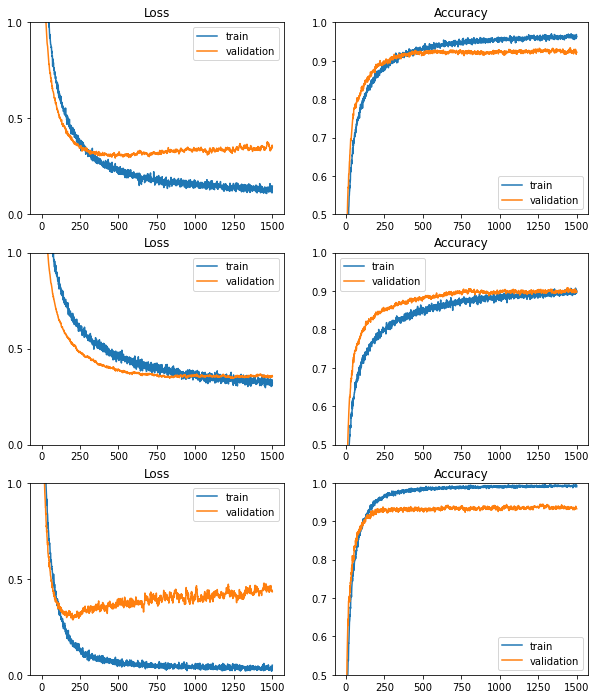

In [25]:
plot_models_history(models_history, min_loss=0, max_loss = 1, step_loss=0.5, min_eval_score=0.5, max_eval_score=1, step_eval_score=0.1 )

## Next Steps
The model with more layers achieved more performance. Now we will try to:

1 - Add more units to the layers

2 - Add one more layer

In [26]:
my_models = list()

droupout_value = 0.25

## with more units
my_models.append(K.models.Sequential())
my_models[0].add(K.layers.Dense(256*2, activation='relu', input_shape=(final_data.shape[1],)))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(128*2, activation='relu'))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(64*2, activation='relu'))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(64*2, activation='relu'))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(32*2, activation='relu'))
my_models[0].add(K.layers.Dropout(droupout_value))
my_models[0].add(K.layers.Dense(labels.shape[1], activation='softmax'))

## with one more layer
my_models.append(K.models.Sequential())
my_models[1].add(K.layers.Dense(256*2, activation='relu', input_shape=(final_data.shape[1],)))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(256, activation='relu', input_shape=(final_data.shape[1],)))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(128, activation='relu'))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(64, activation='relu'))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(64, activation='relu'))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(32, activation='relu'))
my_models[1].add(K.layers.Dropout(droupout_value))
my_models[1].add(K.layers.Dense(labels.shape[1], activation='softmax'))

models_history = list()
for model in my_models:
    print(model)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    
    models_history.append(model.fit(x_train, 
                                    y_train, 
                                    batch_size=512, 
                                    epochs = 1500,
                                    validation_data=(x_val, y_val)))

Train on 3261 samples, validate on 1087 samples
Epoch 1/1500
3261/3261 [==============================] - 0s - loss: 2.1856 - acc: 0.1941 - val_loss: 1.9400 - val_acc: 0.3284
Epoch 2/1500
3261/3261 [==============================] - 0s - loss: 1.8754 - acc: 0.3579 - val_loss: 1.6271 - val_acc: 0.4673
Epoch 3/1500
3261/3261 [==============================] - 0s - loss: 1.6571 - acc: 0.4376 - val_loss: 1.3969 - val_acc: 0.5511
Epoch 4/1500
3261/3261 [==============================] - 0s - loss: 1.5276 - acc: 0.4839 - val_loss: 1.2588 - val_acc: 0.5796
Epoch 5/1500
3261/3261 [==============================] - 0s - loss: 1.3969 - acc: 0.5207 - val_loss: 1.1868 - val_acc: 0.5888
Epoch 6/1500
3261/3261 [==============================] - 0s - loss: 1.3291 - acc: 0.5480 - val_loss: 1.0752 - val_acc: 0.6467
Epoch 7/1500
3261/3261 [==============================] - 0s - loss: 1.2319 - acc: 0.5934 - val_loss: 1.0101 - val_acc: 0.6845
Epoch 8/1500
3261/3261 [==============================] - 0s - 

3261/3261 [==============================] - 0s - loss: 0.2154 - acc: 0.9338 - val_loss: 0.2978 - val_acc: 0.9181
Epoch 65/1500
3261/3261 [==============================] - 0s - loss: 0.1863 - acc: 0.9430 - val_loss: 0.3029 - val_acc: 0.9227
Epoch 66/1500
3261/3261 [==============================] - 0s - loss: 0.1822 - acc: 0.9420 - val_loss: 0.3007 - val_acc: 0.9255
Epoch 67/1500
3261/3261 [==============================] - 0s - loss: 0.1857 - acc: 0.9393 - val_loss: 0.3299 - val_acc: 0.9117
Epoch 68/1500
3261/3261 [==============================] - 0s - loss: 0.1907 - acc: 0.9448 - val_loss: 0.2933 - val_acc: 0.9190
Epoch 69/1500
3261/3261 [==============================] - 0s - loss: 0.1558 - acc: 0.9546 - val_loss: 0.3233 - val_acc: 0.9163
Epoch 70/1500
3261/3261 [==============================] - 0s - loss: 0.1677 - acc: 0.9512 - val_loss: 0.3302 - val_acc: 0.9135
Epoch 71/1500
3261/3261 [==============================] - 0s - loss: 0.1571 - acc: 0.9512 - val_loss: 0.3161 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0616 - acc: 0.9841 - val_loss: 0.3534 - val_acc: 0.9292
Epoch 128/1500
3261/3261 [==============================] - 0s - loss: 0.0555 - acc: 0.9850 - val_loss: 0.3624 - val_acc: 0.9301
Epoch 129/1500
3261/3261 [==============================] - 0s - loss: 0.0559 - acc: 0.9841 - val_loss: 0.3934 - val_acc: 0.9273
Epoch 130/1500
3261/3261 [==============================] - 0s - loss: 0.0673 - acc: 0.9807 - val_loss: 0.3881 - val_acc: 0.9282
Epoch 131/1500
3261/3261 [==============================] - 0s - loss: 0.0538 - acc: 0.9856 - val_loss: 0.3569 - val_acc: 0.9292
Epoch 132/1500
3261/3261 [==============================] - 0s - loss: 0.0467 - acc: 0.9853 - val_loss: 0.3493 - val_acc: 0.9310
Epoch 133/1500
3261/3261 [==============================] - 0s - loss: 0.0464 - acc: 0.9859 - val_loss: 0.3400 - val_acc: 0.9374
Epoch 134/1500
3261/3261 [==============================] - 0s - loss: 0.0544 - acc: 0.9844 - val_loss: 0.3509 -

3261/3261 [==============================] - 0s - loss: 0.0237 - acc: 0.9936 - val_loss: 0.4019 - val_acc: 0.9301
Epoch 191/1500
3261/3261 [==============================] - 0s - loss: 0.0396 - acc: 0.9908 - val_loss: 0.3863 - val_acc: 0.9310
Epoch 192/1500
3261/3261 [==============================] - 0s - loss: 0.0438 - acc: 0.9887 - val_loss: 0.3767 - val_acc: 0.9319
Epoch 193/1500
3261/3261 [==============================] - 0s - loss: 0.0308 - acc: 0.9920 - val_loss: 0.3805 - val_acc: 0.9319
Epoch 194/1500
3261/3261 [==============================] - 0s - loss: 0.0388 - acc: 0.9905 - val_loss: 0.3775 - val_acc: 0.9338
Epoch 195/1500
3261/3261 [==============================] - 0s - loss: 0.0397 - acc: 0.9893 - val_loss: 0.3733 - val_acc: 0.9347
Epoch 196/1500
3261/3261 [==============================] - 0s - loss: 0.0477 - acc: 0.9905 - val_loss: 0.3772 - val_acc: 0.9338
Epoch 197/1500
3261/3261 [==============================] - 0s - loss: 0.0287 - acc: 0.9920 - val_loss: 0.3594 -

3261/3261 [==============================] - 0s - loss: 0.0271 - acc: 0.9933 - val_loss: 0.4192 - val_acc: 0.9319
Epoch 254/1500
3261/3261 [==============================] - 0s - loss: 0.0252 - acc: 0.9917 - val_loss: 0.4122 - val_acc: 0.9292
Epoch 255/1500
3261/3261 [==============================] - 0s - loss: 0.0268 - acc: 0.9914 - val_loss: 0.4252 - val_acc: 0.9319
Epoch 256/1500
3261/3261 [==============================] - 0s - loss: 0.0316 - acc: 0.9923 - val_loss: 0.3753 - val_acc: 0.9402
Epoch 257/1500
3261/3261 [==============================] - 0s - loss: 0.0230 - acc: 0.9929 - val_loss: 0.3711 - val_acc: 0.9356
Epoch 258/1500
3261/3261 [==============================] - 0s - loss: 0.0192 - acc: 0.9936 - val_loss: 0.3884 - val_acc: 0.9310
Epoch 259/1500
3261/3261 [==============================] - 0s - loss: 0.0293 - acc: 0.9917 - val_loss: 0.3848 - val_acc: 0.9347
Epoch 260/1500
3261/3261 [==============================] - 0s - loss: 0.0251 - acc: 0.9939 - val_loss: 0.4078 -

3261/3261 [==============================] - 0s - loss: 0.0214 - acc: 0.9939 - val_loss: 0.3758 - val_acc: 0.9347
Epoch 317/1500
3261/3261 [==============================] - 0s - loss: 0.0191 - acc: 0.9948 - val_loss: 0.3976 - val_acc: 0.9365
Epoch 318/1500
3261/3261 [==============================] - 0s - loss: 0.0168 - acc: 0.9948 - val_loss: 0.3960 - val_acc: 0.9319
Epoch 319/1500
3261/3261 [==============================] - 0s - loss: 0.0133 - acc: 0.9966 - val_loss: 0.4080 - val_acc: 0.9338
Epoch 320/1500
3261/3261 [==============================] - 0s - loss: 0.0233 - acc: 0.9939 - val_loss: 0.3912 - val_acc: 0.9384
Epoch 321/1500
3261/3261 [==============================] - 0s - loss: 0.0207 - acc: 0.9936 - val_loss: 0.3617 - val_acc: 0.9328
Epoch 322/1500
3261/3261 [==============================] - 0s - loss: 0.0270 - acc: 0.9902 - val_loss: 0.3902 - val_acc: 0.9310
Epoch 323/1500
3261/3261 [==============================] - 0s - loss: 0.0221 - acc: 0.9926 - val_loss: 0.3686 -

3261/3261 [==============================] - 0s - loss: 0.0244 - acc: 0.9951 - val_loss: 0.4167 - val_acc: 0.9365
Epoch 380/1500
3261/3261 [==============================] - 0s - loss: 0.0183 - acc: 0.9945 - val_loss: 0.4079 - val_acc: 0.9393
Epoch 381/1500
3261/3261 [==============================] - 0s - loss: 0.0189 - acc: 0.9957 - val_loss: 0.3927 - val_acc: 0.9365
Epoch 382/1500
3261/3261 [==============================] - 0s - loss: 0.0204 - acc: 0.9951 - val_loss: 0.3849 - val_acc: 0.9374
Epoch 383/1500
3261/3261 [==============================] - 0s - loss: 0.0152 - acc: 0.9945 - val_loss: 0.3814 - val_acc: 0.9384
Epoch 384/1500
3261/3261 [==============================] - 0s - loss: 0.0229 - acc: 0.9954 - val_loss: 0.3880 - val_acc: 0.9365
Epoch 385/1500
3261/3261 [==============================] - 0s - loss: 0.0115 - acc: 0.9960 - val_loss: 0.3884 - val_acc: 0.9310
Epoch 386/1500
3261/3261 [==============================] - 0s - loss: 0.0145 - acc: 0.9960 - val_loss: 0.3919 -

3261/3261 [==============================] - 0s - loss: 0.0115 - acc: 0.9963 - val_loss: 0.3963 - val_acc: 0.9374
Epoch 443/1500
3261/3261 [==============================] - 0s - loss: 0.0222 - acc: 0.9936 - val_loss: 0.4044 - val_acc: 0.9338
Epoch 444/1500
3261/3261 [==============================] - 0s - loss: 0.0151 - acc: 0.9960 - val_loss: 0.4148 - val_acc: 0.9365
Epoch 445/1500
3261/3261 [==============================] - 0s - loss: 0.0162 - acc: 0.9963 - val_loss: 0.4441 - val_acc: 0.9374
Epoch 446/1500
3261/3261 [==============================] - 0s - loss: 0.0094 - acc: 0.9969 - val_loss: 0.4482 - val_acc: 0.9393
Epoch 447/1500
3261/3261 [==============================] - 0s - loss: 0.0183 - acc: 0.9945 - val_loss: 0.4160 - val_acc: 0.9365
Epoch 448/1500
3261/3261 [==============================] - 0s - loss: 0.0213 - acc: 0.9954 - val_loss: 0.4396 - val_acc: 0.9292
Epoch 449/1500
3261/3261 [==============================] - 0s - loss: 0.0110 - acc: 0.9963 - val_loss: 0.4295 -

3261/3261 [==============================] - 0s - loss: 0.0225 - acc: 0.9960 - val_loss: 0.4365 - val_acc: 0.9365
Epoch 506/1500
3261/3261 [==============================] - 0s - loss: 0.0268 - acc: 0.9957 - val_loss: 0.4354 - val_acc: 0.9393
Epoch 507/1500
3261/3261 [==============================] - 0s - loss: 0.0095 - acc: 0.9963 - val_loss: 0.4275 - val_acc: 0.9365
Epoch 508/1500
3261/3261 [==============================] - 0s - loss: 0.0117 - acc: 0.9963 - val_loss: 0.4343 - val_acc: 0.9310
Epoch 509/1500
3261/3261 [==============================] - 0s - loss: 0.0104 - acc: 0.9966 - val_loss: 0.4421 - val_acc: 0.9310
Epoch 510/1500
3261/3261 [==============================] - 0s - loss: 0.0223 - acc: 0.9951 - val_loss: 0.4162 - val_acc: 0.9374
Epoch 511/1500
3261/3261 [==============================] - 0s - loss: 0.0170 - acc: 0.9963 - val_loss: 0.4629 - val_acc: 0.9328
Epoch 512/1500
3261/3261 [==============================] - 0s - loss: 0.0278 - acc: 0.9939 - val_loss: 0.4741 -

3261/3261 [==============================] - 0s - loss: 0.0165 - acc: 0.9969 - val_loss: 0.4819 - val_acc: 0.9384
Epoch 569/1500
3261/3261 [==============================] - 0s - loss: 0.0098 - acc: 0.9979 - val_loss: 0.4751 - val_acc: 0.9347
Epoch 570/1500
3261/3261 [==============================] - 0s - loss: 0.0061 - acc: 0.9969 - val_loss: 0.4634 - val_acc: 0.9356
Epoch 571/1500
3261/3261 [==============================] - 0s - loss: 0.0257 - acc: 0.9948 - val_loss: 0.4888 - val_acc: 0.9319
Epoch 572/1500
3261/3261 [==============================] - 0s - loss: 0.0200 - acc: 0.9954 - val_loss: 0.4730 - val_acc: 0.9365
Epoch 573/1500
3261/3261 [==============================] - 0s - loss: 0.0087 - acc: 0.9975 - val_loss: 0.4823 - val_acc: 0.9402
Epoch 574/1500
3261/3261 [==============================] - 0s - loss: 0.0120 - acc: 0.9957 - val_loss: 0.4661 - val_acc: 0.9402
Epoch 575/1500
3261/3261 [==============================] - 0s - loss: 0.0098 - acc: 0.9969 - val_loss: 0.4762 -

3261/3261 [==============================] - 0s - loss: 0.0175 - acc: 0.9969 - val_loss: 0.4749 - val_acc: 0.9384
Epoch 632/1500
3261/3261 [==============================] - 0s - loss: 0.0163 - acc: 0.9960 - val_loss: 0.4458 - val_acc: 0.9402
Epoch 633/1500
3261/3261 [==============================] - 0s - loss: 0.0125 - acc: 0.9954 - val_loss: 0.4911 - val_acc: 0.9365
Epoch 634/1500
3261/3261 [==============================] - 0s - loss: 0.0194 - acc: 0.9948 - val_loss: 0.4807 - val_acc: 0.9393
Epoch 635/1500
3261/3261 [==============================] - 0s - loss: 0.0064 - acc: 0.9979 - val_loss: 0.4716 - val_acc: 0.9402
Epoch 636/1500
3261/3261 [==============================] - 0s - loss: 0.0135 - acc: 0.9966 - val_loss: 0.4772 - val_acc: 0.9393
Epoch 637/1500
3261/3261 [==============================] - 0s - loss: 0.0099 - acc: 0.9975 - val_loss: 0.4603 - val_acc: 0.9365
Epoch 638/1500
3261/3261 [==============================] - 0s - loss: 0.0193 - acc: 0.9957 - val_loss: 0.4640 -

3261/3261 [==============================] - 0s - loss: 0.0118 - acc: 0.9960 - val_loss: 0.4849 - val_acc: 0.9365
Epoch 695/1500
3261/3261 [==============================] - 0s - loss: 0.0202 - acc: 0.9957 - val_loss: 0.4593 - val_acc: 0.9384
Epoch 696/1500
3261/3261 [==============================] - 0s - loss: 0.0101 - acc: 0.9957 - val_loss: 0.4408 - val_acc: 0.9384
Epoch 697/1500
3261/3261 [==============================] - 0s - loss: 0.0089 - acc: 0.9979 - val_loss: 0.4543 - val_acc: 0.9420
Epoch 698/1500
3261/3261 [==============================] - 0s - loss: 0.0058 - acc: 0.9982 - val_loss: 0.4902 - val_acc: 0.9411
Epoch 699/1500
3261/3261 [==============================] - 0s - loss: 0.0115 - acc: 0.9972 - val_loss: 0.5275 - val_acc: 0.9393
Epoch 700/1500
3261/3261 [==============================] - 0s - loss: 0.0129 - acc: 0.9966 - val_loss: 0.5016 - val_acc: 0.9374
Epoch 701/1500
3261/3261 [==============================] - 0s - loss: 0.0214 - acc: 0.9951 - val_loss: 0.4827 -

3261/3261 [==============================] - 0s - loss: 0.0101 - acc: 0.9982 - val_loss: 0.5156 - val_acc: 0.9411
Epoch 758/1500
3261/3261 [==============================] - 0s - loss: 0.0115 - acc: 0.9975 - val_loss: 0.5409 - val_acc: 0.9347
Epoch 759/1500
3261/3261 [==============================] - 0s - loss: 0.0165 - acc: 0.9972 - val_loss: 0.5384 - val_acc: 0.9393
Epoch 760/1500
3261/3261 [==============================] - 0s - loss: 0.0134 - acc: 0.9966 - val_loss: 0.5336 - val_acc: 0.9356
Epoch 761/1500
3261/3261 [==============================] - 0s - loss: 0.0101 - acc: 0.9957 - val_loss: 0.5040 - val_acc: 0.9365
Epoch 762/1500
3261/3261 [==============================] - 0s - loss: 0.0189 - acc: 0.9957 - val_loss: 0.5331 - val_acc: 0.9374
Epoch 763/1500
3261/3261 [==============================] - 0s - loss: 0.0102 - acc: 0.9960 - val_loss: 0.5595 - val_acc: 0.9402
Epoch 764/1500
3261/3261 [==============================] - 0s - loss: 0.0217 - acc: 0.9960 - val_loss: 0.5281 -

3261/3261 [==============================] - 0s - loss: 0.0168 - acc: 0.9951 - val_loss: 0.4873 - val_acc: 0.9411
Epoch 821/1500
3261/3261 [==============================] - 0s - loss: 0.0067 - acc: 0.9988 - val_loss: 0.4865 - val_acc: 0.9420
Epoch 822/1500
3261/3261 [==============================] - 0s - loss: 0.0192 - acc: 0.9963 - val_loss: 0.4585 - val_acc: 0.9420
Epoch 823/1500
3261/3261 [==============================] - 0s - loss: 0.0155 - acc: 0.9966 - val_loss: 0.4348 - val_acc: 0.9439
Epoch 824/1500
3261/3261 [==============================] - 0s - loss: 0.0118 - acc: 0.9979 - val_loss: 0.4848 - val_acc: 0.9420
Epoch 825/1500
3261/3261 [==============================] - 0s - loss: 0.0104 - acc: 0.9982 - val_loss: 0.4643 - val_acc: 0.9411
Epoch 826/1500
3261/3261 [==============================] - 0s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.4722 - val_acc: 0.9393
Epoch 827/1500
3261/3261 [==============================] - 0s - loss: 0.0034 - acc: 0.9988 - val_loss: 0.4816 -

3261/3261 [==============================] - 0s - loss: 0.0121 - acc: 0.9957 - val_loss: 0.4843 - val_acc: 0.9356
Epoch 884/1500
3261/3261 [==============================] - 0s - loss: 0.0096 - acc: 0.9982 - val_loss: 0.4688 - val_acc: 0.9393
Epoch 885/1500
3261/3261 [==============================] - 0s - loss: 0.0122 - acc: 0.9966 - val_loss: 0.4836 - val_acc: 0.9365
Epoch 886/1500
3261/3261 [==============================] - 0s - loss: 0.0171 - acc: 0.9963 - val_loss: 0.4809 - val_acc: 0.9384
Epoch 887/1500
3261/3261 [==============================] - 0s - loss: 0.0155 - acc: 0.9972 - val_loss: 0.4794 - val_acc: 0.9411
Epoch 888/1500
3261/3261 [==============================] - 0s - loss: 0.0153 - acc: 0.9966 - val_loss: 0.4907 - val_acc: 0.9402
Epoch 889/1500
3261/3261 [==============================] - 0s - loss: 0.0158 - acc: 0.9966 - val_loss: 0.4689 - val_acc: 0.9374
Epoch 890/1500
3261/3261 [==============================] - 0s - loss: 0.0046 - acc: 0.9979 - val_loss: 0.4861 -

3261/3261 [==============================] - 0s - loss: 0.0031 - acc: 0.9991 - val_loss: 0.5057 - val_acc: 0.9356
Epoch 947/1500
3261/3261 [==============================] - 0s - loss: 0.0217 - acc: 0.9957 - val_loss: 0.5257 - val_acc: 0.9365
Epoch 948/1500
3261/3261 [==============================] - 0s - loss: 0.0140 - acc: 0.9966 - val_loss: 0.5164 - val_acc: 0.9393
Epoch 949/1500
3261/3261 [==============================] - 0s - loss: 0.0119 - acc: 0.9982 - val_loss: 0.5271 - val_acc: 0.9365
Epoch 950/1500
3261/3261 [==============================] - 0s - loss: 0.0142 - acc: 0.9969 - val_loss: 0.5263 - val_acc: 0.9347
Epoch 951/1500
3261/3261 [==============================] - 0s - loss: 0.0233 - acc: 0.9963 - val_loss: 0.5156 - val_acc: 0.9393
Epoch 952/1500
3261/3261 [==============================] - 0s - loss: 0.0136 - acc: 0.9975 - val_loss: 0.5041 - val_acc: 0.9310
Epoch 953/1500
3261/3261 [==============================] - 0s - loss: 0.0091 - acc: 0.9969 - val_loss: 0.5359 -

3261/3261 [==============================] - 0s - loss: 0.0092 - acc: 0.9979 - val_loss: 0.5049 - val_acc: 0.9374
Epoch 1010/1500
3261/3261 [==============================] - 0s - loss: 0.0081 - acc: 0.9972 - val_loss: 0.5141 - val_acc: 0.9347
Epoch 1011/1500
3261/3261 [==============================] - 0s - loss: 0.0188 - acc: 0.9966 - val_loss: 0.4973 - val_acc: 0.9347
Epoch 1012/1500
3261/3261 [==============================] - 0s - loss: 0.0139 - acc: 0.9972 - val_loss: 0.4838 - val_acc: 0.9365
Epoch 1013/1500
3261/3261 [==============================] - 0s - loss: 0.0085 - acc: 0.9963 - val_loss: 0.5611 - val_acc: 0.9356
Epoch 1014/1500
3261/3261 [==============================] - 0s - loss: 0.0200 - acc: 0.9951 - val_loss: 0.5454 - val_acc: 0.9365
Epoch 1015/1500
3261/3261 [==============================] - 0s - loss: 0.0066 - acc: 0.9975 - val_loss: 0.5281 - val_acc: 0.9374
Epoch 1016/1500
3261/3261 [==============================] - 0s - loss: 0.0099 - acc: 0.9969 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0177 - acc: 0.9975 - val_loss: 0.4961 - val_acc: 0.9430
Epoch 1073/1500
3261/3261 [==============================] - 0s - loss: 0.0158 - acc: 0.9966 - val_loss: 0.4859 - val_acc: 0.9402
Epoch 1074/1500
3261/3261 [==============================] - 0s - loss: 0.0131 - acc: 0.9969 - val_loss: 0.4827 - val_acc: 0.9457
Epoch 1075/1500
3261/3261 [==============================] - 0s - loss: 0.0171 - acc: 0.9954 - val_loss: 0.4677 - val_acc: 0.9457
Epoch 1076/1500
3261/3261 [==============================] - 0s - loss: 0.0070 - acc: 0.9969 - val_loss: 0.4785 - val_acc: 0.9430
Epoch 1077/1500
3261/3261 [==============================] - 0s - loss: 0.0238 - acc: 0.9957 - val_loss: 0.4708 - val_acc: 0.9402
Epoch 1078/1500
3261/3261 [==============================] - 0s - loss: 0.0035 - acc: 0.9985 - val_loss: 0.4695 - val_acc: 0.9374
Epoch 1079/1500
3261/3261 [==============================] - 0s - loss: 0.0224 - acc: 0.9966 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0067 - acc: 0.9985 - val_loss: 0.5196 - val_acc: 0.9411
Epoch 1136/1500
3261/3261 [==============================] - 0s - loss: 0.0219 - acc: 0.9975 - val_loss: 0.4925 - val_acc: 0.9402
Epoch 1137/1500
3261/3261 [==============================] - 0s - loss: 0.0187 - acc: 0.9972 - val_loss: 0.4929 - val_acc: 0.9439
Epoch 1138/1500
3261/3261 [==============================] - 0s - loss: 0.0106 - acc: 0.9979 - val_loss: 0.5145 - val_acc: 0.9420
Epoch 1139/1500
3261/3261 [==============================] - 0s - loss: 0.0209 - acc: 0.9969 - val_loss: 0.5015 - val_acc: 0.9439
Epoch 1140/1500
3261/3261 [==============================] - 0s - loss: 0.0212 - acc: 0.9969 - val_loss: 0.5395 - val_acc: 0.9365
Epoch 1141/1500
3261/3261 [==============================] - 0s - loss: 0.0191 - acc: 0.9966 - val_loss: 0.5008 - val_acc: 0.9347
Epoch 1142/1500
3261/3261 [==============================] - 0s - loss: 0.0150 - acc: 0.9972 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0200 - acc: 0.9957 - val_loss: 0.4862 - val_acc: 0.9365
Epoch 1199/1500
3261/3261 [==============================] - 0s - loss: 0.0182 - acc: 0.9975 - val_loss: 0.5076 - val_acc: 0.9402
Epoch 1200/1500
3261/3261 [==============================] - 0s - loss: 0.0141 - acc: 0.9972 - val_loss: 0.5136 - val_acc: 0.9374
Epoch 1201/1500
3261/3261 [==============================] - 0s - loss: 0.0172 - acc: 0.9951 - val_loss: 0.5274 - val_acc: 0.9402
Epoch 1202/1500
3261/3261 [==============================] - 0s - loss: 0.0095 - acc: 0.9972 - val_loss: 0.5303 - val_acc: 0.9393
Epoch 1203/1500
3261/3261 [==============================] - 0s - loss: 0.0132 - acc: 0.9972 - val_loss: 0.5018 - val_acc: 0.9411
Epoch 1204/1500
3261/3261 [==============================] - 0s - loss: 0.0143 - acc: 0.9982 - val_loss: 0.5171 - val_acc: 0.9420
Epoch 1205/1500
3261/3261 [==============================] - 0s - loss: 0.0065 - acc: 0.9985 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0123 - acc: 0.9975 - val_loss: 0.4647 - val_acc: 0.9430
Epoch 1262/1500
3261/3261 [==============================] - 0s - loss: 0.0296 - acc: 0.9933 - val_loss: 0.4732 - val_acc: 0.9411
Epoch 1263/1500
3261/3261 [==============================] - 0s - loss: 0.0073 - acc: 0.9988 - val_loss: 0.4645 - val_acc: 0.9411
Epoch 1264/1500
3261/3261 [==============================] - 0s - loss: 0.0134 - acc: 0.9963 - val_loss: 0.4435 - val_acc: 0.9402
Epoch 1265/1500
3261/3261 [==============================] - 0s - loss: 0.0112 - acc: 0.9972 - val_loss: 0.4468 - val_acc: 0.9411
Epoch 1266/1500
3261/3261 [==============================] - 0s - loss: 0.0200 - acc: 0.9966 - val_loss: 0.4435 - val_acc: 0.9411
Epoch 1267/1500
3261/3261 [==============================] - 0s - loss: 0.0164 - acc: 0.9963 - val_loss: 0.4288 - val_acc: 0.9384
Epoch 1268/1500
3261/3261 [==============================] - 0s - loss: 0.0050 - acc: 0.9982 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0218 - acc: 0.9960 - val_loss: 0.5035 - val_acc: 0.9384
Epoch 1325/1500
3261/3261 [==============================] - 0s - loss: 0.0092 - acc: 0.9979 - val_loss: 0.4903 - val_acc: 0.9384
Epoch 1326/1500
3261/3261 [==============================] - 0s - loss: 0.0148 - acc: 0.9969 - val_loss: 0.4921 - val_acc: 0.9374
Epoch 1327/1500
3261/3261 [==============================] - 0s - loss: 0.0172 - acc: 0.9972 - val_loss: 0.5128 - val_acc: 0.9384
Epoch 1328/1500
3261/3261 [==============================] - 0s - loss: 0.0155 - acc: 0.9979 - val_loss: 0.5215 - val_acc: 0.9430
Epoch 1329/1500
3261/3261 [==============================] - 0s - loss: 0.0106 - acc: 0.9979 - val_loss: 0.5341 - val_acc: 0.9393
Epoch 1330/1500
3261/3261 [==============================] - 0s - loss: 0.0124 - acc: 0.9972 - val_loss: 0.5525 - val_acc: 0.9384
Epoch 1331/1500
3261/3261 [==============================] - 0s - loss: 0.0148 - acc: 0.9966 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0153 - acc: 0.9972 - val_loss: 0.5362 - val_acc: 0.9374
Epoch 1388/1500
3261/3261 [==============================] - 0s - loss: 0.0159 - acc: 0.9963 - val_loss: 0.5511 - val_acc: 0.9384
Epoch 1389/1500
3261/3261 [==============================] - 0s - loss: 0.0149 - acc: 0.9972 - val_loss: 0.5254 - val_acc: 0.9365
Epoch 1390/1500
3261/3261 [==============================] - 0s - loss: 0.0221 - acc: 0.9954 - val_loss: 0.5316 - val_acc: 0.9356
Epoch 1391/1500
3261/3261 [==============================] - 0s - loss: 0.0154 - acc: 0.9982 - val_loss: 0.5355 - val_acc: 0.9356
Epoch 1392/1500
3261/3261 [==============================] - 0s - loss: 0.0110 - acc: 0.9985 - val_loss: 0.5446 - val_acc: 0.9374
Epoch 1393/1500
3261/3261 [==============================] - 0s - loss: 0.0058 - acc: 0.9979 - val_loss: 0.5354 - val_acc: 0.9365
Epoch 1394/1500
3261/3261 [==============================] - 0s - loss: 0.0052 - acc: 0.9988 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0151 - acc: 0.9969 - val_loss: 0.5177 - val_acc: 0.9384
Epoch 1451/1500
3261/3261 [==============================] - 0s - loss: 0.0066 - acc: 0.9991 - val_loss: 0.5443 - val_acc: 0.9384
Epoch 1452/1500
3261/3261 [==============================] - 0s - loss: 0.0115 - acc: 0.9972 - val_loss: 0.5555 - val_acc: 0.9393
Epoch 1453/1500
3261/3261 [==============================] - 0s - loss: 0.0082 - acc: 0.9982 - val_loss: 0.5673 - val_acc: 0.9374
Epoch 1454/1500
3261/3261 [==============================] - 0s - loss: 0.0177 - acc: 0.9969 - val_loss: 0.5990 - val_acc: 0.9374
Epoch 1455/1500
3261/3261 [==============================] - 0s - loss: 0.0203 - acc: 0.9969 - val_loss: 0.6018 - val_acc: 0.9347
Epoch 1456/1500
3261/3261 [==============================] - 0s - loss: 0.0286 - acc: 0.9960 - val_loss: 0.5839 - val_acc: 0.9347
Epoch 1457/1500
3261/3261 [==============================] - 0s - loss: 0.0137 - acc: 0.9972 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 1.2771 - acc: 0.5713 - val_loss: 1.0321 - val_acc: 0.6808
Epoch 13/1500
3261/3261 [==============================] - 0s - loss: 1.2227 - acc: 0.5986 - val_loss: 0.9721 - val_acc: 0.6973
Epoch 14/1500
3261/3261 [==============================] - 0s - loss: 1.1976 - acc: 0.6151 - val_loss: 0.9292 - val_acc: 0.7130
Epoch 15/1500
3261/3261 [==============================] - 0s - loss: 1.1200 - acc: 0.6299 - val_loss: 0.9007 - val_acc: 0.7157
Epoch 16/1500
3261/3261 [==============================] - 0s - loss: 1.1051 - acc: 0.6495 - val_loss: 0.8883 - val_acc: 0.7360
Epoch 17/1500
3261/3261 [==============================] - 0s - loss: 1.0642 - acc: 0.6578 - val_loss: 0.8645 - val_acc: 0.7470
Epoch 18/1500
3261/3261 [==============================] - 0s - loss: 1.0527 - acc: 0.6673 - val_loss: 0.8233 - val_acc: 0.7571
Epoch 19/1500
3261/3261 [==============================] - 0s - loss: 0.9640 - acc: 0.6808 - val_loss: 0.8068 - val_ac

3261/3261 [==============================] - 0s - loss: 0.2457 - acc: 0.9347 - val_loss: 0.3347 - val_acc: 0.9071
Epoch 77/1500
3261/3261 [==============================] - 0s - loss: 0.2296 - acc: 0.9353 - val_loss: 0.3397 - val_acc: 0.9126
Epoch 78/1500
3261/3261 [==============================] - 0s - loss: 0.2212 - acc: 0.9353 - val_loss: 0.3491 - val_acc: 0.9052
Epoch 79/1500
3261/3261 [==============================] - 0s - loss: 0.2334 - acc: 0.9353 - val_loss: 0.3364 - val_acc: 0.9071
Epoch 80/1500
3261/3261 [==============================] - 0s - loss: 0.2316 - acc: 0.9408 - val_loss: 0.3303 - val_acc: 0.9117
Epoch 81/1500
3261/3261 [==============================] - 0s - loss: 0.2189 - acc: 0.9393 - val_loss: 0.3674 - val_acc: 0.9043
Epoch 82/1500
3261/3261 [==============================] - 0s - loss: 0.2164 - acc: 0.9466 - val_loss: 0.3506 - val_acc: 0.9071
Epoch 83/1500
3261/3261 [==============================] - 0s - loss: 0.1922 - acc: 0.9500 - val_loss: 0.3429 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0860 - acc: 0.9795 - val_loss: 0.3803 - val_acc: 0.9246
Epoch 140/1500
3261/3261 [==============================] - 0s - loss: 0.0895 - acc: 0.9782 - val_loss: 0.3777 - val_acc: 0.9292
Epoch 141/1500
3261/3261 [==============================] - 0s - loss: 0.0829 - acc: 0.9795 - val_loss: 0.4085 - val_acc: 0.9246
Epoch 142/1500
3261/3261 [==============================] - 0s - loss: 0.1004 - acc: 0.9742 - val_loss: 0.3832 - val_acc: 0.9273
Epoch 143/1500
3261/3261 [==============================] - 0s - loss: 0.0879 - acc: 0.9791 - val_loss: 0.3931 - val_acc: 0.9246
Epoch 144/1500
3261/3261 [==============================] - 0s - loss: 0.0794 - acc: 0.9788 - val_loss: 0.3943 - val_acc: 0.9264
Epoch 145/1500
3261/3261 [==============================] - 0s - loss: 0.0850 - acc: 0.9798 - val_loss: 0.4004 - val_acc: 0.9246
Epoch 146/1500
3261/3261 [==============================] - 0s - loss: 0.0736 - acc: 0.9798 - val_loss: 0.4038 -

3261/3261 [==============================] - 0s - loss: 0.0581 - acc: 0.9871 - val_loss: 0.4030 - val_acc: 0.9356
Epoch 203/1500
3261/3261 [==============================] - 0s - loss: 0.0503 - acc: 0.9890 - val_loss: 0.4358 - val_acc: 0.9310
Epoch 204/1500
3261/3261 [==============================] - 0s - loss: 0.0558 - acc: 0.9883 - val_loss: 0.4463 - val_acc: 0.9319
Epoch 205/1500
3261/3261 [==============================] - 0s - loss: 0.0538 - acc: 0.9859 - val_loss: 0.4224 - val_acc: 0.9328
Epoch 206/1500
3261/3261 [==============================] - 0s - loss: 0.0568 - acc: 0.9896 - val_loss: 0.4323 - val_acc: 0.9319
Epoch 207/1500
3261/3261 [==============================] - 0s - loss: 0.0555 - acc: 0.9877 - val_loss: 0.4344 - val_acc: 0.9301
Epoch 208/1500
3261/3261 [==============================] - 0s - loss: 0.0494 - acc: 0.9877 - val_loss: 0.4692 - val_acc: 0.9273
Epoch 209/1500
3261/3261 [==============================] - 0s - loss: 0.0512 - acc: 0.9868 - val_loss: 0.5106 -

3261/3261 [==============================] - 0s - loss: 0.0316 - acc: 0.9929 - val_loss: 0.4613 - val_acc: 0.9292
Epoch 266/1500
3261/3261 [==============================] - 0s - loss: 0.0354 - acc: 0.9905 - val_loss: 0.4345 - val_acc: 0.9310
Epoch 267/1500
3261/3261 [==============================] - 0s - loss: 0.0422 - acc: 0.9911 - val_loss: 0.4551 - val_acc: 0.9292
Epoch 268/1500
3261/3261 [==============================] - 0s - loss: 0.0450 - acc: 0.9917 - val_loss: 0.4897 - val_acc: 0.9310
Epoch 269/1500
3261/3261 [==============================] - 0s - loss: 0.0380 - acc: 0.9923 - val_loss: 0.4958 - val_acc: 0.9338
Epoch 270/1500
3261/3261 [==============================] - 0s - loss: 0.0295 - acc: 0.9917 - val_loss: 0.4918 - val_acc: 0.9292
Epoch 271/1500
3261/3261 [==============================] - 0s - loss: 0.0231 - acc: 0.9957 - val_loss: 0.4719 - val_acc: 0.9319
Epoch 272/1500
3261/3261 [==============================] - 0s - loss: 0.0378 - acc: 0.9905 - val_loss: 0.4827 -

3261/3261 [==============================] - 0s - loss: 0.0281 - acc: 0.9939 - val_loss: 0.5018 - val_acc: 0.9356
Epoch 329/1500
3261/3261 [==============================] - 0s - loss: 0.0312 - acc: 0.9933 - val_loss: 0.4892 - val_acc: 0.9365
Epoch 330/1500
3261/3261 [==============================] - 0s - loss: 0.0350 - acc: 0.9929 - val_loss: 0.4704 - val_acc: 0.9365
Epoch 331/1500
3261/3261 [==============================] - 0s - loss: 0.0224 - acc: 0.9954 - val_loss: 0.5138 - val_acc: 0.9328
Epoch 332/1500
3261/3261 [==============================] - 0s - loss: 0.0531 - acc: 0.9896 - val_loss: 0.5267 - val_acc: 0.9264
Epoch 333/1500
3261/3261 [==============================] - 0s - loss: 0.0357 - acc: 0.9926 - val_loss: 0.4786 - val_acc: 0.9365
Epoch 334/1500
3261/3261 [==============================] - 0s - loss: 0.0402 - acc: 0.9926 - val_loss: 0.4628 - val_acc: 0.9338
Epoch 335/1500
3261/3261 [==============================] - 0s - loss: 0.0314 - acc: 0.9929 - val_loss: 0.4904 -

3261/3261 [==============================] - 0s - loss: 0.0354 - acc: 0.9920 - val_loss: 0.4296 - val_acc: 0.9365
Epoch 392/1500
3261/3261 [==============================] - 0s - loss: 0.0407 - acc: 0.9939 - val_loss: 0.4263 - val_acc: 0.9347
Epoch 393/1500
3261/3261 [==============================] - 0s - loss: 0.0156 - acc: 0.9960 - val_loss: 0.4472 - val_acc: 0.9356
Epoch 394/1500
3261/3261 [==============================] - 0s - loss: 0.0249 - acc: 0.9945 - val_loss: 0.4852 - val_acc: 0.9338
Epoch 395/1500
3261/3261 [==============================] - 0s - loss: 0.0276 - acc: 0.9926 - val_loss: 0.4632 - val_acc: 0.9356
Epoch 396/1500
3261/3261 [==============================] - 0s - loss: 0.0250 - acc: 0.9942 - val_loss: 0.4735 - val_acc: 0.9347
Epoch 397/1500
3261/3261 [==============================] - 0s - loss: 0.0245 - acc: 0.9960 - val_loss: 0.4961 - val_acc: 0.9356
Epoch 398/1500
3261/3261 [==============================] - 0s - loss: 0.0328 - acc: 0.9936 - val_loss: 0.4937 -

3261/3261 [==============================] - 0s - loss: 0.0314 - acc: 0.9936 - val_loss: 0.4906 - val_acc: 0.9347
Epoch 455/1500
3261/3261 [==============================] - 0s - loss: 0.0327 - acc: 0.9945 - val_loss: 0.4921 - val_acc: 0.9328
Epoch 456/1500
3261/3261 [==============================] - 0s - loss: 0.0279 - acc: 0.9945 - val_loss: 0.4894 - val_acc: 0.9365
Epoch 457/1500
3261/3261 [==============================] - 0s - loss: 0.0225 - acc: 0.9963 - val_loss: 0.4913 - val_acc: 0.9393
Epoch 458/1500
3261/3261 [==============================] - 0s - loss: 0.0317 - acc: 0.9942 - val_loss: 0.4807 - val_acc: 0.9374
Epoch 459/1500
3261/3261 [==============================] - 0s - loss: 0.0353 - acc: 0.9942 - val_loss: 0.5156 - val_acc: 0.9356
Epoch 460/1500
3261/3261 [==============================] - 0s - loss: 0.0209 - acc: 0.9942 - val_loss: 0.5103 - val_acc: 0.9319
Epoch 461/1500
3261/3261 [==============================] - 0s - loss: 0.0268 - acc: 0.9942 - val_loss: 0.5322 -

3261/3261 [==============================] - 0s - loss: 0.0401 - acc: 0.9948 - val_loss: 0.4714 - val_acc: 0.9347
Epoch 518/1500
3261/3261 [==============================] - 0s - loss: 0.0234 - acc: 0.9948 - val_loss: 0.4805 - val_acc: 0.9384
Epoch 519/1500
3261/3261 [==============================] - 0s - loss: 0.0218 - acc: 0.9960 - val_loss: 0.4921 - val_acc: 0.9328
Epoch 520/1500
3261/3261 [==============================] - 0s - loss: 0.0269 - acc: 0.9948 - val_loss: 0.5030 - val_acc: 0.9384
Epoch 521/1500
3261/3261 [==============================] - 0s - loss: 0.0274 - acc: 0.9954 - val_loss: 0.5353 - val_acc: 0.9347
Epoch 522/1500
3261/3261 [==============================] - 0s - loss: 0.0486 - acc: 0.9933 - val_loss: 0.5132 - val_acc: 0.9347
Epoch 523/1500
3261/3261 [==============================] - 0s - loss: 0.0266 - acc: 0.9939 - val_loss: 0.5080 - val_acc: 0.9347
Epoch 524/1500
3261/3261 [==============================] - 0s - loss: 0.0287 - acc: 0.9926 - val_loss: 0.5458 -

3261/3261 [==============================] - 0s - loss: 0.0315 - acc: 0.9942 - val_loss: 0.5392 - val_acc: 0.9319
Epoch 581/1500
3261/3261 [==============================] - 0s - loss: 0.0318 - acc: 0.9948 - val_loss: 0.5541 - val_acc: 0.9356
Epoch 582/1500
3261/3261 [==============================] - 0s - loss: 0.0243 - acc: 0.9960 - val_loss: 0.5417 - val_acc: 0.9384
Epoch 583/1500
3261/3261 [==============================] - 0s - loss: 0.0302 - acc: 0.9948 - val_loss: 0.5586 - val_acc: 0.9282
Epoch 584/1500
3261/3261 [==============================] - 0s - loss: 0.0197 - acc: 0.9960 - val_loss: 0.5489 - val_acc: 0.9319
Epoch 585/1500
3261/3261 [==============================] - 0s - loss: 0.0094 - acc: 0.9969 - val_loss: 0.5670 - val_acc: 0.9301
Epoch 586/1500
3261/3261 [==============================] - 0s - loss: 0.0271 - acc: 0.9942 - val_loss: 0.5573 - val_acc: 0.9273
Epoch 587/1500
3261/3261 [==============================] - 0s - loss: 0.0268 - acc: 0.9963 - val_loss: 0.5610 -

3261/3261 [==============================] - 0s - loss: 0.0273 - acc: 0.9939 - val_loss: 0.5455 - val_acc: 0.9365
Epoch 644/1500
3261/3261 [==============================] - 0s - loss: 0.0255 - acc: 0.9960 - val_loss: 0.5544 - val_acc: 0.9374
Epoch 645/1500
3261/3261 [==============================] - 0s - loss: 0.0268 - acc: 0.9960 - val_loss: 0.5801 - val_acc: 0.9374
Epoch 646/1500
3261/3261 [==============================] - 0s - loss: 0.0300 - acc: 0.9942 - val_loss: 0.5793 - val_acc: 0.9365
Epoch 647/1500
3261/3261 [==============================] - 0s - loss: 0.0197 - acc: 0.9957 - val_loss: 0.5437 - val_acc: 0.9393
Epoch 648/1500
3261/3261 [==============================] - 0s - loss: 0.0292 - acc: 0.9951 - val_loss: 0.5576 - val_acc: 0.9393
Epoch 649/1500
3261/3261 [==============================] - 0s - loss: 0.0176 - acc: 0.9954 - val_loss: 0.5524 - val_acc: 0.9310
Epoch 650/1500
3261/3261 [==============================] - 0s - loss: 0.0174 - acc: 0.9957 - val_loss: 0.5652 -

3261/3261 [==============================] - 0s - loss: 0.0268 - acc: 0.9960 - val_loss: 0.5508 - val_acc: 0.9374
Epoch 707/1500
3261/3261 [==============================] - 0s - loss: 0.0269 - acc: 0.9951 - val_loss: 0.5566 - val_acc: 0.9301
Epoch 708/1500
3261/3261 [==============================] - 0s - loss: 0.0166 - acc: 0.9957 - val_loss: 0.5463 - val_acc: 0.9319
Epoch 709/1500
3261/3261 [==============================] - 0s - loss: 0.0197 - acc: 0.9960 - val_loss: 0.5370 - val_acc: 0.9384
Epoch 710/1500
3261/3261 [==============================] - 0s - loss: 0.0275 - acc: 0.9948 - val_loss: 0.5516 - val_acc: 0.9393
Epoch 711/1500
3261/3261 [==============================] - 0s - loss: 0.0320 - acc: 0.9954 - val_loss: 0.5434 - val_acc: 0.9347
Epoch 712/1500
3261/3261 [==============================] - 0s - loss: 0.0205 - acc: 0.9951 - val_loss: 0.5535 - val_acc: 0.9384
Epoch 713/1500
3261/3261 [==============================] - 0s - loss: 0.0177 - acc: 0.9948 - val_loss: 0.5597 -

3261/3261 [==============================] - 0s - loss: 0.0209 - acc: 0.9954 - val_loss: 0.4947 - val_acc: 0.9301
Epoch 770/1500
3261/3261 [==============================] - 0s - loss: 0.0238 - acc: 0.9972 - val_loss: 0.5090 - val_acc: 0.9310
Epoch 771/1500
3261/3261 [==============================] - 0s - loss: 0.0167 - acc: 0.9979 - val_loss: 0.5194 - val_acc: 0.9328
Epoch 772/1500
3261/3261 [==============================] - 0s - loss: 0.0156 - acc: 0.9972 - val_loss: 0.5044 - val_acc: 0.9384
Epoch 773/1500
3261/3261 [==============================] - 0s - loss: 0.0223 - acc: 0.9954 - val_loss: 0.5266 - val_acc: 0.9365
Epoch 774/1500
3261/3261 [==============================] - 0s - loss: 0.0159 - acc: 0.9969 - val_loss: 0.5438 - val_acc: 0.9347
Epoch 775/1500
3261/3261 [==============================] - 0s - loss: 0.0206 - acc: 0.9957 - val_loss: 0.5666 - val_acc: 0.9374
Epoch 776/1500
3261/3261 [==============================] - 0s - loss: 0.0289 - acc: 0.9963 - val_loss: 0.5822 -

3261/3261 [==============================] - 0s - loss: 0.0075 - acc: 0.9975 - val_loss: 0.5216 - val_acc: 0.9347
Epoch 833/1500
3261/3261 [==============================] - 0s - loss: 0.0111 - acc: 0.9966 - val_loss: 0.5378 - val_acc: 0.9365
Epoch 834/1500
3261/3261 [==============================] - 0s - loss: 0.0312 - acc: 0.9951 - val_loss: 0.5428 - val_acc: 0.9393
Epoch 835/1500
3261/3261 [==============================] - 0s - loss: 0.0223 - acc: 0.9963 - val_loss: 0.5140 - val_acc: 0.9374
Epoch 836/1500
3261/3261 [==============================] - 0s - loss: 0.0176 - acc: 0.9975 - val_loss: 0.5105 - val_acc: 0.9347
Epoch 837/1500
3261/3261 [==============================] - 0s - loss: 0.0140 - acc: 0.9975 - val_loss: 0.5462 - val_acc: 0.9347
Epoch 838/1500
3261/3261 [==============================] - 0s - loss: 0.0252 - acc: 0.9966 - val_loss: 0.5724 - val_acc: 0.9328
Epoch 839/1500
3261/3261 [==============================] - 0s - loss: 0.0166 - acc: 0.9957 - val_loss: 0.5549 -

3261/3261 [==============================] - 0s - loss: 0.0069 - acc: 0.9979 - val_loss: 0.6039 - val_acc: 0.9356
Epoch 896/1500
3261/3261 [==============================] - 0s - loss: 0.0200 - acc: 0.9963 - val_loss: 0.5915 - val_acc: 0.9356
Epoch 897/1500
3261/3261 [==============================] - 0s - loss: 0.0098 - acc: 0.9982 - val_loss: 0.6035 - val_acc: 0.9328
Epoch 898/1500
3261/3261 [==============================] - 0s - loss: 0.0152 - acc: 0.9966 - val_loss: 0.5874 - val_acc: 0.9374
Epoch 899/1500
3261/3261 [==============================] - 0s - loss: 0.0344 - acc: 0.9963 - val_loss: 0.5450 - val_acc: 0.9420
Epoch 900/1500
3261/3261 [==============================] - 0s - loss: 0.0206 - acc: 0.9972 - val_loss: 0.5352 - val_acc: 0.9384
Epoch 901/1500
3261/3261 [==============================] - 0s - loss: 0.0048 - acc: 0.9982 - val_loss: 0.5577 - val_acc: 0.9384
Epoch 902/1500
3261/3261 [==============================] - 0s - loss: 0.0143 - acc: 0.9975 - val_loss: 0.5925 -

3261/3261 [==============================] - 0s - loss: 0.0173 - acc: 0.9972 - val_loss: 0.5954 - val_acc: 0.9356
Epoch 959/1500
3261/3261 [==============================] - 0s - loss: 0.0244 - acc: 0.9963 - val_loss: 0.5889 - val_acc: 0.9356
Epoch 960/1500
3261/3261 [==============================] - 0s - loss: 0.0235 - acc: 0.9960 - val_loss: 0.6067 - val_acc: 0.9328
Epoch 961/1500
3261/3261 [==============================] - 0s - loss: 0.0241 - acc: 0.9963 - val_loss: 0.5977 - val_acc: 0.9301
Epoch 962/1500
3261/3261 [==============================] - 0s - loss: 0.0202 - acc: 0.9979 - val_loss: 0.6045 - val_acc: 0.9319
Epoch 963/1500
3261/3261 [==============================] - 0s - loss: 0.0296 - acc: 0.9945 - val_loss: 0.5738 - val_acc: 0.9338
Epoch 964/1500
3261/3261 [==============================] - 0s - loss: 0.0206 - acc: 0.9972 - val_loss: 0.6196 - val_acc: 0.9310
Epoch 965/1500
3261/3261 [==============================] - 0s - loss: 0.0263 - acc: 0.9945 - val_loss: 0.5684 -

3261/3261 [==============================] - 0s - loss: 0.0269 - acc: 0.9966 - val_loss: 0.5486 - val_acc: 0.9439
Epoch 1022/1500
3261/3261 [==============================] - 0s - loss: 0.0215 - acc: 0.9954 - val_loss: 0.5488 - val_acc: 0.9411
Epoch 1023/1500
3261/3261 [==============================] - 0s - loss: 0.0410 - acc: 0.9945 - val_loss: 0.5481 - val_acc: 0.9411
Epoch 1024/1500
3261/3261 [==============================] - 0s - loss: 0.0321 - acc: 0.9948 - val_loss: 0.5581 - val_acc: 0.9393
Epoch 1025/1500
3261/3261 [==============================] - 0s - loss: 0.0200 - acc: 0.9972 - val_loss: 0.5393 - val_acc: 0.9411
Epoch 1026/1500
3261/3261 [==============================] - 0s - loss: 0.0234 - acc: 0.9960 - val_loss: 0.5569 - val_acc: 0.9393
Epoch 1027/1500
3261/3261 [==============================] - 0s - loss: 0.0134 - acc: 0.9982 - val_loss: 0.5472 - val_acc: 0.9411
Epoch 1028/1500
3261/3261 [==============================] - 0s - loss: 0.0194 - acc: 0.9966 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0160 - acc: 0.9957 - val_loss: 0.5568 - val_acc: 0.9384
Epoch 1085/1500
3261/3261 [==============================] - 0s - loss: 0.0138 - acc: 0.9975 - val_loss: 0.5401 - val_acc: 0.9365
Epoch 1086/1500
3261/3261 [==============================] - 0s - loss: 0.0225 - acc: 0.9963 - val_loss: 0.5317 - val_acc: 0.9420
Epoch 1087/1500
3261/3261 [==============================] - 0s - loss: 0.0215 - acc: 0.9963 - val_loss: 0.5409 - val_acc: 0.9384
Epoch 1088/1500
3261/3261 [==============================] - 0s - loss: 0.0318 - acc: 0.9951 - val_loss: 0.5424 - val_acc: 0.9402
Epoch 1089/1500
3261/3261 [==============================] - 0s - loss: 0.0150 - acc: 0.9975 - val_loss: 0.5418 - val_acc: 0.9365
Epoch 1090/1500
3261/3261 [==============================] - 0s - loss: 0.0166 - acc: 0.9975 - val_loss: 0.5847 - val_acc: 0.9393
Epoch 1091/1500
3261/3261 [==============================] - 0s - loss: 0.0234 - acc: 0.9957 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0291 - acc: 0.9963 - val_loss: 0.5571 - val_acc: 0.9393
Epoch 1148/1500
3261/3261 [==============================] - 0s - loss: 0.0199 - acc: 0.9954 - val_loss: 0.5269 - val_acc: 0.9430
Epoch 1149/1500
3261/3261 [==============================] - 0s - loss: 0.0255 - acc: 0.9960 - val_loss: 0.5167 - val_acc: 0.9448
Epoch 1150/1500
3261/3261 [==============================] - 0s - loss: 0.0093 - acc: 0.9985 - val_loss: 0.5261 - val_acc: 0.9439
Epoch 1151/1500
3261/3261 [==============================] - 0s - loss: 0.0148 - acc: 0.9960 - val_loss: 0.5758 - val_acc: 0.9384
Epoch 1152/1500
3261/3261 [==============================] - 0s - loss: 0.0339 - acc: 0.9957 - val_loss: 0.5429 - val_acc: 0.9448
Epoch 1153/1500
3261/3261 [==============================] - 0s - loss: 0.0350 - acc: 0.9957 - val_loss: 0.5515 - val_acc: 0.9448
Epoch 1154/1500
3261/3261 [==============================] - 0s - loss: 0.0214 - acc: 0.9966 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0195 - acc: 0.9969 - val_loss: 0.5213 - val_acc: 0.9393
Epoch 1211/1500
3261/3261 [==============================] - 0s - loss: 0.0181 - acc: 0.9957 - val_loss: 0.5406 - val_acc: 0.9384
Epoch 1212/1500
3261/3261 [==============================] - 0s - loss: 0.0230 - acc: 0.9957 - val_loss: 0.5472 - val_acc: 0.9384
Epoch 1213/1500
3261/3261 [==============================] - 0s - loss: 0.0242 - acc: 0.9969 - val_loss: 0.5695 - val_acc: 0.9411
Epoch 1214/1500
3261/3261 [==============================] - 0s - loss: 0.0234 - acc: 0.9957 - val_loss: 0.5660 - val_acc: 0.9420
Epoch 1215/1500
3261/3261 [==============================] - 0s - loss: 0.0208 - acc: 0.9960 - val_loss: 0.5900 - val_acc: 0.9384
Epoch 1216/1500
3261/3261 [==============================] - 0s - loss: 0.0289 - acc: 0.9960 - val_loss: 0.5631 - val_acc: 0.9402
Epoch 1217/1500
3261/3261 [==============================] - 0s - loss: 0.0264 - acc: 0.9954 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0273 - acc: 0.9966 - val_loss: 0.5650 - val_acc: 0.9384
Epoch 1274/1500
3261/3261 [==============================] - 0s - loss: 0.0215 - acc: 0.9957 - val_loss: 0.5802 - val_acc: 0.9384
Epoch 1275/1500
3261/3261 [==============================] - 0s - loss: 0.0255 - acc: 0.9960 - val_loss: 0.5787 - val_acc: 0.9347
Epoch 1276/1500
3261/3261 [==============================] - 0s - loss: 0.0059 - acc: 0.9985 - val_loss: 0.5963 - val_acc: 0.9301
Epoch 1277/1500
3261/3261 [==============================] - 0s - loss: 0.0096 - acc: 0.9985 - val_loss: 0.5822 - val_acc: 0.9393
Epoch 1278/1500
3261/3261 [==============================] - 0s - loss: 0.0324 - acc: 0.9960 - val_loss: 0.6139 - val_acc: 0.9384
Epoch 1279/1500
3261/3261 [==============================] - 0s - loss: 0.0282 - acc: 0.9963 - val_loss: 0.6039 - val_acc: 0.9374
Epoch 1280/1500
3261/3261 [==============================] - 0s - loss: 0.0314 - acc: 0.9963 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0179 - acc: 0.9975 - val_loss: 0.5629 - val_acc: 0.9402
Epoch 1337/1500
3261/3261 [==============================] - 0s - loss: 0.0098 - acc: 0.9972 - val_loss: 0.6028 - val_acc: 0.9411
Epoch 1338/1500
3261/3261 [==============================] - 0s - loss: 0.0326 - acc: 0.9957 - val_loss: 0.5901 - val_acc: 0.9420
Epoch 1339/1500
3261/3261 [==============================] - 0s - loss: 0.0364 - acc: 0.9945 - val_loss: 0.5895 - val_acc: 0.9393
Epoch 1340/1500
3261/3261 [==============================] - 0s - loss: 0.0274 - acc: 0.9963 - val_loss: 0.6119 - val_acc: 0.9374
Epoch 1341/1500
3261/3261 [==============================] - 0s - loss: 0.0061 - acc: 0.9982 - val_loss: 0.6122 - val_acc: 0.9384
Epoch 1342/1500
3261/3261 [==============================] - 0s - loss: 0.0184 - acc: 0.9972 - val_loss: 0.6011 - val_acc: 0.9402
Epoch 1343/1500
3261/3261 [==============================] - 0s - loss: 0.0180 - acc: 0.9960 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0271 - acc: 0.9951 - val_loss: 0.5450 - val_acc: 0.9430
Epoch 1400/1500
3261/3261 [==============================] - 0s - loss: 0.0314 - acc: 0.9963 - val_loss: 0.5492 - val_acc: 0.9476
Epoch 1401/1500
3261/3261 [==============================] - 0s - loss: 0.0116 - acc: 0.9966 - val_loss: 0.5409 - val_acc: 0.9411
Epoch 1402/1500
3261/3261 [==============================] - 0s - loss: 0.0228 - acc: 0.9975 - val_loss: 0.5339 - val_acc: 0.9420
Epoch 1403/1500
3261/3261 [==============================] - 0s - loss: 0.0265 - acc: 0.9966 - val_loss: 0.5914 - val_acc: 0.9476
Epoch 1404/1500
3261/3261 [==============================] - 0s - loss: 0.0229 - acc: 0.9948 - val_loss: 0.5610 - val_acc: 0.9439
Epoch 1405/1500
3261/3261 [==============================] - 0s - loss: 0.0305 - acc: 0.9957 - val_loss: 0.5748 - val_acc: 0.9411
Epoch 1406/1500
3261/3261 [==============================] - 0s - loss: 0.0308 - acc: 0.9954 - val_loss: 0

3261/3261 [==============================] - 0s - loss: 0.0222 - acc: 0.9957 - val_loss: 0.6019 - val_acc: 0.9347
Epoch 1463/1500
3261/3261 [==============================] - 0s - loss: 0.0101 - acc: 0.9972 - val_loss: 0.5700 - val_acc: 0.9448
Epoch 1464/1500
3261/3261 [==============================] - 0s - loss: 0.0217 - acc: 0.9963 - val_loss: 0.5355 - val_acc: 0.9430
Epoch 1465/1500
3261/3261 [==============================] - 0s - loss: 0.0183 - acc: 0.9963 - val_loss: 0.5426 - val_acc: 0.9384
Epoch 1466/1500
3261/3261 [==============================] - 0s - loss: 0.0313 - acc: 0.9957 - val_loss: 0.5421 - val_acc: 0.9393
Epoch 1467/1500
3261/3261 [==============================] - 0s - loss: 0.0277 - acc: 0.9963 - val_loss: 0.5109 - val_acc: 0.9384
Epoch 1468/1500
3261/3261 [==============================] - 0s - loss: 0.0222 - acc: 0.9966 - val_loss: 0.5391 - val_acc: 0.9356
Epoch 1469/1500
3261/3261 [==============================] - 0s - loss: 0.0120 - acc: 0.9982 - val_loss: 0

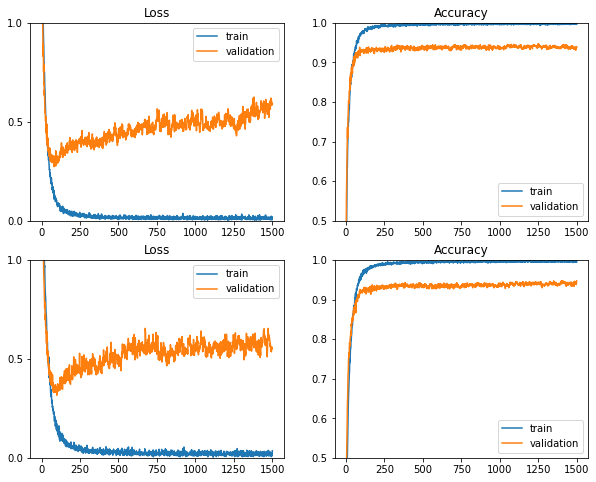

In [27]:
plot_models_history(models_history, min_loss=0, max_loss = 1, step_loss=0.5, min_eval_score=0.5, max_eval_score=1, step_eval_score=0.1 )

The difference is minimal so will use the previous model. Now we will see the model perfomance with difference droupout values

In [28]:
dropout_list = [0.25,0.5, 0.75]
base_model_history = list()

for dropout_value in dropout_list:

    base_model = K.models.Sequential()
    base_model.add(K.layers.Dense(256, activation='relu', input_shape=(final_data.shape[1],)))
    base_model.add(K.layers.Dropout(droupout_value))
    base_model.add(K.layers.Dense(128, activation='relu'))
    base_model.add(K.layers.Dropout(droupout_value))
    base_model.add(K.layers.Dense(64, activation='relu'))
    base_model.add(K.layers.Dropout(droupout_value))
    base_model.add(K.layers.Dense(64, activation='relu'))
    base_model.add(K.layers.Dropout(droupout_value))
    base_model.add(K.layers.Dense(32, activation='relu'))
    base_model.add(K.layers.Dropout(droupout_value))
    base_model.add(K.layers.Dense(labels.shape[1], activation='softmax'))
    
    base_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


    base_model_history.append( base_model.fit(x_train, 
                                    y_train, 
                                    batch_size=512, 
                                    epochs = 600,
                                    validation_data=(x_val, y_val)) )

Train on 3261 samples, validate on 1087 samples
Epoch 1/600
3261/3261 [==============================] - 0s - loss: 2.2756 - acc: 0.1426 - val_loss: 2.1384 - val_acc: 0.3523
Epoch 2/600
3261/3261 [==============================] - 0s - loss: 2.1489 - acc: 0.2282 - val_loss: 1.9618 - val_acc: 0.3910
Epoch 3/600
3261/3261 [==============================] - 0s - loss: 2.0236 - acc: 0.2849 - val_loss: 1.8227 - val_acc: 0.3956
Epoch 4/600
3261/3261 [==============================] - 0s - loss: 1.9169 - acc: 0.3379 - val_loss: 1.7077 - val_acc: 0.4627
Epoch 5/600
3261/3261 [==============================] - 0s - loss: 1.8390 - acc: 0.3787 - val_loss: 1.6055 - val_acc: 0.4885
Epoch 6/600
3261/3261 [==============================] - 0s - loss: 1.7385 - acc: 0.3990 - val_loss: 1.5227 - val_acc: 0.4959
Epoch 7/600
3261/3261 [==============================] - 0s - loss: 1.6921 - acc: 0.4247 - val_loss: 1.4623 - val_acc: 0.5198
Epoch 8/600
3261/3261 [==============================] - 0s - loss: 1.

3261/3261 [==============================] - 0s - loss: 0.5628 - acc: 0.8261 - val_loss: 0.4553 - val_acc: 0.8583
Epoch 66/600
3261/3261 [==============================] - 0s - loss: 0.5520 - acc: 0.8372 - val_loss: 0.4513 - val_acc: 0.8583
Epoch 67/600
3261/3261 [==============================] - 0s - loss: 0.5290 - acc: 0.8390 - val_loss: 0.4437 - val_acc: 0.8592
Epoch 68/600
3261/3261 [==============================] - 0s - loss: 0.5380 - acc: 0.8286 - val_loss: 0.4219 - val_acc: 0.8730
Epoch 69/600
3261/3261 [==============================] - 0s - loss: 0.5394 - acc: 0.8316 - val_loss: 0.4216 - val_acc: 0.8675
Epoch 70/600
3261/3261 [==============================] - 0s - loss: 0.5282 - acc: 0.8344 - val_loss: 0.4078 - val_acc: 0.8730
Epoch 71/600
3261/3261 [==============================] - 0s - loss: 0.5214 - acc: 0.8378 - val_loss: 0.4306 - val_acc: 0.8620
Epoch 72/600
3261/3261 [==============================] - 0s - loss: 0.4996 - acc: 0.8418 - val_loss: 0.4423 - val_acc: 0.85

3261/3261 [==============================] - 0s - loss: 0.2931 - acc: 0.9089 - val_loss: 0.3069 - val_acc: 0.9016
Epoch 130/600
3261/3261 [==============================] - 0s - loss: 0.2978 - acc: 0.9141 - val_loss: 0.2955 - val_acc: 0.9117
Epoch 131/600
3261/3261 [==============================] - 0s - loss: 0.2910 - acc: 0.9117 - val_loss: 0.2987 - val_acc: 0.9043
Epoch 132/600
3261/3261 [==============================] - 0s - loss: 0.2737 - acc: 0.9193 - val_loss: 0.2916 - val_acc: 0.9043
Epoch 133/600
3261/3261 [==============================] - 0s - loss: 0.2672 - acc: 0.9261 - val_loss: 0.2879 - val_acc: 0.9154
Epoch 134/600
3261/3261 [==============================] - 0s - loss: 0.2758 - acc: 0.9197 - val_loss: 0.2936 - val_acc: 0.9071
Epoch 135/600
3261/3261 [==============================] - 0s - loss: 0.2916 - acc: 0.9163 - val_loss: 0.2970 - val_acc: 0.9043
Epoch 136/600
3261/3261 [==============================] - 0s - loss: 0.2695 - acc: 0.9224 - val_loss: 0.2942 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1862 - acc: 0.9497 - val_loss: 0.2926 - val_acc: 0.9236
Epoch 194/600
3261/3261 [==============================] - 0s - loss: 0.1654 - acc: 0.9500 - val_loss: 0.2839 - val_acc: 0.9209
Epoch 195/600
3261/3261 [==============================] - 0s - loss: 0.1879 - acc: 0.9442 - val_loss: 0.2919 - val_acc: 0.9172
Epoch 196/600
3261/3261 [==============================] - 0s - loss: 0.1800 - acc: 0.9457 - val_loss: 0.2867 - val_acc: 0.9190
Epoch 197/600
3261/3261 [==============================] - 0s - loss: 0.1711 - acc: 0.9488 - val_loss: 0.2939 - val_acc: 0.9209
Epoch 198/600
3261/3261 [==============================] - 0s - loss: 0.1680 - acc: 0.9555 - val_loss: 0.2926 - val_acc: 0.9227
Epoch 199/600
3261/3261 [==============================] - 0s - loss: 0.1672 - acc: 0.9525 - val_loss: 0.2983 - val_acc: 0.9200
Epoch 200/600
3261/3261 [==============================] - 0s - loss: 0.1621 - acc: 0.9552 - val_loss: 0.3122 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1299 - acc: 0.9620 - val_loss: 0.2887 - val_acc: 0.9273
Epoch 258/600
3261/3261 [==============================] - 0s - loss: 0.1246 - acc: 0.9632 - val_loss: 0.2976 - val_acc: 0.9292
Epoch 259/600
3261/3261 [==============================] - 0s - loss: 0.1308 - acc: 0.9660 - val_loss: 0.3015 - val_acc: 0.9264
Epoch 260/600
3261/3261 [==============================] - 0s - loss: 0.1452 - acc: 0.9635 - val_loss: 0.3073 - val_acc: 0.9292
Epoch 261/600
3261/3261 [==============================] - 0s - loss: 0.1231 - acc: 0.9650 - val_loss: 0.2990 - val_acc: 0.9347
Epoch 262/600
3261/3261 [==============================] - 0s - loss: 0.1285 - acc: 0.9617 - val_loss: 0.2971 - val_acc: 0.9310
Epoch 263/600
3261/3261 [==============================] - 0s - loss: 0.1194 - acc: 0.9644 - val_loss: 0.2979 - val_acc: 0.9292
Epoch 264/600
3261/3261 [==============================] - 0s - loss: 0.1117 - acc: 0.9721 - val_loss: 0.3092 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1091 - acc: 0.9703 - val_loss: 0.2992 - val_acc: 0.9328
Epoch 322/600
3261/3261 [==============================] - 0s - loss: 0.1119 - acc: 0.9730 - val_loss: 0.3161 - val_acc: 0.9301
Epoch 323/600
3261/3261 [==============================] - 0s - loss: 0.0826 - acc: 0.9770 - val_loss: 0.3071 - val_acc: 0.9282
Epoch 324/600
3261/3261 [==============================] - 0s - loss: 0.0897 - acc: 0.9755 - val_loss: 0.3136 - val_acc: 0.9338
Epoch 325/600
3261/3261 [==============================] - 0s - loss: 0.1061 - acc: 0.9712 - val_loss: 0.3131 - val_acc: 0.9328
Epoch 326/600
3261/3261 [==============================] - 0s - loss: 0.0995 - acc: 0.9733 - val_loss: 0.3146 - val_acc: 0.9292
Epoch 327/600
3261/3261 [==============================] - 0s - loss: 0.1107 - acc: 0.9699 - val_loss: 0.3077 - val_acc: 0.9310
Epoch 328/600
3261/3261 [==============================] - 0s - loss: 0.1081 - acc: 0.9727 - val_loss: 0.3290 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0841 - acc: 0.9785 - val_loss: 0.3099 - val_acc: 0.9338
Epoch 386/600
3261/3261 [==============================] - 0s - loss: 0.0841 - acc: 0.9782 - val_loss: 0.3128 - val_acc: 0.9356
Epoch 387/600
3261/3261 [==============================] - 0s - loss: 0.0824 - acc: 0.9767 - val_loss: 0.3268 - val_acc: 0.9319
Epoch 388/600
3261/3261 [==============================] - 0s - loss: 0.0990 - acc: 0.9724 - val_loss: 0.3197 - val_acc: 0.9347
Epoch 389/600
3261/3261 [==============================] - 0s - loss: 0.0926 - acc: 0.9782 - val_loss: 0.3321 - val_acc: 0.9319
Epoch 390/600
3261/3261 [==============================] - 0s - loss: 0.0979 - acc: 0.9745 - val_loss: 0.3235 - val_acc: 0.9319
Epoch 391/600
3261/3261 [==============================] - 0s - loss: 0.0886 - acc: 0.9773 - val_loss: 0.3265 - val_acc: 0.9310
Epoch 392/600
3261/3261 [==============================] - 0s - loss: 0.0835 - acc: 0.9779 - val_loss: 0.3260 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0641 - acc: 0.9837 - val_loss: 0.3707 - val_acc: 0.9310
Epoch 450/600
3261/3261 [==============================] - 0s - loss: 0.0742 - acc: 0.9813 - val_loss: 0.3585 - val_acc: 0.9374
Epoch 451/600
3261/3261 [==============================] - 0s - loss: 0.0948 - acc: 0.9770 - val_loss: 0.3617 - val_acc: 0.9328
Epoch 452/600
3261/3261 [==============================] - 0s - loss: 0.0712 - acc: 0.9788 - val_loss: 0.3652 - val_acc: 0.9347
Epoch 453/600
3261/3261 [==============================] - 0s - loss: 0.0579 - acc: 0.9850 - val_loss: 0.3516 - val_acc: 0.9347
Epoch 454/600
3261/3261 [==============================] - 0s - loss: 0.0657 - acc: 0.9853 - val_loss: 0.3504 - val_acc: 0.9384
Epoch 455/600
3261/3261 [==============================] - 0s - loss: 0.0809 - acc: 0.9788 - val_loss: 0.3377 - val_acc: 0.9384
Epoch 456/600
3261/3261 [==============================] - 0s - loss: 0.0740 - acc: 0.9798 - val_loss: 0.3459 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0741 - acc: 0.9837 - val_loss: 0.3330 - val_acc: 0.9411
Epoch 514/600
3261/3261 [==============================] - 0s - loss: 0.0543 - acc: 0.9853 - val_loss: 0.3427 - val_acc: 0.9402
Epoch 515/600
3261/3261 [==============================] - 0s - loss: 0.0541 - acc: 0.9868 - val_loss: 0.3365 - val_acc: 0.9420
Epoch 516/600
3261/3261 [==============================] - 0s - loss: 0.0654 - acc: 0.9847 - val_loss: 0.3353 - val_acc: 0.9420
Epoch 517/600
3261/3261 [==============================] - 0s - loss: 0.0841 - acc: 0.9795 - val_loss: 0.3384 - val_acc: 0.9420
Epoch 518/600
3261/3261 [==============================] - 0s - loss: 0.0585 - acc: 0.9844 - val_loss: 0.3454 - val_acc: 0.9393
Epoch 519/600
3261/3261 [==============================] - 0s - loss: 0.0647 - acc: 0.9819 - val_loss: 0.3483 - val_acc: 0.9365
Epoch 520/600
3261/3261 [==============================] - 0s - loss: 0.0641 - acc: 0.9834 - val_loss: 0.3292 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0655 - acc: 0.9847 - val_loss: 0.3409 - val_acc: 0.9374
Epoch 578/600
3261/3261 [==============================] - 0s - loss: 0.0498 - acc: 0.9856 - val_loss: 0.3252 - val_acc: 0.9384
Epoch 579/600
3261/3261 [==============================] - 0s - loss: 0.0485 - acc: 0.9862 - val_loss: 0.3267 - val_acc: 0.9411
Epoch 580/600
3261/3261 [==============================] - 0s - loss: 0.0569 - acc: 0.9859 - val_loss: 0.3241 - val_acc: 0.9402
Epoch 581/600
3261/3261 [==============================] - 0s - loss: 0.0563 - acc: 0.9859 - val_loss: 0.3280 - val_acc: 0.9365
Epoch 582/600
3261/3261 [==============================] - 0s - loss: 0.0697 - acc: 0.9819 - val_loss: 0.3289 - val_acc: 0.9384
Epoch 583/600
3261/3261 [==============================] - 0s - loss: 0.0654 - acc: 0.9853 - val_loss: 0.3457 - val_acc: 0.9402
Epoch 584/600
3261/3261 [==============================] - 0s - loss: 0.0543 - acc: 0.9844 - val_loss: 0.3386 - val_ac

3261/3261 [==============================] - 0s - loss: 0.7977 - acc: 0.7519 - val_loss: 0.6413 - val_acc: 0.7893
Epoch 42/600
3261/3261 [==============================] - 0s - loss: 0.7913 - acc: 0.7461 - val_loss: 0.6653 - val_acc: 0.7976
Epoch 43/600
3261/3261 [==============================] - 0s - loss: 0.7836 - acc: 0.7443 - val_loss: 0.6361 - val_acc: 0.7948
Epoch 44/600
3261/3261 [==============================] - 0s - loss: 0.7617 - acc: 0.7602 - val_loss: 0.6259 - val_acc: 0.8068
Epoch 45/600
3261/3261 [==============================] - 0s - loss: 0.7554 - acc: 0.7504 - val_loss: 0.6126 - val_acc: 0.8132
Epoch 46/600
3261/3261 [==============================] - 0s - loss: 0.7236 - acc: 0.7688 - val_loss: 0.6130 - val_acc: 0.8040
Epoch 47/600
3261/3261 [==============================] - 0s - loss: 0.7349 - acc: 0.7663 - val_loss: 0.5787 - val_acc: 0.8197
Epoch 48/600
3261/3261 [==============================] - 0s - loss: 0.7007 - acc: 0.7669 - val_loss: 0.5891 - val_acc: 0.81

3261/3261 [==============================] - 0s - loss: 0.3660 - acc: 0.8856 - val_loss: 0.3559 - val_acc: 0.8878
Epoch 106/600
3261/3261 [==============================] - 0s - loss: 0.3552 - acc: 0.8921 - val_loss: 0.3539 - val_acc: 0.8868
Epoch 107/600
3261/3261 [==============================] - 0s - loss: 0.3654 - acc: 0.8844 - val_loss: 0.3480 - val_acc: 0.8942
Epoch 108/600
3261/3261 [==============================] - 0s - loss: 0.3687 - acc: 0.8822 - val_loss: 0.3614 - val_acc: 0.8896
Epoch 109/600
3261/3261 [==============================] - 0s - loss: 0.3683 - acc: 0.8859 - val_loss: 0.3492 - val_acc: 0.8905
Epoch 110/600
3261/3261 [==============================] - 0s - loss: 0.3512 - acc: 0.8921 - val_loss: 0.3396 - val_acc: 0.8896
Epoch 111/600
3261/3261 [==============================] - 0s - loss: 0.3595 - acc: 0.8902 - val_loss: 0.3391 - val_acc: 0.8914
Epoch 112/600
3261/3261 [==============================] - 0s - loss: 0.3507 - acc: 0.8948 - val_loss: 0.3487 - val_ac

3261/3261 [==============================] - 0s - loss: 0.2111 - acc: 0.9353 - val_loss: 0.3131 - val_acc: 0.9172
Epoch 170/600
3261/3261 [==============================] - 0s - loss: 0.2308 - acc: 0.9338 - val_loss: 0.3063 - val_acc: 0.9200
Epoch 171/600
3261/3261 [==============================] - 0s - loss: 0.2150 - acc: 0.9390 - val_loss: 0.2860 - val_acc: 0.9218
Epoch 172/600
3261/3261 [==============================] - 0s - loss: 0.2198 - acc: 0.9377 - val_loss: 0.2956 - val_acc: 0.9200
Epoch 173/600
3261/3261 [==============================] - 0s - loss: 0.2230 - acc: 0.9304 - val_loss: 0.2881 - val_acc: 0.9246
Epoch 174/600
3261/3261 [==============================] - 0s - loss: 0.2174 - acc: 0.9393 - val_loss: 0.3046 - val_acc: 0.9200
Epoch 175/600
3261/3261 [==============================] - 0s - loss: 0.2195 - acc: 0.9384 - val_loss: 0.3092 - val_acc: 0.9190
Epoch 176/600
3261/3261 [==============================] - 0s - loss: 0.2032 - acc: 0.9402 - val_loss: 0.3102 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1422 - acc: 0.9614 - val_loss: 0.2870 - val_acc: 0.9319
Epoch 234/600
3261/3261 [==============================] - 0s - loss: 0.1557 - acc: 0.9571 - val_loss: 0.3056 - val_acc: 0.9236
Epoch 235/600
3261/3261 [==============================] - 0s - loss: 0.1547 - acc: 0.9586 - val_loss: 0.3009 - val_acc: 0.9319
Epoch 236/600
3261/3261 [==============================] - 0s - loss: 0.1547 - acc: 0.9549 - val_loss: 0.2999 - val_acc: 0.9264
Epoch 237/600
3261/3261 [==============================] - 0s - loss: 0.1401 - acc: 0.9604 - val_loss: 0.2947 - val_acc: 0.9292
Epoch 238/600
3261/3261 [==============================] - 0s - loss: 0.1510 - acc: 0.9607 - val_loss: 0.2886 - val_acc: 0.9301
Epoch 239/600
3261/3261 [==============================] - 0s - loss: 0.1482 - acc: 0.9592 - val_loss: 0.2948 - val_acc: 0.9301
Epoch 240/600
3261/3261 [==============================] - 0s - loss: 0.1634 - acc: 0.9555 - val_loss: 0.2983 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0999 - acc: 0.9733 - val_loss: 0.3197 - val_acc: 0.9338
Epoch 298/600
3261/3261 [==============================] - 0s - loss: 0.1188 - acc: 0.9678 - val_loss: 0.3155 - val_acc: 0.9338
Epoch 299/600
3261/3261 [==============================] - 0s - loss: 0.1098 - acc: 0.9699 - val_loss: 0.3021 - val_acc: 0.9356
Epoch 300/600
3261/3261 [==============================] - 0s - loss: 0.1170 - acc: 0.9703 - val_loss: 0.3171 - val_acc: 0.9347
Epoch 301/600
3261/3261 [==============================] - 0s - loss: 0.1160 - acc: 0.9663 - val_loss: 0.2974 - val_acc: 0.9365
Epoch 302/600
3261/3261 [==============================] - 0s - loss: 0.1023 - acc: 0.9733 - val_loss: 0.3180 - val_acc: 0.9328
Epoch 303/600
3261/3261 [==============================] - 0s - loss: 0.1119 - acc: 0.9712 - val_loss: 0.3240 - val_acc: 0.9347
Epoch 304/600
3261/3261 [==============================] - 0s - loss: 0.1055 - acc: 0.9749 - val_loss: 0.3325 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0981 - acc: 0.9742 - val_loss: 0.3477 - val_acc: 0.9328
Epoch 362/600
3261/3261 [==============================] - 0s - loss: 0.1004 - acc: 0.9742 - val_loss: 0.3468 - val_acc: 0.9319
Epoch 363/600
3261/3261 [==============================] - 0s - loss: 0.0954 - acc: 0.9761 - val_loss: 0.3472 - val_acc: 0.9301
Epoch 364/600
3261/3261 [==============================] - 0s - loss: 0.0854 - acc: 0.9767 - val_loss: 0.3394 - val_acc: 0.9347
Epoch 365/600
3261/3261 [==============================] - 0s - loss: 0.0810 - acc: 0.9785 - val_loss: 0.3344 - val_acc: 0.9365
Epoch 366/600
3261/3261 [==============================] - 0s - loss: 0.0823 - acc: 0.9791 - val_loss: 0.3380 - val_acc: 0.9347
Epoch 367/600
3261/3261 [==============================] - 0s - loss: 0.0979 - acc: 0.9742 - val_loss: 0.3346 - val_acc: 0.9356
Epoch 368/600
3261/3261 [==============================] - 0s - loss: 0.0840 - acc: 0.9779 - val_loss: 0.3455 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0749 - acc: 0.9810 - val_loss: 0.3246 - val_acc: 0.9420
Epoch 426/600
3261/3261 [==============================] - 0s - loss: 0.0651 - acc: 0.9850 - val_loss: 0.3512 - val_acc: 0.9347
Epoch 427/600
3261/3261 [==============================] - 0s - loss: 0.0722 - acc: 0.9810 - val_loss: 0.3452 - val_acc: 0.9374
Epoch 428/600
3261/3261 [==============================] - 0s - loss: 0.0729 - acc: 0.9825 - val_loss: 0.3439 - val_acc: 0.9328
Epoch 429/600
3261/3261 [==============================] - 0s - loss: 0.0681 - acc: 0.9819 - val_loss: 0.3489 - val_acc: 0.9365
Epoch 430/600
3261/3261 [==============================] - 0s - loss: 0.0995 - acc: 0.9730 - val_loss: 0.3289 - val_acc: 0.9411
Epoch 431/600
3261/3261 [==============================] - 0s - loss: 0.0678 - acc: 0.9850 - val_loss: 0.3432 - val_acc: 0.9356
Epoch 432/600
3261/3261 [==============================] - 0s - loss: 0.0668 - acc: 0.9828 - val_loss: 0.3549 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0569 - acc: 0.9847 - val_loss: 0.3621 - val_acc: 0.9356
Epoch 490/600
3261/3261 [==============================] - 0s - loss: 0.0734 - acc: 0.9825 - val_loss: 0.3587 - val_acc: 0.9374
Epoch 491/600
3261/3261 [==============================] - 0s - loss: 0.0743 - acc: 0.9807 - val_loss: 0.3789 - val_acc: 0.9374
Epoch 492/600
3261/3261 [==============================] - 0s - loss: 0.0724 - acc: 0.9804 - val_loss: 0.3574 - val_acc: 0.9384
Epoch 493/600
3261/3261 [==============================] - 0s - loss: 0.0623 - acc: 0.9850 - val_loss: 0.3556 - val_acc: 0.9402
Epoch 494/600
3261/3261 [==============================] - 0s - loss: 0.0785 - acc: 0.9804 - val_loss: 0.3468 - val_acc: 0.9393
Epoch 495/600
3261/3261 [==============================] - 0s - loss: 0.0582 - acc: 0.9856 - val_loss: 0.3484 - val_acc: 0.9411
Epoch 496/600
3261/3261 [==============================] - 0s - loss: 0.0781 - acc: 0.9801 - val_loss: 0.3525 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0461 - acc: 0.9868 - val_loss: 0.3765 - val_acc: 0.9328
Epoch 554/600
3261/3261 [==============================] - 0s - loss: 0.0685 - acc: 0.9822 - val_loss: 0.3490 - val_acc: 0.9356
Epoch 555/600
3261/3261 [==============================] - 0s - loss: 0.0547 - acc: 0.9853 - val_loss: 0.3509 - val_acc: 0.9402
Epoch 556/600
3261/3261 [==============================] - 0s - loss: 0.0639 - acc: 0.9834 - val_loss: 0.3616 - val_acc: 0.9365
Epoch 557/600
3261/3261 [==============================] - 0s - loss: 0.0624 - acc: 0.9822 - val_loss: 0.3767 - val_acc: 0.9384
Epoch 558/600
3261/3261 [==============================] - 0s - loss: 0.0612 - acc: 0.9828 - val_loss: 0.3629 - val_acc: 0.9374
Epoch 559/600
3261/3261 [==============================] - 0s - loss: 0.0680 - acc: 0.9816 - val_loss: 0.3504 - val_acc: 0.9374
Epoch 560/600
3261/3261 [==============================] - 0s - loss: 0.0584 - acc: 0.9844 - val_loss: 0.3567 - val_ac

3261/3261 [==============================] - 0s - loss: 1.3448 - acc: 0.5554 - val_loss: 1.0727 - val_acc: 0.6725
Epoch 17/600
3261/3261 [==============================] - 0s - loss: 1.3253 - acc: 0.5572 - val_loss: 1.0630 - val_acc: 0.6559
Epoch 18/600
3261/3261 [==============================] - 0s - loss: 1.2871 - acc: 0.5664 - val_loss: 1.0101 - val_acc: 0.7010
Epoch 19/600
3261/3261 [==============================] - 0s - loss: 1.2614 - acc: 0.5857 - val_loss: 0.9946 - val_acc: 0.7102
Epoch 20/600
3261/3261 [==============================] - 0s - loss: 1.2221 - acc: 0.6029 - val_loss: 0.9666 - val_acc: 0.7056
Epoch 21/600
3261/3261 [==============================] - 0s - loss: 1.1878 - acc: 0.6035 - val_loss: 0.9381 - val_acc: 0.7213
Epoch 22/600
3261/3261 [==============================] - 0s - loss: 1.1727 - acc: 0.6093 - val_loss: 0.9212 - val_acc: 0.7341
Epoch 23/600
3261/3261 [==============================] - 0s - loss: 1.1386 - acc: 0.6259 - val_loss: 0.8803 - val_acc: 0.73

3261/3261 [==============================] - 0s - loss: 0.5096 - acc: 0.8464 - val_loss: 0.4371 - val_acc: 0.8592
Epoch 81/600
3261/3261 [==============================] - 0s - loss: 0.4885 - acc: 0.8525 - val_loss: 0.4208 - val_acc: 0.8583
Epoch 82/600
3261/3261 [==============================] - 0s - loss: 0.4638 - acc: 0.8571 - val_loss: 0.4202 - val_acc: 0.8556
Epoch 83/600
3261/3261 [==============================] - 0s - loss: 0.4588 - acc: 0.8596 - val_loss: 0.4376 - val_acc: 0.8629
Epoch 84/600
3261/3261 [==============================] - 0s - loss: 0.4780 - acc: 0.8510 - val_loss: 0.4231 - val_acc: 0.8648
Epoch 85/600
3261/3261 [==============================] - 0s - loss: 0.4533 - acc: 0.8651 - val_loss: 0.4302 - val_acc: 0.8592
Epoch 86/600
3261/3261 [==============================] - 0s - loss: 0.4272 - acc: 0.8632 - val_loss: 0.4300 - val_acc: 0.8620
Epoch 87/600
3261/3261 [==============================] - 0s - loss: 0.4522 - acc: 0.8672 - val_loss: 0.4071 - val_acc: 0.85

3261/3261 [==============================] - 0s - loss: 0.2751 - acc: 0.9157 - val_loss: 0.3494 - val_acc: 0.8988
Epoch 145/600
3261/3261 [==============================] - 0s - loss: 0.2506 - acc: 0.9279 - val_loss: 0.3383 - val_acc: 0.9080
Epoch 146/600
3261/3261 [==============================] - 0s - loss: 0.2734 - acc: 0.9218 - val_loss: 0.3271 - val_acc: 0.9034
Epoch 147/600
3261/3261 [==============================] - 0s - loss: 0.2621 - acc: 0.9243 - val_loss: 0.3385 - val_acc: 0.9052
Epoch 148/600
3261/3261 [==============================] - 0s - loss: 0.2526 - acc: 0.9282 - val_loss: 0.3232 - val_acc: 0.9089
Epoch 149/600
3261/3261 [==============================] - 0s - loss: 0.2548 - acc: 0.9292 - val_loss: 0.3379 - val_acc: 0.9034
Epoch 150/600
3261/3261 [==============================] - 0s - loss: 0.2448 - acc: 0.9258 - val_loss: 0.3192 - val_acc: 0.9108
Epoch 151/600
3261/3261 [==============================] - 0s - loss: 0.2405 - acc: 0.9276 - val_loss: 0.3523 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1856 - acc: 0.9460 - val_loss: 0.3337 - val_acc: 0.9209
Epoch 209/600
3261/3261 [==============================] - 0s - loss: 0.1640 - acc: 0.9519 - val_loss: 0.3266 - val_acc: 0.9246
Epoch 210/600
3261/3261 [==============================] - 0s - loss: 0.1733 - acc: 0.9540 - val_loss: 0.3338 - val_acc: 0.9181
Epoch 211/600
3261/3261 [==============================] - 0s - loss: 0.1624 - acc: 0.9555 - val_loss: 0.3318 - val_acc: 0.9144
Epoch 212/600
3261/3261 [==============================] - 0s - loss: 0.1566 - acc: 0.9552 - val_loss: 0.3466 - val_acc: 0.9181
Epoch 213/600
3261/3261 [==============================] - 0s - loss: 0.1748 - acc: 0.9506 - val_loss: 0.3264 - val_acc: 0.9181
Epoch 214/600
3261/3261 [==============================] - 0s - loss: 0.1825 - acc: 0.9430 - val_loss: 0.3314 - val_acc: 0.9181
Epoch 215/600
3261/3261 [==============================] - 0s - loss: 0.1759 - acc: 0.9549 - val_loss: 0.3360 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1069 - acc: 0.9709 - val_loss: 0.3417 - val_acc: 0.9246
Epoch 273/600
3261/3261 [==============================] - 0s - loss: 0.1238 - acc: 0.9663 - val_loss: 0.3444 - val_acc: 0.9246
Epoch 274/600
3261/3261 [==============================] - 0s - loss: 0.1233 - acc: 0.9681 - val_loss: 0.3374 - val_acc: 0.9236
Epoch 275/600
3261/3261 [==============================] - 0s - loss: 0.1116 - acc: 0.9721 - val_loss: 0.3501 - val_acc: 0.9273
Epoch 276/600
3261/3261 [==============================] - 0s - loss: 0.1225 - acc: 0.9681 - val_loss: 0.3516 - val_acc: 0.9227
Epoch 277/600
3261/3261 [==============================] - 0s - loss: 0.1115 - acc: 0.9730 - val_loss: 0.3671 - val_acc: 0.9200
Epoch 278/600
3261/3261 [==============================] - 0s - loss: 0.1187 - acc: 0.9663 - val_loss: 0.3677 - val_acc: 0.9227
Epoch 279/600
3261/3261 [==============================] - 0s - loss: 0.1300 - acc: 0.9663 - val_loss: 0.3668 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0809 - acc: 0.9764 - val_loss: 0.3736 - val_acc: 0.9328
Epoch 337/600
3261/3261 [==============================] - 0s - loss: 0.1054 - acc: 0.9703 - val_loss: 0.3739 - val_acc: 0.9273
Epoch 338/600
3261/3261 [==============================] - 0s - loss: 0.0930 - acc: 0.9742 - val_loss: 0.3566 - val_acc: 0.9292
Epoch 339/600
3261/3261 [==============================] - 0s - loss: 0.1013 - acc: 0.9727 - val_loss: 0.3688 - val_acc: 0.9264
Epoch 340/600
3261/3261 [==============================] - 0s - loss: 0.0848 - acc: 0.9742 - val_loss: 0.3657 - val_acc: 0.9310
Epoch 341/600
3261/3261 [==============================] - 0s - loss: 0.1151 - acc: 0.9672 - val_loss: 0.3682 - val_acc: 0.9282
Epoch 342/600
3261/3261 [==============================] - 0s - loss: 0.0898 - acc: 0.9749 - val_loss: 0.3675 - val_acc: 0.9338
Epoch 343/600
3261/3261 [==============================] - 0s - loss: 0.1032 - acc: 0.9718 - val_loss: 0.3615 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0784 - acc: 0.9810 - val_loss: 0.3804 - val_acc: 0.9356
Epoch 401/600
3261/3261 [==============================] - 0s - loss: 0.0884 - acc: 0.9761 - val_loss: 0.3659 - val_acc: 0.9365
Epoch 402/600
3261/3261 [==============================] - 0s - loss: 0.0808 - acc: 0.9779 - val_loss: 0.3728 - val_acc: 0.9356
Epoch 403/600
3261/3261 [==============================] - 0s - loss: 0.0865 - acc: 0.9767 - val_loss: 0.3855 - val_acc: 0.9273
Epoch 404/600
3261/3261 [==============================] - 0s - loss: 0.0818 - acc: 0.9767 - val_loss: 0.3636 - val_acc: 0.9338
Epoch 405/600
3261/3261 [==============================] - 0s - loss: 0.0852 - acc: 0.9779 - val_loss: 0.3672 - val_acc: 0.9310
Epoch 406/600
3261/3261 [==============================] - 0s - loss: 0.0913 - acc: 0.9788 - val_loss: 0.3609 - val_acc: 0.9356
Epoch 407/600
3261/3261 [==============================] - 0s - loss: 0.0729 - acc: 0.9798 - val_loss: 0.3601 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0633 - acc: 0.9813 - val_loss: 0.4007 - val_acc: 0.9282
Epoch 465/600
3261/3261 [==============================] - 0s - loss: 0.0698 - acc: 0.9801 - val_loss: 0.3940 - val_acc: 0.9328
Epoch 466/600
3261/3261 [==============================] - 0s - loss: 0.0804 - acc: 0.9791 - val_loss: 0.3958 - val_acc: 0.9292
Epoch 467/600
3261/3261 [==============================] - 0s - loss: 0.0660 - acc: 0.9831 - val_loss: 0.3939 - val_acc: 0.9282
Epoch 468/600
3261/3261 [==============================] - 0s - loss: 0.0686 - acc: 0.9810 - val_loss: 0.3922 - val_acc: 0.9273
Epoch 469/600
3261/3261 [==============================] - 0s - loss: 0.0687 - acc: 0.9828 - val_loss: 0.3840 - val_acc: 0.9301
Epoch 470/600
3261/3261 [==============================] - 0s - loss: 0.0857 - acc: 0.9779 - val_loss: 0.3714 - val_acc: 0.9301
Epoch 471/600
3261/3261 [==============================] - 0s - loss: 0.0639 - acc: 0.9841 - val_loss: 0.3681 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0709 - acc: 0.9825 - val_loss: 0.3748 - val_acc: 0.9384
Epoch 529/600
3261/3261 [==============================] - 0s - loss: 0.0656 - acc: 0.9841 - val_loss: 0.3775 - val_acc: 0.9393
Epoch 530/600
3261/3261 [==============================] - 0s - loss: 0.0549 - acc: 0.9850 - val_loss: 0.3853 - val_acc: 0.9393
Epoch 531/600
3261/3261 [==============================] - 0s - loss: 0.0767 - acc: 0.9853 - val_loss: 0.3907 - val_acc: 0.9374
Epoch 532/600
3261/3261 [==============================] - 0s - loss: 0.0495 - acc: 0.9874 - val_loss: 0.3884 - val_acc: 0.9365
Epoch 533/600
3261/3261 [==============================] - 0s - loss: 0.0632 - acc: 0.9837 - val_loss: 0.3990 - val_acc: 0.9310
Epoch 534/600
3261/3261 [==============================] - 0s - loss: 0.0525 - acc: 0.9856 - val_loss: 0.3873 - val_acc: 0.9365
Epoch 535/600
3261/3261 [==============================] - 0s - loss: 0.0591 - acc: 0.9844 - val_loss: 0.3884 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0687 - acc: 0.9825 - val_loss: 0.3934 - val_acc: 0.9328
Epoch 593/600
3261/3261 [==============================] - 0s - loss: 0.0627 - acc: 0.9837 - val_loss: 0.4092 - val_acc: 0.9292
Epoch 594/600
3261/3261 [==============================] - 0s - loss: 0.0622 - acc: 0.9847 - val_loss: 0.3951 - val_acc: 0.9301
Epoch 595/600
3261/3261 [==============================] - 0s - loss: 0.0552 - acc: 0.9834 - val_loss: 0.3884 - val_acc: 0.9319
Epoch 596/600
3261/3261 [==============================] - 0s - loss: 0.0476 - acc: 0.9865 - val_loss: 0.3963 - val_acc: 0.9328
Epoch 597/600
3261/3261 [==============================] - 0s - loss: 0.0462 - acc: 0.9905 - val_loss: 0.3866 - val_acc: 0.9273
Epoch 598/600
3261/3261 [==============================] - 0s - loss: 0.0482 - acc: 0.9856 - val_loss: 0.4042 - val_acc: 0.9310
Epoch 599/600
3261/3261 [==============================] - 0s - loss: 0.0554 - acc: 0.9871 - val_loss: 0.4031 - val_ac

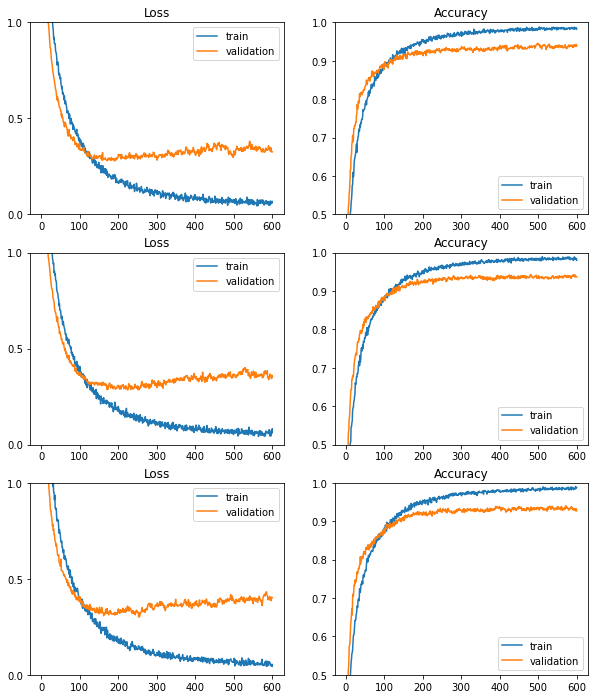

In [29]:
plot_models_history(base_model_history, min_loss=0, max_loss = 1, step_loss=0.5, min_eval_score=0.5, max_eval_score=1, step_eval_score=0.1 )

## Final decision
 
A dropout of 0.25 will be used in the base model

# Test the model in the test dataset

In [30]:
droupout_value=0.25

base_model = K.models.Sequential()
base_model.add(K.layers.Dense(256, activation='relu', input_shape=(final_data.shape[1],)))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(128, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(64, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(64, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(32, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(labels.shape[1], activation='softmax'))

base_model.compile(optimizer='rmsprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

base_model_history = base_model.fit(x_train, 
                                    y_train, 
                                    batch_size=512, 
                                    epochs = 600,
                                    validation_data=(x_val, y_val)) 

Train on 3261 samples, validate on 1087 samples
Epoch 1/600
3261/3261 [==============================] - 0s - loss: 2.2692 - acc: 0.1395 - val_loss: 2.1406 - val_acc: 0.2760
Epoch 2/600
3261/3261 [==============================] - 0s - loss: 2.1400 - acc: 0.2367 - val_loss: 1.9720 - val_acc: 0.3174
Epoch 3/600
3261/3261 [==============================] - 0s - loss: 1.9925 - acc: 0.2996 - val_loss: 1.8295 - val_acc: 0.3680
Epoch 4/600
3261/3261 [==============================] - 0s - loss: 1.8901 - acc: 0.3297 - val_loss: 1.7053 - val_acc: 0.3965
Epoch 5/600
3261/3261 [==============================] - 0s - loss: 1.8076 - acc: 0.3591 - val_loss: 1.6270 - val_acc: 0.4397
Epoch 6/600
3261/3261 [==============================] - 0s - loss: 1.7447 - acc: 0.3806 - val_loss: 1.5437 - val_acc: 0.4609
Epoch 7/600
3261/3261 [==============================] - 0s - loss: 1.6668 - acc: 0.4075 - val_loss: 1.5022 - val_acc: 0.4793
Epoch 8/600
3261/3261 [==============================] - 0s - loss: 1.

3261/3261 [==============================] - 0s - loss: 0.5951 - acc: 0.8071 - val_loss: 0.4951 - val_acc: 0.8436
Epoch 66/600
3261/3261 [==============================] - 0s - loss: 0.5842 - acc: 0.8145 - val_loss: 0.4813 - val_acc: 0.8464
Epoch 67/600
3261/3261 [==============================] - 0s - loss: 0.5718 - acc: 0.8178 - val_loss: 0.4639 - val_acc: 0.8482
Epoch 68/600
3261/3261 [==============================] - 0s - loss: 0.5767 - acc: 0.8188 - val_loss: 0.4599 - val_acc: 0.8546
Epoch 69/600
3261/3261 [==============================] - 0s - loss: 0.5686 - acc: 0.8252 - val_loss: 0.4650 - val_acc: 0.8537
Epoch 70/600
3261/3261 [==============================] - 0s - loss: 0.5352 - acc: 0.8237 - val_loss: 0.4605 - val_acc: 0.8574
Epoch 71/600
3261/3261 [==============================] - 0s - loss: 0.5457 - acc: 0.8270 - val_loss: 0.4488 - val_acc: 0.8611
Epoch 72/600
3261/3261 [==============================] - 0s - loss: 0.5509 - acc: 0.8298 - val_loss: 0.4560 - val_acc: 0.85

3261/3261 [==============================] - 0s - loss: 0.3112 - acc: 0.9108 - val_loss: 0.3011 - val_acc: 0.9080
Epoch 130/600
3261/3261 [==============================] - 0s - loss: 0.2928 - acc: 0.9117 - val_loss: 0.3059 - val_acc: 0.9071
Epoch 131/600
3261/3261 [==============================] - 0s - loss: 0.2805 - acc: 0.9163 - val_loss: 0.3036 - val_acc: 0.9080
Epoch 132/600
3261/3261 [==============================] - 0s - loss: 0.2880 - acc: 0.9193 - val_loss: 0.3048 - val_acc: 0.9043
Epoch 133/600
3261/3261 [==============================] - 0s - loss: 0.2878 - acc: 0.9135 - val_loss: 0.3042 - val_acc: 0.9006
Epoch 134/600
3261/3261 [==============================] - 0s - loss: 0.2630 - acc: 0.9221 - val_loss: 0.3195 - val_acc: 0.9080
Epoch 135/600
3261/3261 [==============================] - 0s - loss: 0.2889 - acc: 0.9184 - val_loss: 0.3132 - val_acc: 0.9052
Epoch 136/600
3261/3261 [==============================] - 0s - loss: 0.2782 - acc: 0.9175 - val_loss: 0.3075 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1809 - acc: 0.9519 - val_loss: 0.3071 - val_acc: 0.9181
Epoch 194/600
3261/3261 [==============================] - 0s - loss: 0.1983 - acc: 0.9433 - val_loss: 0.3166 - val_acc: 0.9144
Epoch 195/600
3261/3261 [==============================] - 0s - loss: 0.1779 - acc: 0.9540 - val_loss: 0.3158 - val_acc: 0.9209
Epoch 196/600
3261/3261 [==============================] - 0s - loss: 0.1651 - acc: 0.9537 - val_loss: 0.3302 - val_acc: 0.9135
Epoch 197/600
3261/3261 [==============================] - 0s - loss: 0.1808 - acc: 0.9497 - val_loss: 0.3427 - val_acc: 0.9190
Epoch 198/600
3261/3261 [==============================] - 0s - loss: 0.1622 - acc: 0.9509 - val_loss: 0.3351 - val_acc: 0.9163
Epoch 199/600
3261/3261 [==============================] - 0s - loss: 0.1837 - acc: 0.9448 - val_loss: 0.3200 - val_acc: 0.9246
Epoch 200/600
3261/3261 [==============================] - 0s - loss: 0.1626 - acc: 0.9497 - val_loss: 0.3143 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1344 - acc: 0.9611 - val_loss: 0.3098 - val_acc: 0.9319
Epoch 258/600
3261/3261 [==============================] - 0s - loss: 0.1487 - acc: 0.9626 - val_loss: 0.2992 - val_acc: 0.9338
Epoch 259/600
3261/3261 [==============================] - 0s - loss: 0.1370 - acc: 0.9614 - val_loss: 0.2954 - val_acc: 0.9328
Epoch 260/600
3261/3261 [==============================] - 0s - loss: 0.1195 - acc: 0.9672 - val_loss: 0.3048 - val_acc: 0.9310
Epoch 261/600
3261/3261 [==============================] - 0s - loss: 0.1490 - acc: 0.9620 - val_loss: 0.3034 - val_acc: 0.9273
Epoch 262/600
3261/3261 [==============================] - 0s - loss: 0.1245 - acc: 0.9611 - val_loss: 0.3090 - val_acc: 0.9319
Epoch 263/600
3261/3261 [==============================] - 0s - loss: 0.1294 - acc: 0.9623 - val_loss: 0.3002 - val_acc: 0.9310
Epoch 264/600
3261/3261 [==============================] - 0s - loss: 0.1154 - acc: 0.9706 - val_loss: 0.2983 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1068 - acc: 0.9712 - val_loss: 0.3186 - val_acc: 0.9347
Epoch 322/600
3261/3261 [==============================] - 0s - loss: 0.0851 - acc: 0.9749 - val_loss: 0.3259 - val_acc: 0.9328
Epoch 323/600
3261/3261 [==============================] - 0s - loss: 0.1046 - acc: 0.9724 - val_loss: 0.3271 - val_acc: 0.9347
Epoch 324/600
3261/3261 [==============================] - 0s - loss: 0.1017 - acc: 0.9672 - val_loss: 0.3328 - val_acc: 0.9328
Epoch 325/600
3261/3261 [==============================] - 0s - loss: 0.0906 - acc: 0.9779 - val_loss: 0.3264 - val_acc: 0.9347
Epoch 326/600
3261/3261 [==============================] - 0s - loss: 0.1126 - acc: 0.9696 - val_loss: 0.3497 - val_acc: 0.9338
Epoch 327/600
3261/3261 [==============================] - 0s - loss: 0.0874 - acc: 0.9739 - val_loss: 0.3344 - val_acc: 0.9328
Epoch 328/600
3261/3261 [==============================] - 0s - loss: 0.1029 - acc: 0.9764 - val_loss: 0.3512 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0779 - acc: 0.9801 - val_loss: 0.3432 - val_acc: 0.9356
Epoch 386/600
3261/3261 [==============================] - 0s - loss: 0.0876 - acc: 0.9801 - val_loss: 0.3508 - val_acc: 0.9347
Epoch 387/600
3261/3261 [==============================] - 0s - loss: 0.0769 - acc: 0.9785 - val_loss: 0.3583 - val_acc: 0.9301
Epoch 388/600
3261/3261 [==============================] - 0s - loss: 0.0902 - acc: 0.9788 - val_loss: 0.3573 - val_acc: 0.9301
Epoch 389/600
3261/3261 [==============================] - 0s - loss: 0.0754 - acc: 0.9791 - val_loss: 0.3629 - val_acc: 0.9301
Epoch 390/600
3261/3261 [==============================] - 0s - loss: 0.0713 - acc: 0.9825 - val_loss: 0.3691 - val_acc: 0.9310
Epoch 391/600
3261/3261 [==============================] - 0s - loss: 0.0704 - acc: 0.9822 - val_loss: 0.3803 - val_acc: 0.9227
Epoch 392/600
3261/3261 [==============================] - 0s - loss: 0.1025 - acc: 0.9733 - val_loss: 0.3711 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0829 - acc: 0.9819 - val_loss: 0.3460 - val_acc: 0.9411
Epoch 450/600
3261/3261 [==============================] - 0s - loss: 0.0643 - acc: 0.9850 - val_loss: 0.3477 - val_acc: 0.9384
Epoch 451/600
3261/3261 [==============================] - 0s - loss: 0.0835 - acc: 0.9795 - val_loss: 0.3398 - val_acc: 0.9365
Epoch 452/600
3261/3261 [==============================] - 0s - loss: 0.0708 - acc: 0.9813 - val_loss: 0.3529 - val_acc: 0.9374
Epoch 453/600
3261/3261 [==============================] - 0s - loss: 0.0615 - acc: 0.9859 - val_loss: 0.3574 - val_acc: 0.9319
Epoch 454/600
3261/3261 [==============================] - 0s - loss: 0.0760 - acc: 0.9804 - val_loss: 0.3588 - val_acc: 0.9328
Epoch 455/600
3261/3261 [==============================] - 0s - loss: 0.0617 - acc: 0.9834 - val_loss: 0.3602 - val_acc: 0.9347
Epoch 456/600
3261/3261 [==============================] - 0s - loss: 0.0569 - acc: 0.9856 - val_loss: 0.3646 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0795 - acc: 0.9785 - val_loss: 0.3562 - val_acc: 0.9347
Epoch 514/600
3261/3261 [==============================] - 0s - loss: 0.0841 - acc: 0.9816 - val_loss: 0.3472 - val_acc: 0.9374
Epoch 515/600
3261/3261 [==============================] - 0s - loss: 0.0668 - acc: 0.9828 - val_loss: 0.3602 - val_acc: 0.9338
Epoch 516/600
3261/3261 [==============================] - 0s - loss: 0.0797 - acc: 0.9831 - val_loss: 0.3459 - val_acc: 0.9365
Epoch 517/600
3261/3261 [==============================] - 0s - loss: 0.0585 - acc: 0.9850 - val_loss: 0.3500 - val_acc: 0.9402
Epoch 518/600
3261/3261 [==============================] - 0s - loss: 0.0658 - acc: 0.9853 - val_loss: 0.3571 - val_acc: 0.9347
Epoch 519/600
3261/3261 [==============================] - 0s - loss: 0.0692 - acc: 0.9810 - val_loss: 0.3593 - val_acc: 0.9338
Epoch 520/600
3261/3261 [==============================] - 0s - loss: 0.0702 - acc: 0.9810 - val_loss: 0.3543 - val_ac

3261/3261 [==============================] - 0s - loss: 0.0432 - acc: 0.9874 - val_loss: 0.3681 - val_acc: 0.9365
Epoch 578/600
3261/3261 [==============================] - 0s - loss: 0.0525 - acc: 0.9871 - val_loss: 0.3677 - val_acc: 0.9356
Epoch 579/600
3261/3261 [==============================] - 0s - loss: 0.0618 - acc: 0.9850 - val_loss: 0.3753 - val_acc: 0.9338
Epoch 580/600
3261/3261 [==============================] - 0s - loss: 0.0580 - acc: 0.9856 - val_loss: 0.3809 - val_acc: 0.9356
Epoch 581/600
3261/3261 [==============================] - 0s - loss: 0.0644 - acc: 0.9813 - val_loss: 0.3707 - val_acc: 0.9356
Epoch 582/600
3261/3261 [==============================] - 0s - loss: 0.0685 - acc: 0.9837 - val_loss: 0.3754 - val_acc: 0.9365
Epoch 583/600
3261/3261 [==============================] - 0s - loss: 0.0503 - acc: 0.9874 - val_loss: 0.3797 - val_acc: 0.9365
Epoch 584/600
3261/3261 [==============================] - 0s - loss: 0.0657 - acc: 0.9834 - val_loss: 0.3712 - val_ac

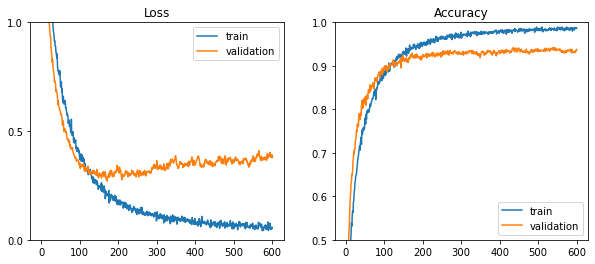

In [31]:
plot_models_history(base_model_history, min_loss=0, max_loss = 1, step_loss=0.5, min_eval_score=0.5, max_eval_score=1, step_eval_score=0.1 )

- We will set the epochs to 200

In [32]:
droupout_value=0.25

base_model = K.models.Sequential()
base_model.add(K.layers.Dense(256, activation='relu', input_shape=(final_data.shape[1],)))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(128, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(64, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(64, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(32, activation='relu'))
base_model.add(K.layers.Dropout(droupout_value))
base_model.add(K.layers.Dense(labels.shape[1], activation='softmax'))

base_model.compile(optimizer='rmsprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

base_model_history = base_model.fit(x_train, 
                                    y_train, 
                                    batch_size=512, 
                                    epochs = 200,
                                    validation_data=(x_val, y_val)) 

Train on 3261 samples, validate on 1087 samples
Epoch 1/200
3261/3261 [==============================] - 0s - loss: 2.2601 - acc: 0.1558 - val_loss: 2.1417 - val_acc: 0.3275
Epoch 2/200
3261/3261 [==============================] - 0s - loss: 2.1283 - acc: 0.2358 - val_loss: 1.9673 - val_acc: 0.3625
Epoch 3/200
3261/3261 [==============================] - 0s - loss: 1.9996 - acc: 0.3030 - val_loss: 1.8007 - val_acc: 0.4637
Epoch 4/200
3261/3261 [==============================] - 0s - loss: 1.8771 - acc: 0.3481 - val_loss: 1.6659 - val_acc: 0.4646
Epoch 5/200
3261/3261 [==============================] - 0s - loss: 1.7882 - acc: 0.3888 - val_loss: 1.5653 - val_acc: 0.5087
Epoch 6/200
3261/3261 [==============================] - 0s - loss: 1.7138 - acc: 0.4183 - val_loss: 1.4948 - val_acc: 0.5115
Epoch 7/200
3261/3261 [==============================] - 0s - loss: 1.6521 - acc: 0.4413 - val_loss: 1.4324 - val_acc: 0.5419
Epoch 8/200
3261/3261 [==============================] - 0s - loss: 1.

3261/3261 [==============================] - 0s - loss: 0.5723 - acc: 0.8234 - val_loss: 0.4700 - val_acc: 0.8491
Epoch 66/200
3261/3261 [==============================] - 0s - loss: 0.5529 - acc: 0.8264 - val_loss: 0.4617 - val_acc: 0.8390
Epoch 67/200
3261/3261 [==============================] - 0s - loss: 0.5350 - acc: 0.8356 - val_loss: 0.4668 - val_acc: 0.8454
Epoch 68/200
3261/3261 [==============================] - 0s - loss: 0.5396 - acc: 0.8258 - val_loss: 0.4520 - val_acc: 0.8491
Epoch 69/200
3261/3261 [==============================] - 0s - loss: 0.5331 - acc: 0.8323 - val_loss: 0.4429 - val_acc: 0.8565
Epoch 70/200
3261/3261 [==============================] - 0s - loss: 0.5586 - acc: 0.8270 - val_loss: 0.4540 - val_acc: 0.8445
Epoch 71/200
3261/3261 [==============================] - 0s - loss: 0.5274 - acc: 0.8301 - val_loss: 0.4567 - val_acc: 0.8556
Epoch 72/200
3261/3261 [==============================] - 0s - loss: 0.5177 - acc: 0.8396 - val_loss: 0.4504 - val_acc: 0.85

3261/3261 [==============================] - 0s - loss: 0.2836 - acc: 0.9249 - val_loss: 0.3187 - val_acc: 0.9043
Epoch 130/200
3261/3261 [==============================] - 0s - loss: 0.2848 - acc: 0.9215 - val_loss: 0.3154 - val_acc: 0.9052
Epoch 131/200
3261/3261 [==============================] - 0s - loss: 0.2729 - acc: 0.9209 - val_loss: 0.3151 - val_acc: 0.9071
Epoch 132/200
3261/3261 [==============================] - 0s - loss: 0.2807 - acc: 0.9236 - val_loss: 0.3404 - val_acc: 0.9034
Epoch 133/200
3261/3261 [==============================] - 0s - loss: 0.2642 - acc: 0.9209 - val_loss: 0.3203 - val_acc: 0.9117
Epoch 134/200
3261/3261 [==============================] - 0s - loss: 0.2536 - acc: 0.9270 - val_loss: 0.3157 - val_acc: 0.9080
Epoch 135/200
3261/3261 [==============================] - 0s - loss: 0.2554 - acc: 0.9243 - val_loss: 0.3265 - val_acc: 0.9034
Epoch 136/200
3261/3261 [==============================] - 0s - loss: 0.2532 - acc: 0.9255 - val_loss: 0.3410 - val_ac

3261/3261 [==============================] - 0s - loss: 0.1796 - acc: 0.9482 - val_loss: 0.2964 - val_acc: 0.9246
Epoch 194/200
3261/3261 [==============================] - 0s - loss: 0.1756 - acc: 0.9491 - val_loss: 0.3071 - val_acc: 0.9172
Epoch 195/200
3261/3261 [==============================] - 0s - loss: 0.1700 - acc: 0.9506 - val_loss: 0.2953 - val_acc: 0.9255
Epoch 196/200
3261/3261 [==============================] - 0s - loss: 0.1774 - acc: 0.9525 - val_loss: 0.2911 - val_acc: 0.9246
Epoch 197/200
3261/3261 [==============================] - 0s - loss: 0.1732 - acc: 0.9506 - val_loss: 0.3025 - val_acc: 0.9181
Epoch 198/200
3261/3261 [==============================] - 0s - loss: 0.1680 - acc: 0.9515 - val_loss: 0.3077 - val_acc: 0.9181
Epoch 199/200
3261/3261 [==============================] - 0s - loss: 0.1618 - acc: 0.9537 - val_loss: 0.3070 - val_acc: 0.9163
Epoch 200/200
3261/3261 [==============================] - 0s - loss: 0.1613 - acc: 0.9565 - val_loss: 0.3051 - val_ac

In [33]:
test_loss, test_accuracy = base_model.evaluate(x_test, y_test, batch_size=512)

 512/1087 [=============>................] - ETA: 0s

In [34]:
print("Model performance")
print("- Test Loss {0:.3f}".format(test_loss)) 
print("- Test Accuracy  {0:.3f}".format(test_accuracy))

Model performance
- Test Loss 0.365
- Test Accuracy  0.925


##### Save the model

In [36]:
base_model.save("./models.repo/model.fully.connected.network.h5")